# Import Libraries and Data

Importing All Required Libraries

In [ ]:
!pip install python_speech_features
from google.colab import drive
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from scipy.stats import skew
import numpy as np
from tempfile import TemporaryFile
import os
import random 
import operator
import math
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from statistics import mean
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import librosa
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.svm import l1_min_c
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

Importing Data from drive. Instructions for the next two cells:
<ol>
<li> Save the data found in the folder 'EE769Project_BAP' (all three .zip files) in your LDAP Google Drive. Ensure that the folder is named 'EE769Project_BAP' and that the folder is saved in your <i>main Drive folder</i></li>
<li>Run the next cell. It will ask for an authorization code and a url where it can be found. Click on the URL and login with your LDAP. Then, copy and paste the authorization code in the place asked.</li>
<li> Run the next cell with the unzip functions. After all three files are unzipped, you can reload the file browsing and check that all three Datasets are now unzipped and present.</li>
P.S. BAP stands for Bhushan-Anand-Prasanna. We don't claim to be the best project :P<br>
P.P.S. You can now listen to any genre of music you like. You're welcome.

In [ ]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/EE769Project_BAP/musicDataset.zip'
#!unzip '/content/drive/MyDrive/EE769Project_BAP/testDataset.zip'
!unzip '/content/drive/MyDrive/EE769Project_BAP/sampleDataset.zip'
#!unzip '/content/drive/MyDrive/EE769Project_BAP/Ground_Truth.zip'

Archive:  /content/drive/MyDrive/EE769Project_BAP/musicDataset.zip
replace musicDataset/blues/blues.00000.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: musicDataset/blues/blues.00000.wav  
  inflating: musicDataset/blues/blues.00001.wav  
  inflating: musicDataset/blues/blues.00002.wav  
  inflating: musicDataset/blues/blues.00003.wav  
  inflating: musicDataset/blues/blues.00004.wav  
  inflating: musicDataset/blues/blues.00005.wav  
  inflating: musicDataset/blues/blues.00006.wav  
  inflating: musicDataset/blues/blues.00007.wav  
  inflating: musicDataset/blues/blues.00008.wav  
  inflating: musicDataset/blues/blues.00009.wav  
  inflating: musicDataset/blues/blues.00010.wav  
  inflating: musicDataset/blues/blues.00011.wav  
  inflating: musicDataset/blues/blues.00012.wav  
  inflating: musicDataset/blues/blues.00013.wav  
  inflating: musicDataset/blues/blues.00014.wav  
  inflating: musicDataset/blues/blues.00015.wav  
  inflating: musicDataset/blues/blues.00016.wav  

In [ ]:
def makeCorrMatrix(df):
  corrMatrix = df.corr(method='spearman')
  fig, ax = plt.subplots(figsize=(38,38))
  sns.heatmap(abs(corrMatrix))
  plt.show()


def dispEntryInfo(df): #Function which displays Data type, number of unique entries, number of null entries of each column in a Pandas DataFrame df
  for col in df.columns.values: # For each column
    unique_vals = pd.unique(df[col]) # Creating list of unique values
    print(f"{col}:\t {len(unique_vals)} unique entries.") # Printing data regarding the column: Data type, number of unique values and number of null entries
    if len(unique_vals) <= 10: #If there are <= 10 unique values
      print(f"\tThese are: {unique_vals}\n")


def plotAllHist(df):
  for col in df.columns.values: # For each column in dataset
    print(df[col].dtypes)
    plt.hist(df[col])
    plt.xlabel(col)
    plt.show()


def audioCols():
  params = ['mean', 'std', 'skew', 'max', 'median', 'min']
  mfcc_cols = np.hstack((np.array(['mfcc_{}_{}'.format(i,j) for j in params for i in range(1,14)]), np.array(['{}_{}'.format(feat,param) for feat in ['zcr', 'spec_rolloff', 'spec_centroid', 'spec_bw'] for param in params]), np.array(['spec_contrast_{}_{}'.format(i,param) for param in params for i in range(1,8)]), np.array(['chrome_cens_{}_{}'.format(i,param) for param in params for i in range(1,13)])))
  return mfcc_cols


def extractFeaturesFromAudio(audioFile):
  (rate,sig) = wav.read(audioFile)
  (data,rate) = librosa.core.load(audioFile, sr=rate)
  mfcc_feat = librosa.feature.mfcc(data,sr=rate,n_mfcc=13)
  zcr = np.squeeze(librosa.feature.zero_crossing_rate(data))
  spec_rolloff = np.squeeze(librosa.feature.spectral_rolloff(data))
  spec_centroid = np.squeeze(librosa.feature.spectral_centroid(data))
  spec_contrast = np.squeeze(librosa.feature.spectral_contrast(data))
  spec_bw = np.squeeze(librosa.feature.spectral_bandwidth(data))
  chroma_cens = librosa.feature.chroma_cens(data, sr=rate)
  mfcc_feat_trunc = np.hstack((np.mean(mfcc_feat,axis=1), np.std(mfcc_feat,axis=1), skew(mfcc_feat,axis=1), np.max(mfcc_feat,axis=1), np.median(mfcc_feat,axis=1), np.min(mfcc_feat,axis=1)))
  zcr_trunc = np.hstack((np.mean(zcr), np.std(zcr), skew(zcr), np.max(zcr), np.median(zcr), np.min(zcr)))
  spec_rolloff_trunc = np.hstack((np.mean(spec_rolloff), np.std(spec_rolloff), skew(spec_rolloff), np.max(spec_rolloff), np.median(spec_rolloff), np.min(spec_rolloff)))
  spec_centroid_trunc = np.hstack((np.mean(spec_centroid), np.std(spec_centroid), skew(spec_centroid), np.max(spec_centroid), np.median(spec_centroid), np.min(spec_centroid)))
  spec_contrast_trunc = np.hstack((np.mean(spec_contrast,axis=1), np.std(spec_contrast,axis=1), skew(spec_contrast,axis=1), np.max(spec_contrast,axis=1), np.median(spec_contrast,axis=1), np.min(spec_contrast,axis=1)))
  spec_bw_trunc = np.hstack((np.mean(spec_bw), np.std(spec_bw), skew(spec_bw), np.max(spec_bw), np.median(spec_bw), np.min(spec_bw)))
  chroma_cens_trunc = np.hstack((np.mean(chroma_cens,axis=1), np.std(chroma_cens,axis=1), skew(chroma_cens,axis=1), np.max(chroma_cens,axis=1), np.median(chroma_cens,axis=1), np.min(chroma_cens,axis=1)))
  finaldf = pd.Series(data=np.hstack((np.matrix.transpose(mfcc_feat_trunc), zcr_trunc,spec_rolloff_trunc,spec_centroid_trunc,spec_bw_trunc,spec_contrast_trunc,chroma_cens_trunc)),index=audioCols())
  return finaldf


def removeUselessCols(df):
  cols_to_drop = []
  for col in df.columns.values:
    if col.find('median') != -1:
      cols_to_drop.append(col)
    if ((col.find('chroma_cens') != -1) and (col.find('min') != -1)):
      cols_to_drop.append(col)
  
  return df.drop(cols_to_drop, axis='columns')

# Converting Audio Files to usable Data

We are taking in the following parameters of each of the audio files:
  1. The first 13 MFCC parameters
  2. Zero Crossing Rate
  3. Spectral Rolloff
  4. Spectral Centroid
  5. Spectral Bandwidth
  6. Spectral Contrast (Of 7 octaves)
  7. Chroma Energy Normalized (Of 12 Notes)

Now, since each of the above data is available as a time series, (based on small windows of time for which the data is processed), we take the following features to represent each time series:
  1. Mean
  2. Standard Deviation
  3. Skew
  4. Maximum
  5. Median
  6. Minimum

Hence, we have 13\*6 + 6 + 6 + 6 + 6 + 7\*6 + 12\*6 = 216 columns in our database.<br>
Eventually, we will also try using Principal Component Analysis to reduce the number of dimensions we have (and also to remove redundant data)

In [ ]:
df_audio = pd.DataFrame(columns=audioCols())
right_genre = []
directory = "./musicDataset/"
i=0
print("Starting unpacking of audio data using MFCC")
for folder in os.listdir(directory):
    i+=1
    for audioFile in os.listdir(directory+folder):
      to_add = extractFeaturesFromAudio(directory+folder+"/"+audioFile)
      right_genre.append(folder)
      df_audio = df_audio.append(to_add, ignore_index=True)
    print(f"Finished {folder} Folder. {len(os.listdir(directory))-i} more to go!")

Starting unpacking of audio data using MFCC
Finished hiphop Folder. 9 more to go!
Finished reggae Folder. 8 more to go!
Finished metal Folder. 7 more to go!
Finished rock Folder. 6 more to go!
Finished classical Folder. 5 more to go!
Finished blues Folder. 4 more to go!
Finished pop Folder. 3 more to go!
Finished country Folder. 2 more to go!
Finished jazz Folder. 1 more to go!
Finished disco Folder. 0 more to go!


The Audio data has been analyzed fully.

# Data Visualization and Pre-Processing

We plot Histograms of each feature, Correlation Matrix, and also the Box Plots of each data to see if there are any abnormalities/redundant data.

In [ ]:
display(df_audio)
df_audio.info(verbose=True)

mfcc_1_mean  mfcc_2_mean  ...  chrome_cens_11_min  chrome_cens_12_min
0     -42.141018   106.256935  ...            0.019991            0.015151
1    -194.296722   151.881699  ...            0.007438            0.000000
2      -7.939366    62.723667  ...            0.003676            0.004939
3    -101.284462   120.425171  ...            0.121372            0.000000
4    -126.175415    77.663651  ...            0.023711            0.018169
..           ...          ...  ...                 ...                 ...
995   -74.083527    80.068756  ...            0.224144            0.205292
996     2.836352    77.069611  ...            0.099742            0.000063
997    22.877514    60.810783  ...            0.008288            0.000000
998   -93.555923    89.864960  ...            0.174063            0.175357
999  -107.106850    47.654846  ...            0.189905            0.084807

[1000 rows x 216 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 216 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   mfcc_1_mean             float64
 1   mfcc_2_mean             float64
 2   mfcc_3_mean             float64
 3   mfcc_4_mean             float64
 4   mfcc_5_mean             float64
 5   mfcc_6_mean             float64
 6   mfcc_7_mean             float64
 7   mfcc_8_mean             float64
 8   mfcc_9_mean             float64
 9   mfcc_10_mean            float64
 10  mfcc_11_mean            float64
 11  mfcc_12_mean            float64
 12  mfcc_13_mean            float64
 13  mfcc_1_std              float64
 14  mfcc_2_std              float64
 15  mfcc_3_std              float64
 16  mfcc_4_std              float64
 17  mfcc_5_std              float64
 18  mfcc_6_std              float64
 19  mfcc_7_std              float64
 20  mfcc_8_std              float64
 21  mfcc_9_std              float64
 22  

In [ ]:
dispEntryInfo(df_audio)

mfcc_1_mean:	 986 unique entries.
mfcc_2_mean:	 986 unique entries.
mfcc_3_mean:	 986 unique entries.
mfcc_4_mean:	 986 unique entries.
mfcc_5_mean:	 986 unique entries.
mfcc_6_mean:	 986 unique entries.
mfcc_7_mean:	 986 unique entries.
mfcc_8_mean:	 986 unique entries.
mfcc_9_mean:	 986 unique entries.
mfcc_10_mean:	 986 unique entries.
mfcc_11_mean:	 986 unique entries.
mfcc_12_mean:	 986 unique entries.
mfcc_13_mean:	 986 unique entries.
mfcc_1_std:	 986 unique entries.
mfcc_2_std:	 986 unique entries.
mfcc_3_std:	 986 unique entries.
mfcc_4_std:	 986 unique entries.
mfcc_5_std:	 986 unique entries.
mfcc_6_std:	 986 unique entries.
mfcc_7_std:	 986 unique entries.
mfcc_8_std:	 986 unique entries.
mfcc_9_std:	 986 unique entries.
mfcc_10_std:	 986 unique entries.
mfcc_11_std:	 986 unique entries.
mfcc_12_std:	 986 unique entries.
mfcc_13_std:	 986 unique entries.
mfcc_1_skew:	 986 unique entries.
mfcc_2_skew:	 986 unique entries.
mfcc_3_skew:	 986 unique entries.
mfcc_4_skew:	 986 u

float64


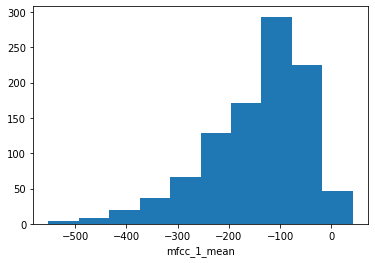

float64


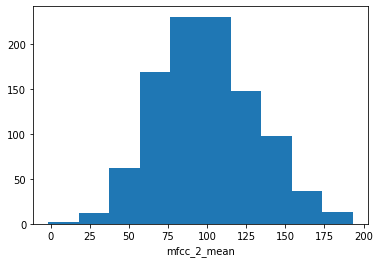

float64


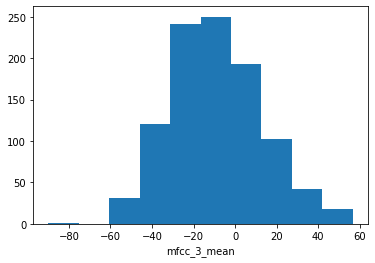

float64


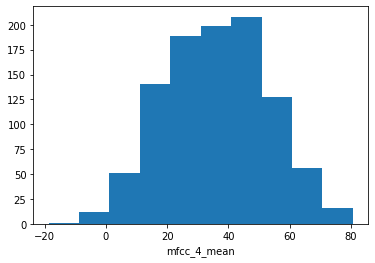

float64


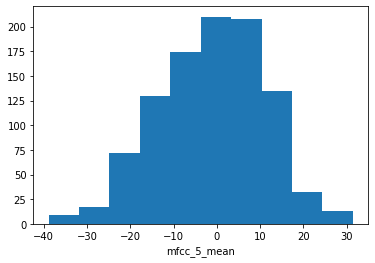

float64


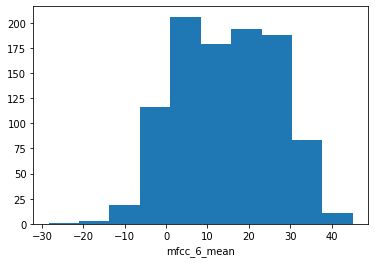

float64


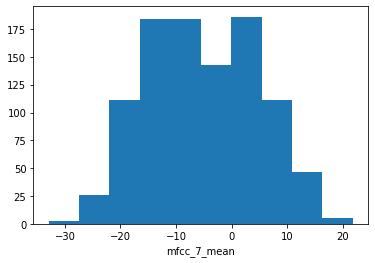

float64


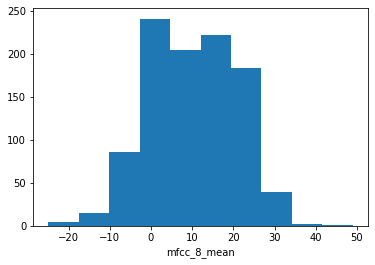

float64


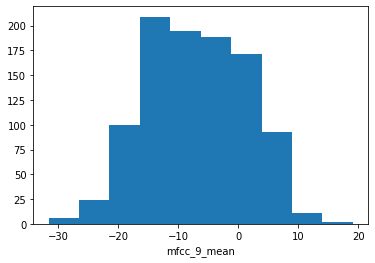

float64


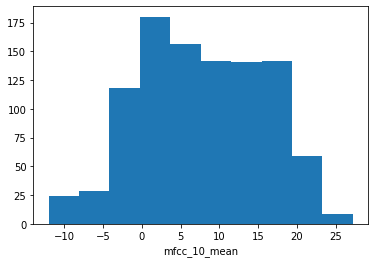

float64


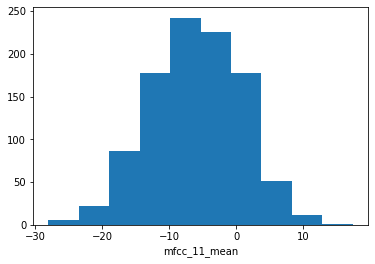

float64


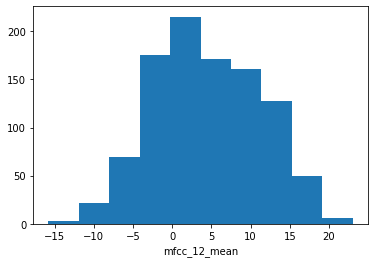

float64


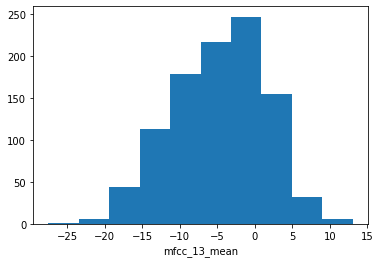

float64


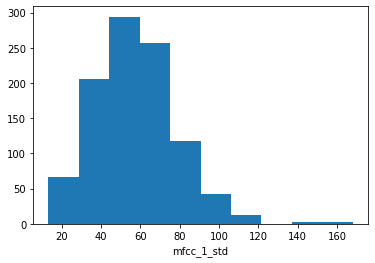

float64


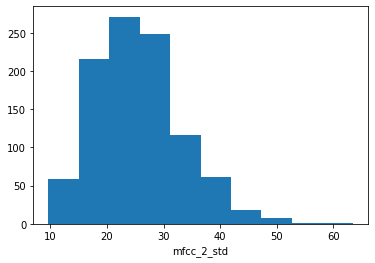

float64


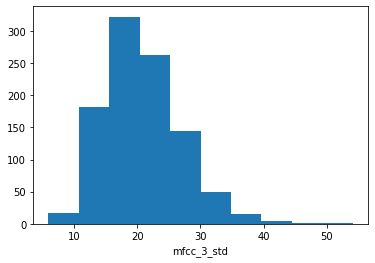

float64


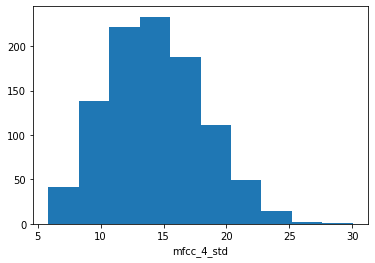

float64


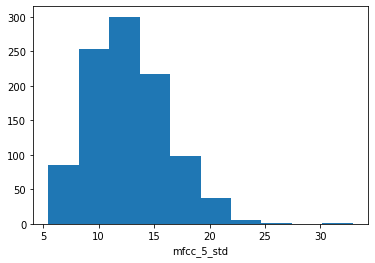

float64


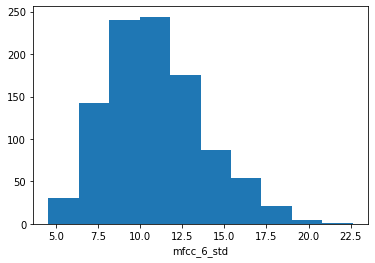

float64


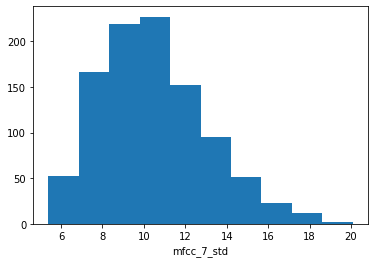

float64


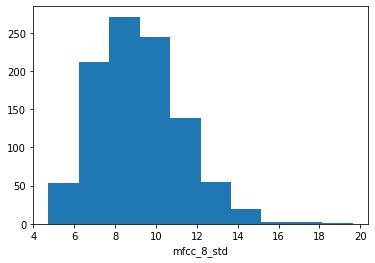

float64


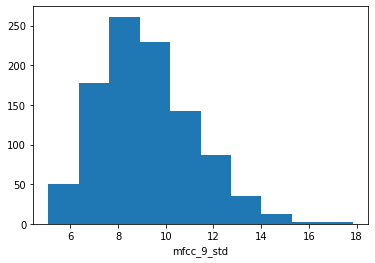

float64


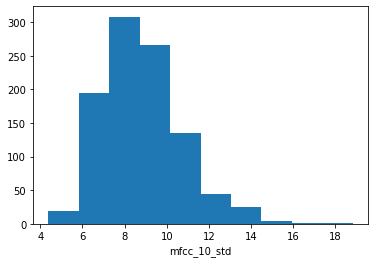

float64


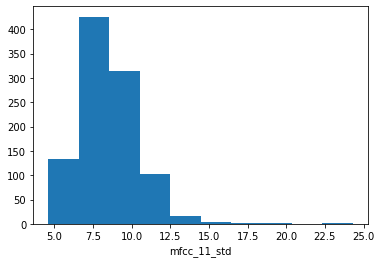

float64


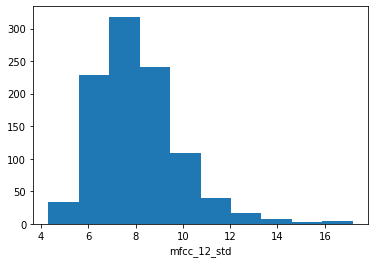

float64


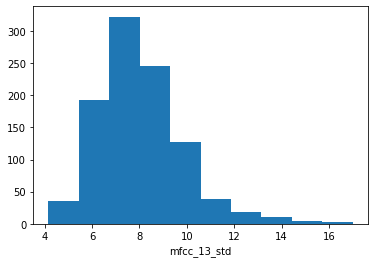

float64


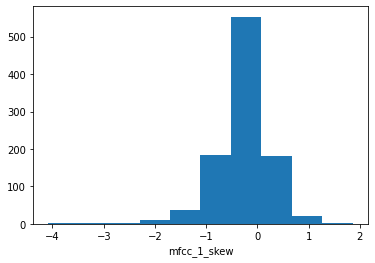

float64


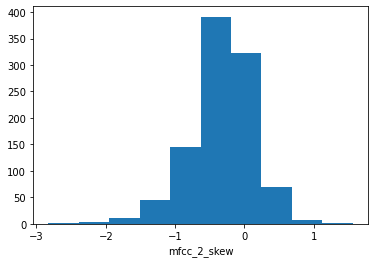

float64


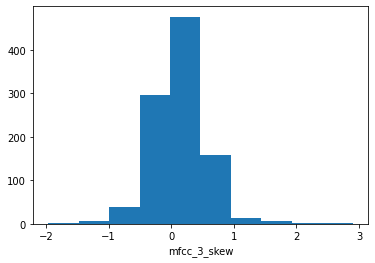

float64


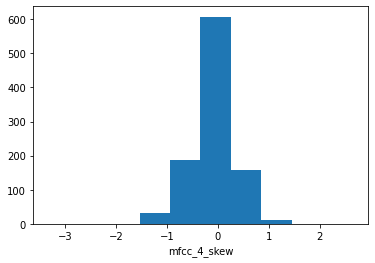

float64


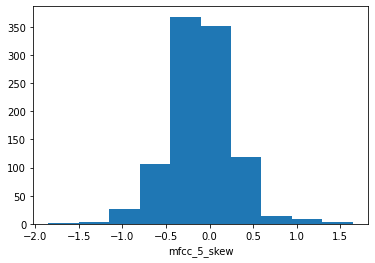

float64


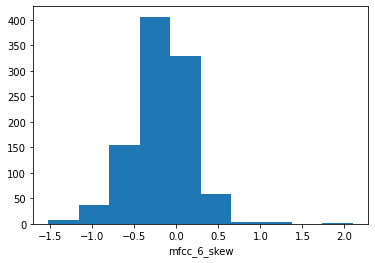

float64


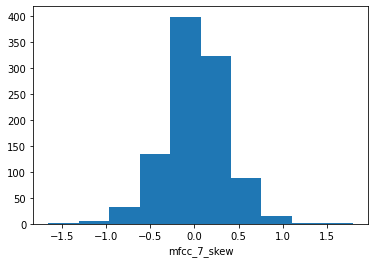

float64


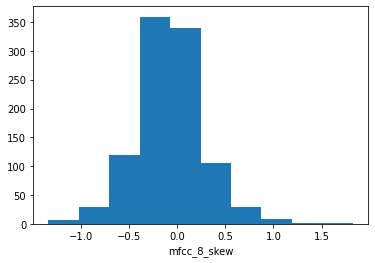

float64


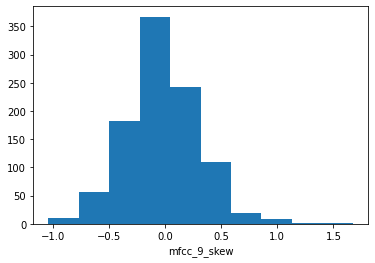

float64


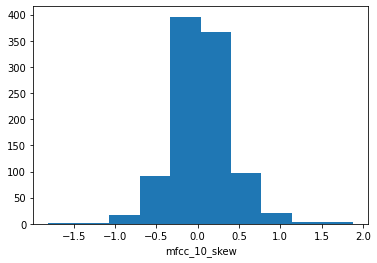

float64


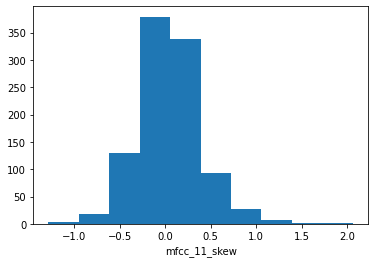

float64


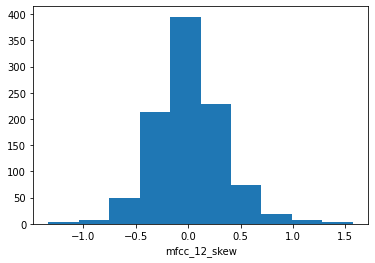

float64


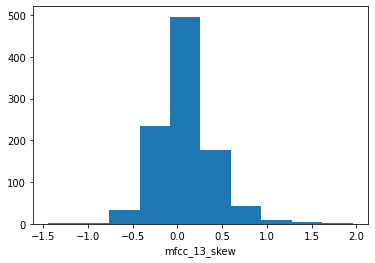

float64


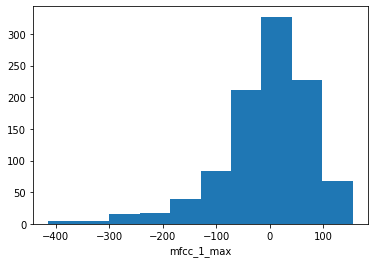

float64


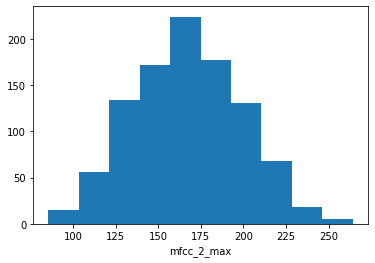

float64


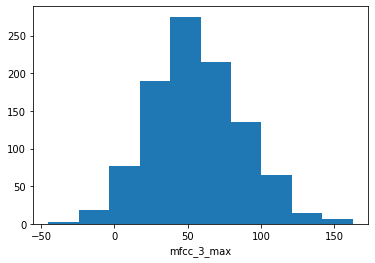

float64


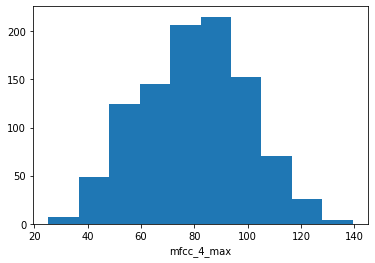

float64


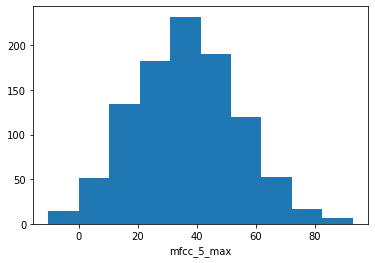

float64


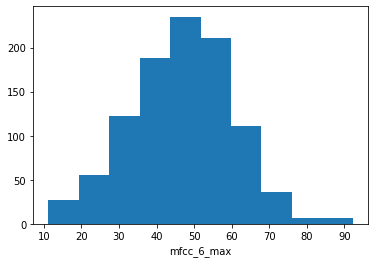

float64


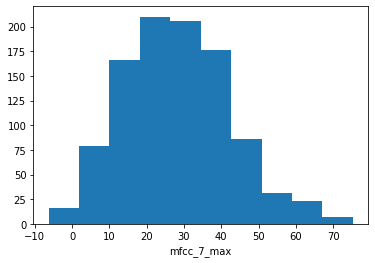

float64


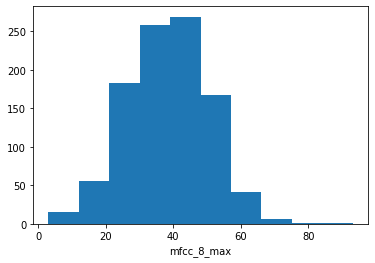

float64


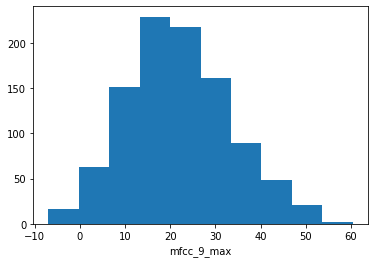

float64


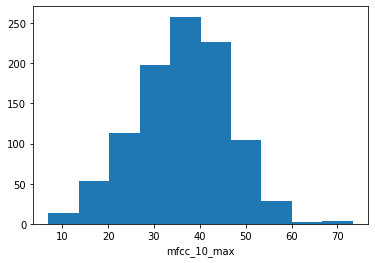

float64


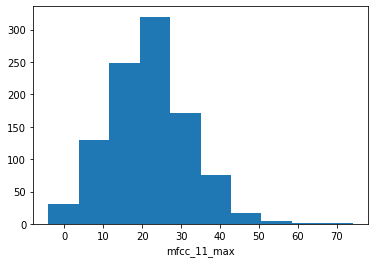

float64


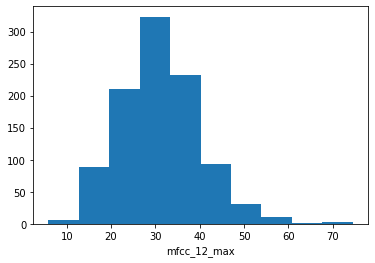

float64


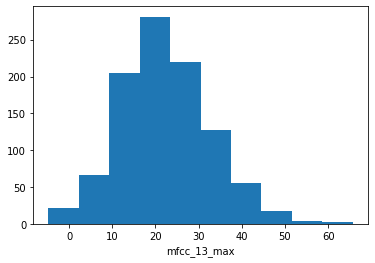

float64


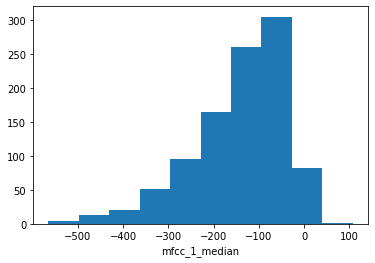

float64


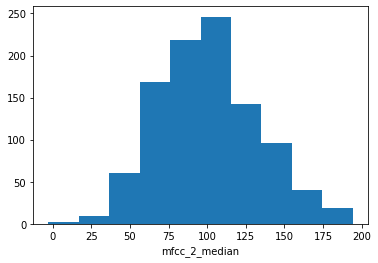

float64


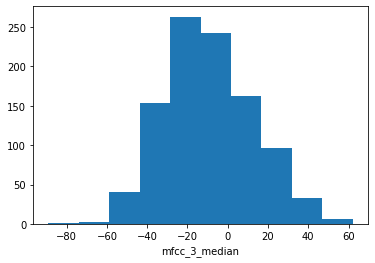

float64


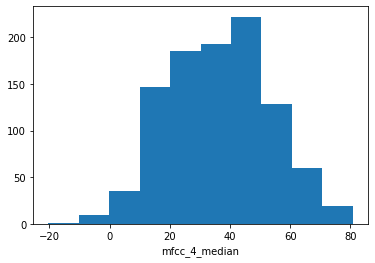

float64


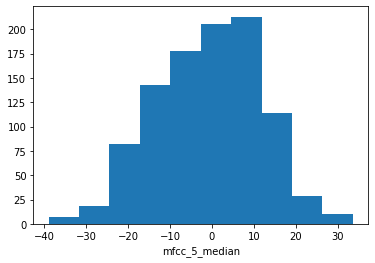

float64


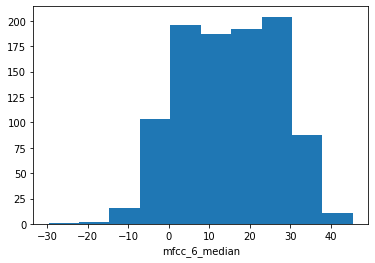

float64


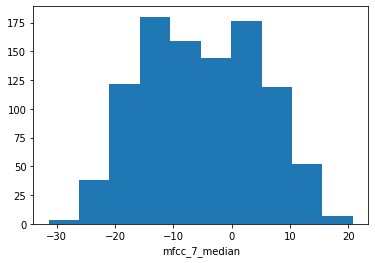

float64


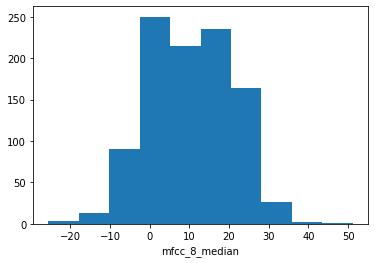

float64


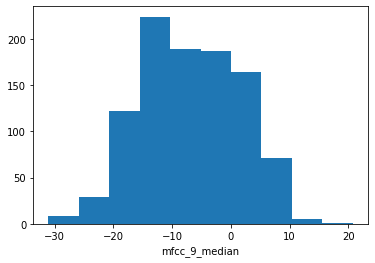

float64


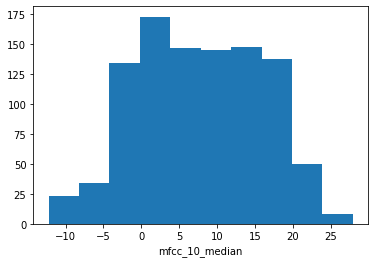

float64


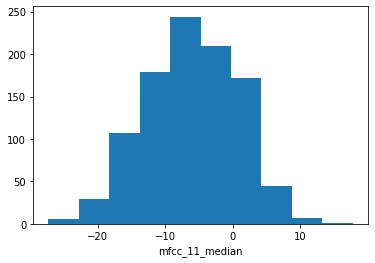

float64


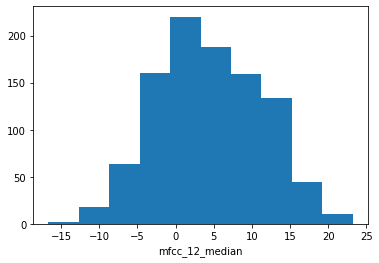

float64


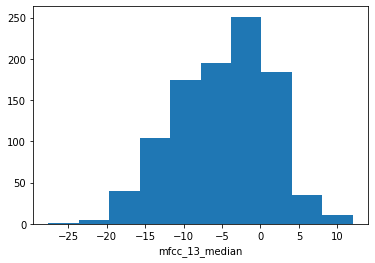

float64


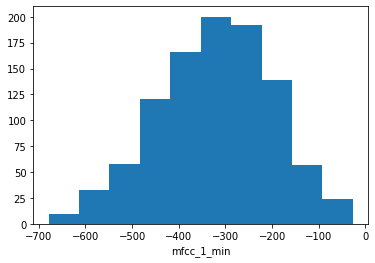

float64


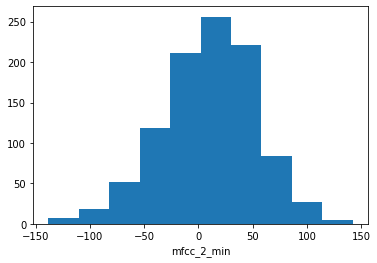

float64


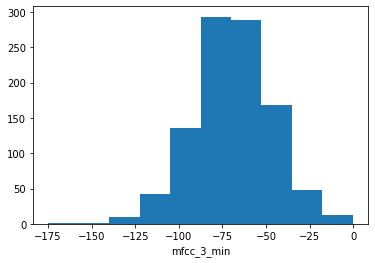

float64


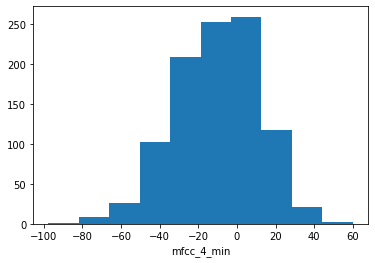

float64


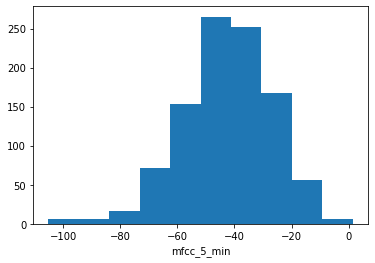

float64


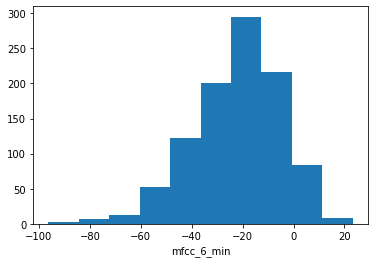

float64


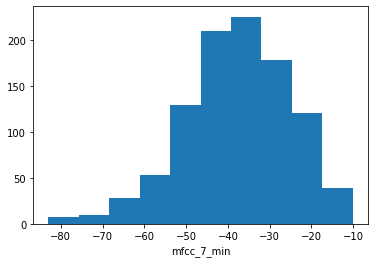

float64


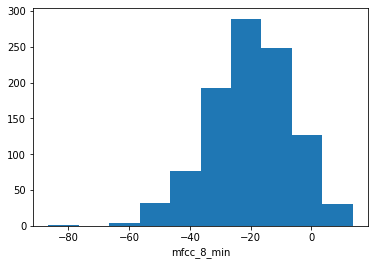

float64


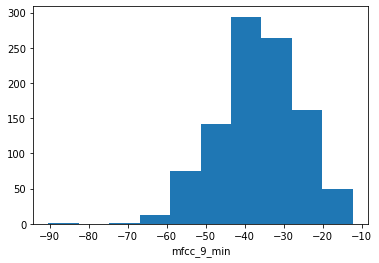

float64


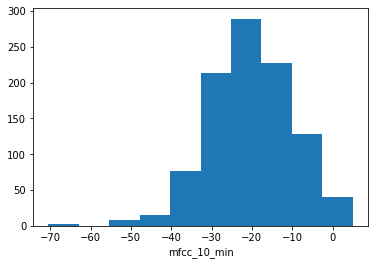

float64


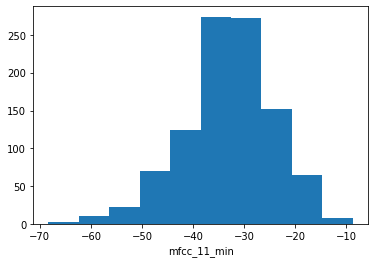

float64


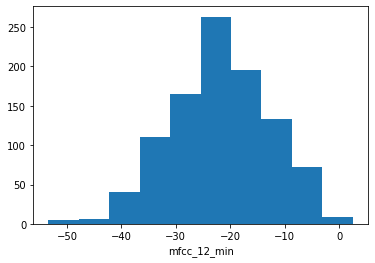

float64


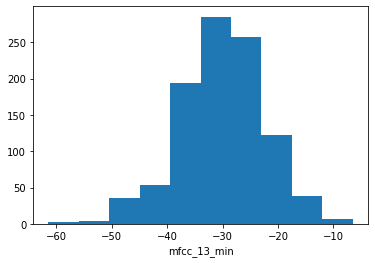

float64


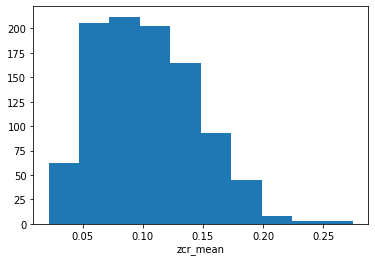

float64


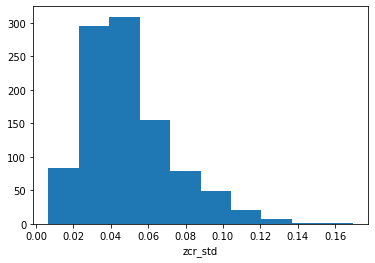

float64


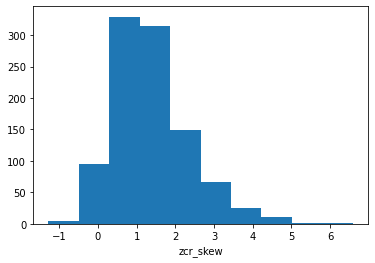

float64


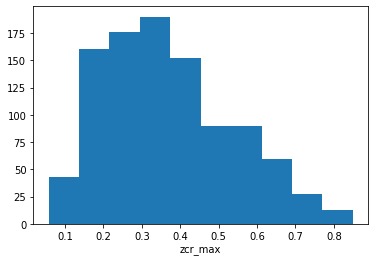

float64


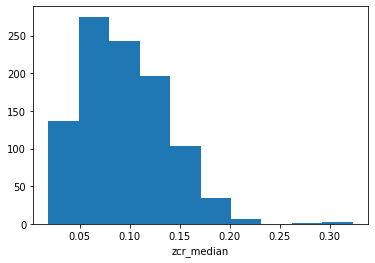

float64


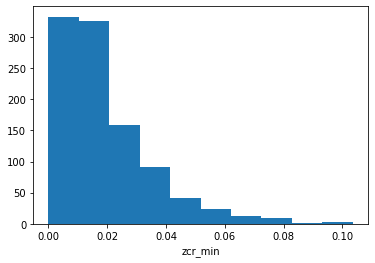

float64


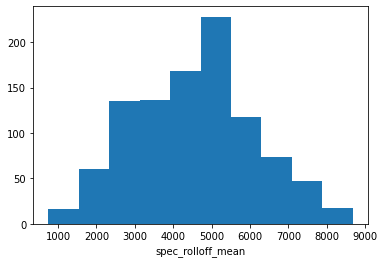

float64


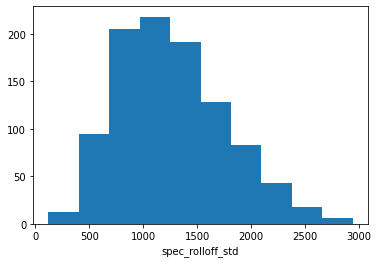

float64


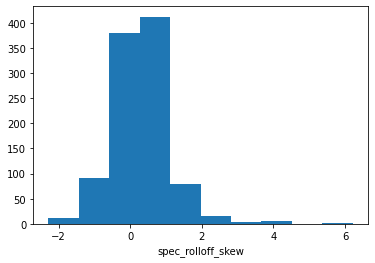

float64


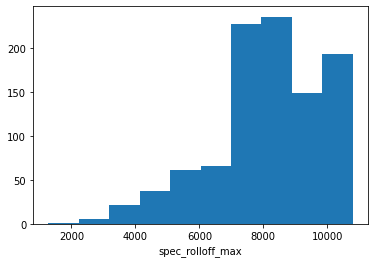

float64


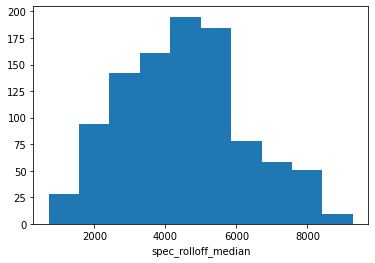

float64


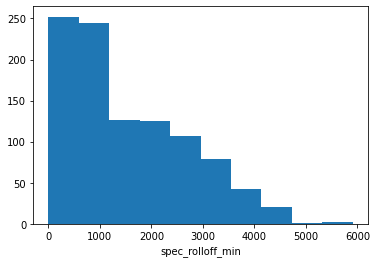

float64


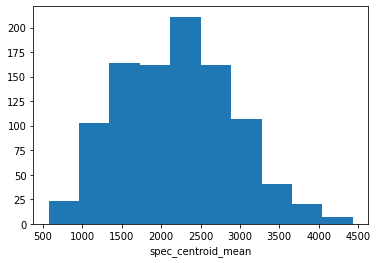

float64


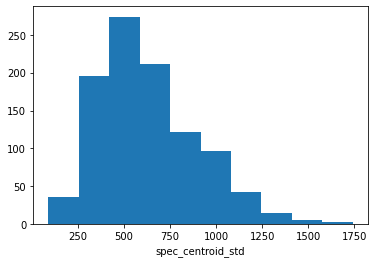

float64


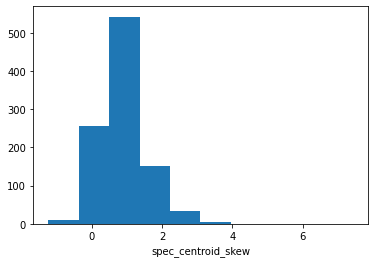

float64


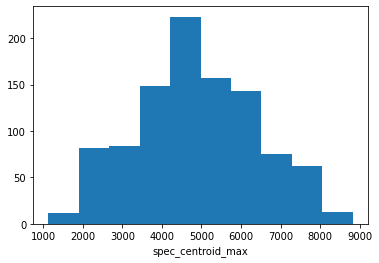

float64


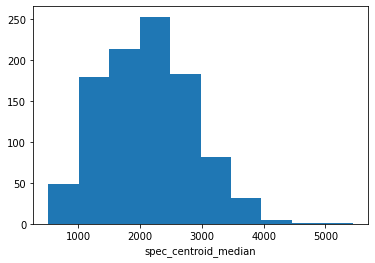

float64


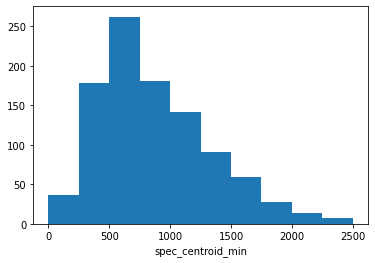

float64


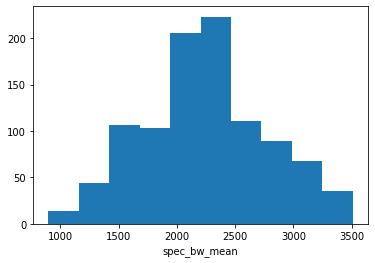

float64


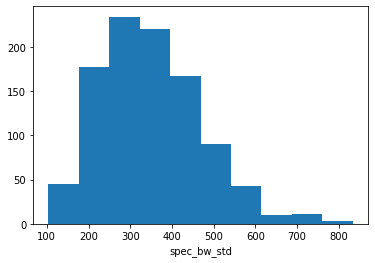

float64


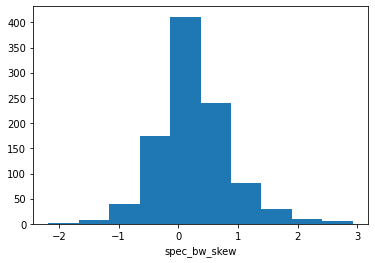

float64


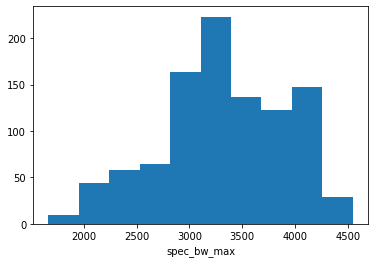

float64


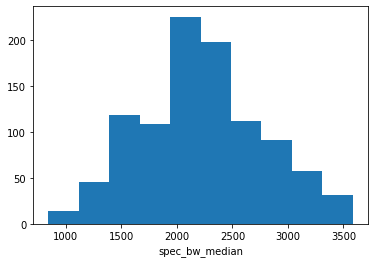

float64


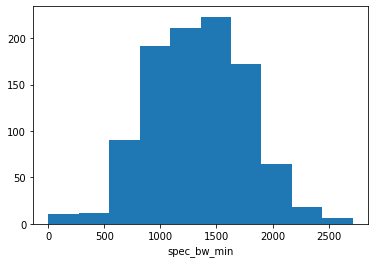

float64


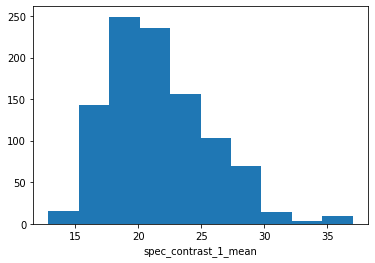

float64


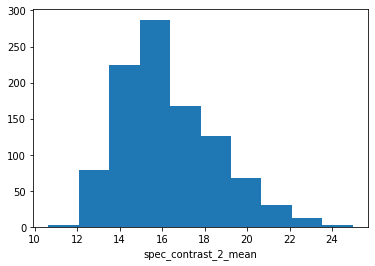

float64


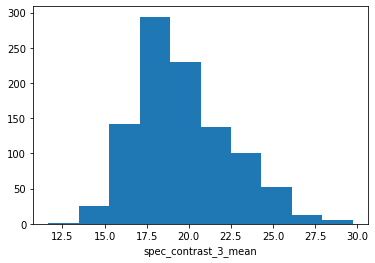

float64


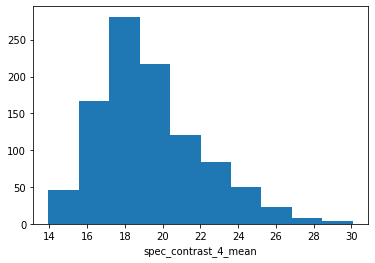

float64


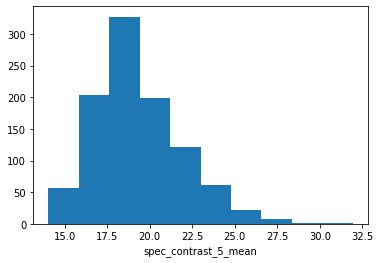

float64


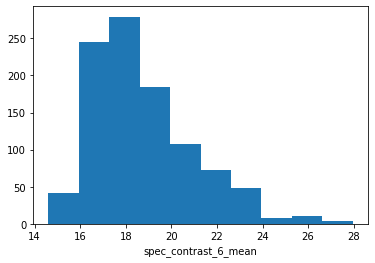

float64


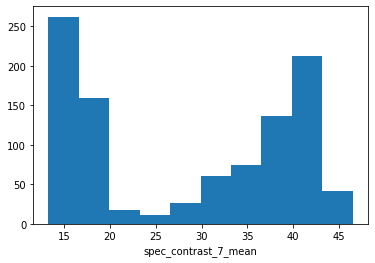

float64


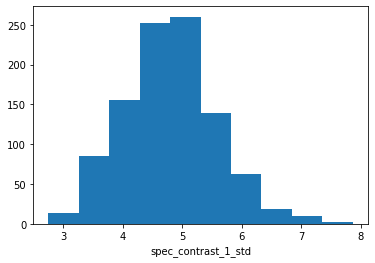

float64


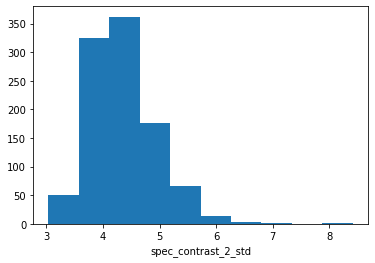

float64


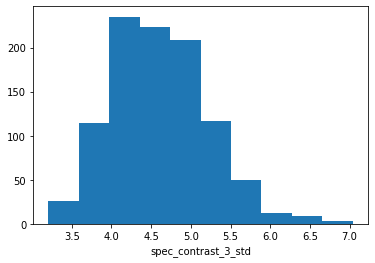

float64


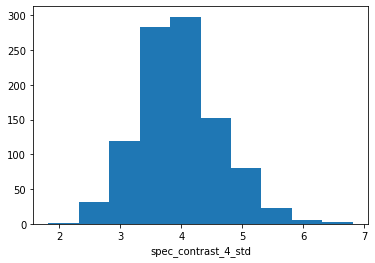

float64


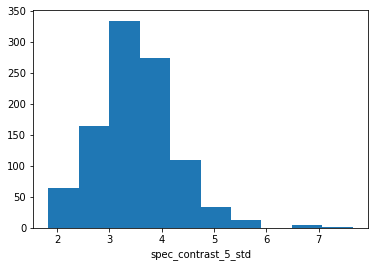

float64


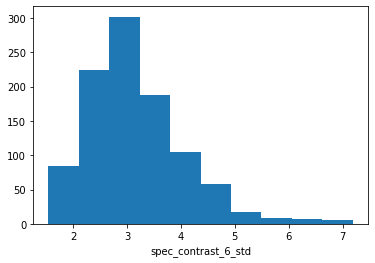

float64


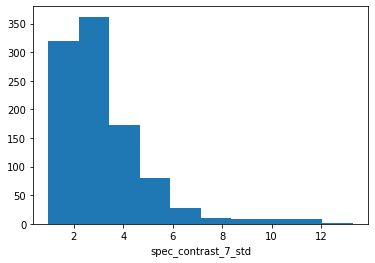

float64


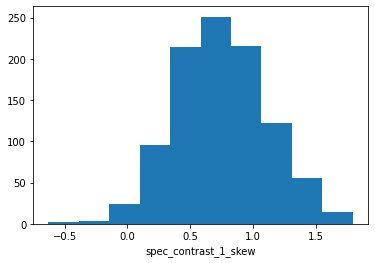

float64


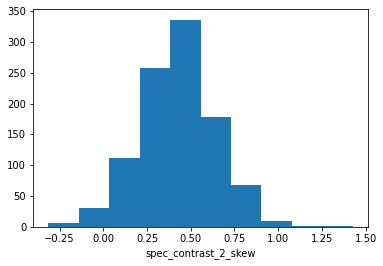

float64


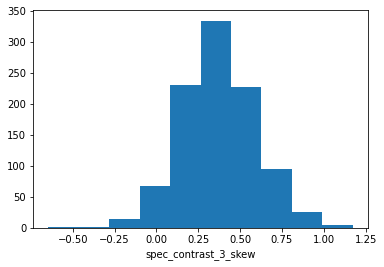

float64


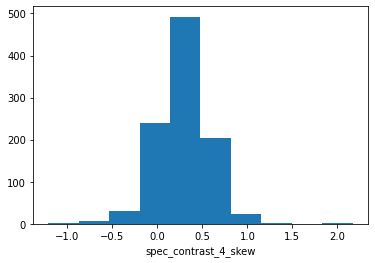

float64


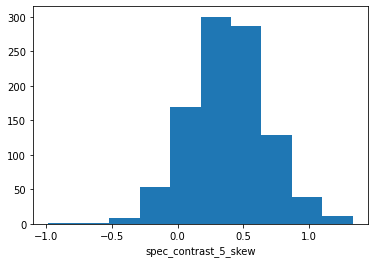

float64


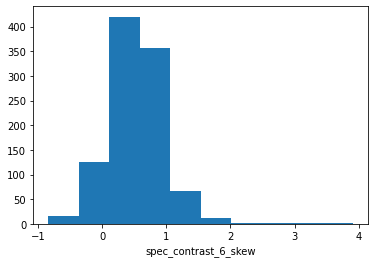

float64


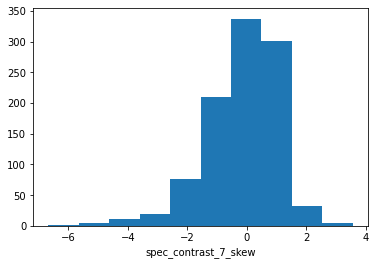

float64


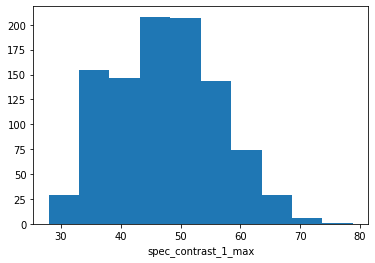

float64


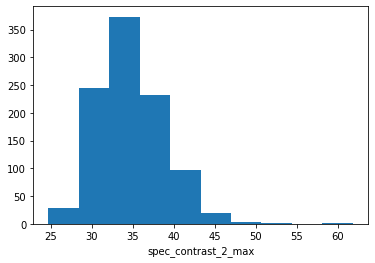

float64


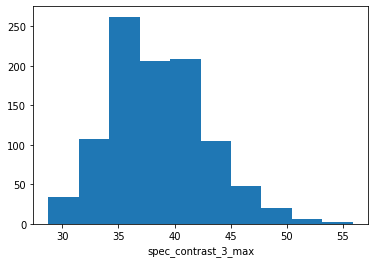

float64


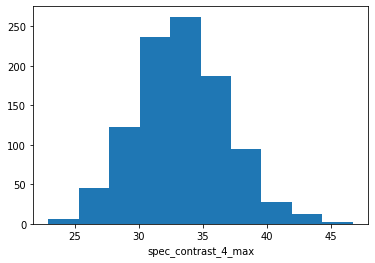

float64


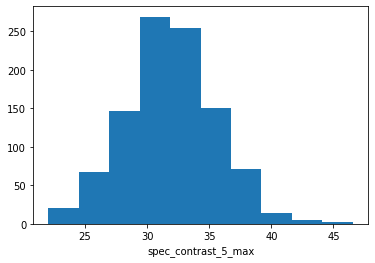

float64


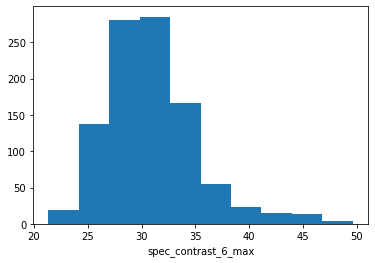

float64


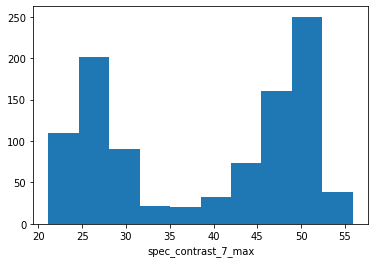

float64


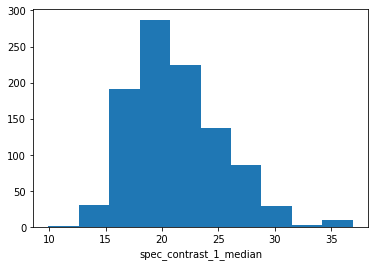

float64


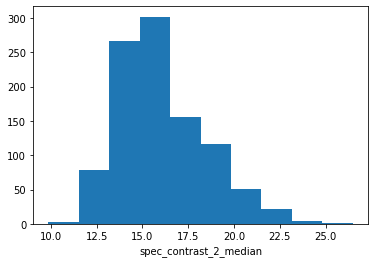

float64


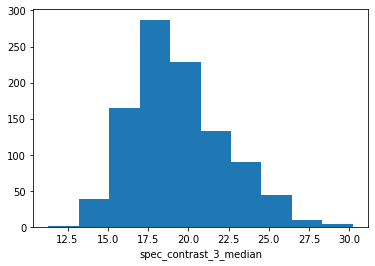

float64


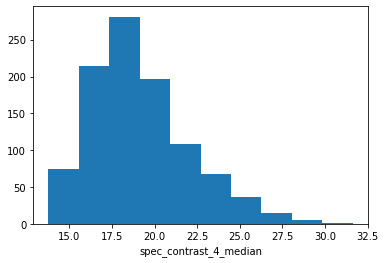

float64


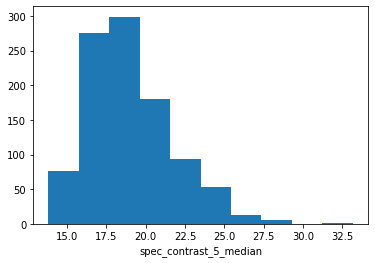

float64


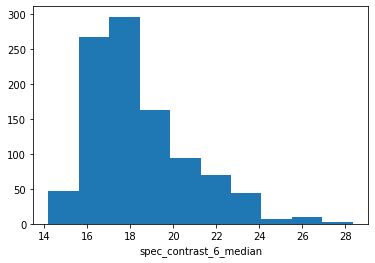

float64


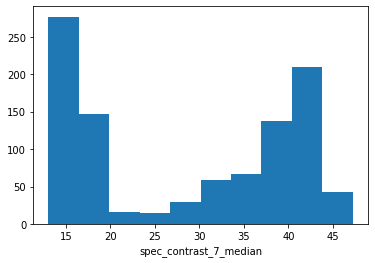

float64


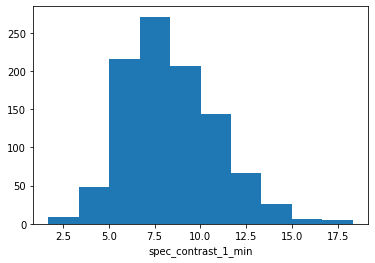

float64


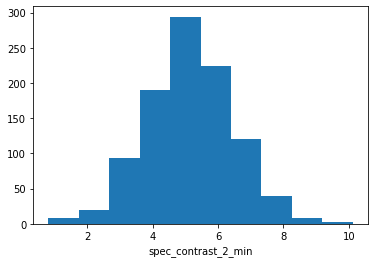

float64


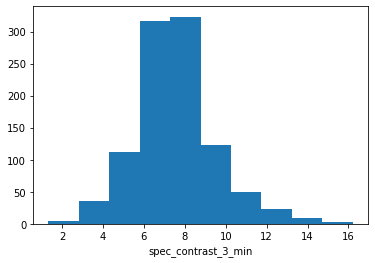

float64


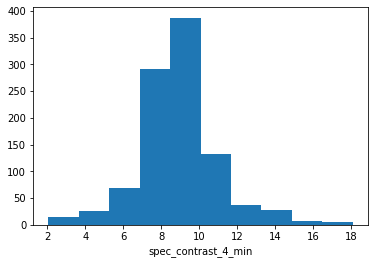

float64


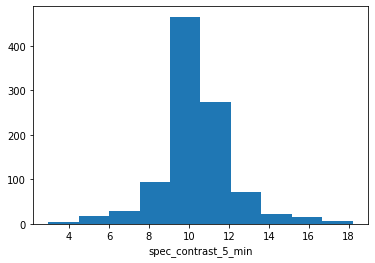

float64


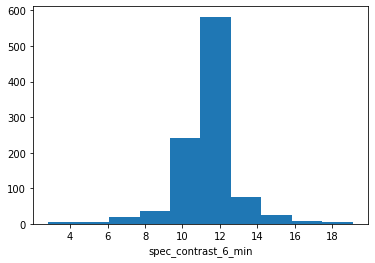

float64


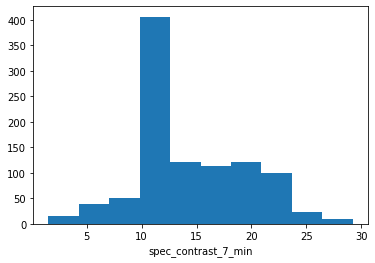

float64


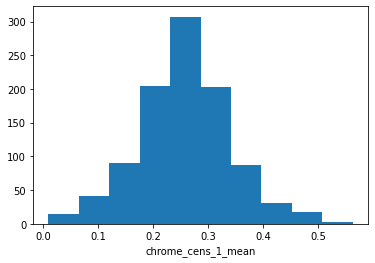

float64


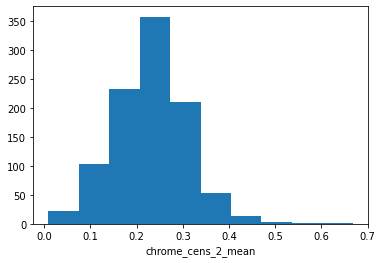

float64


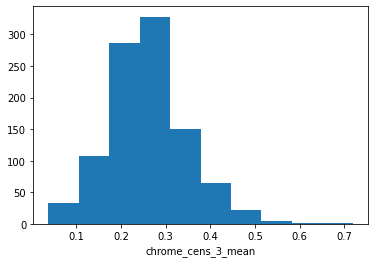

float64


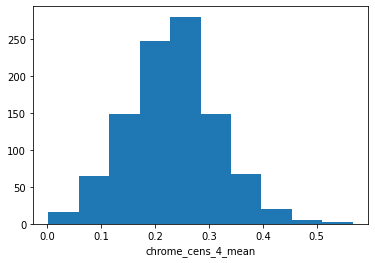

float64


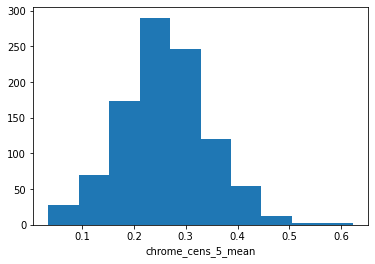

float64


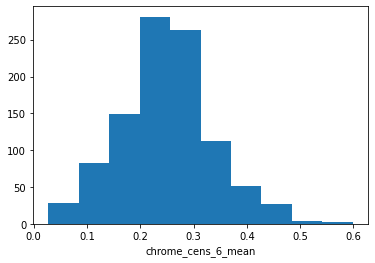

float64


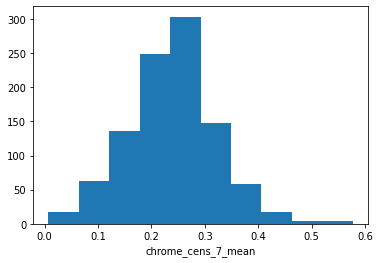

float64


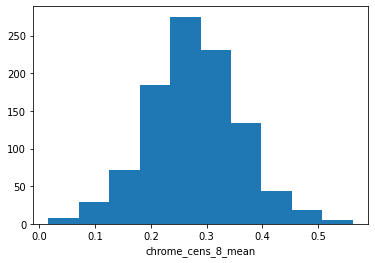

float64


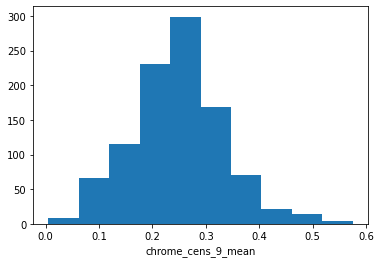

float64


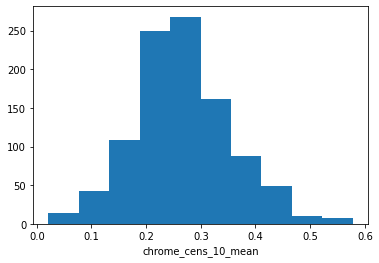

float64


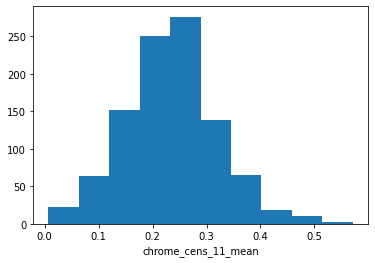

float64


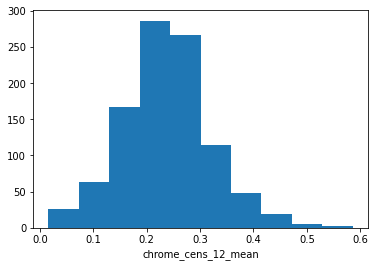

float64


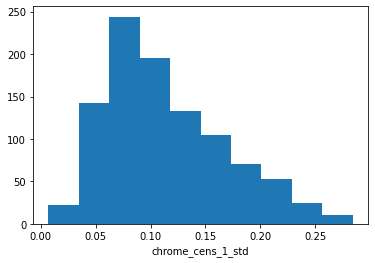

float64


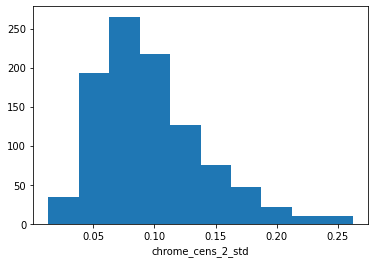

float64


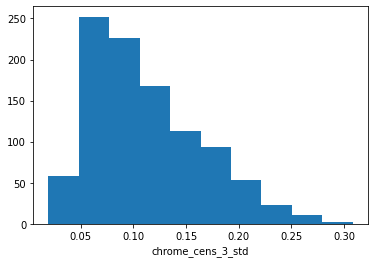

float64


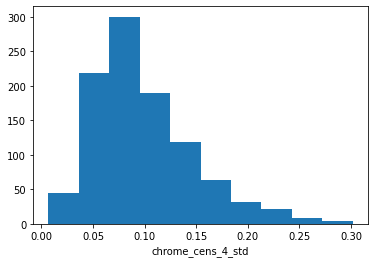

float64


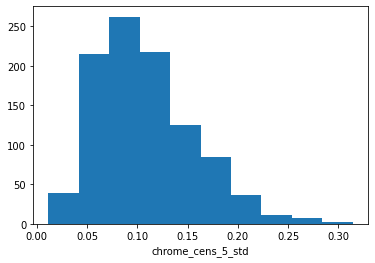

float64


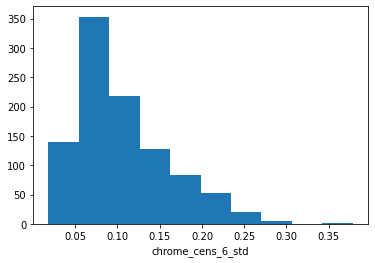

float64


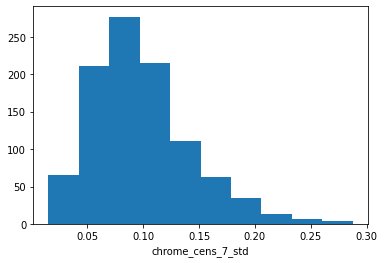

float64


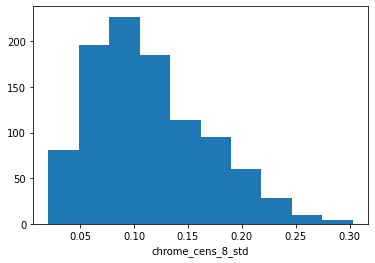

float64


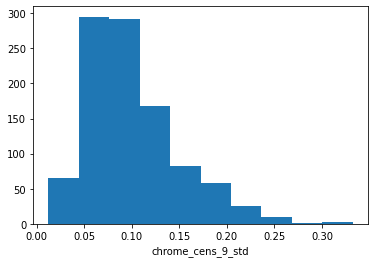

float64


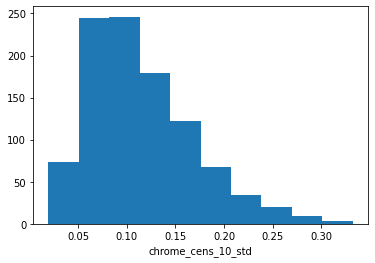

float64


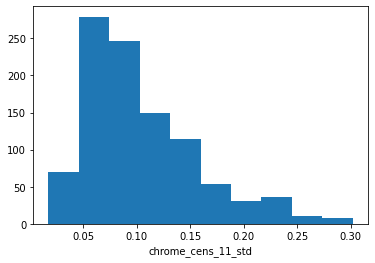

float64


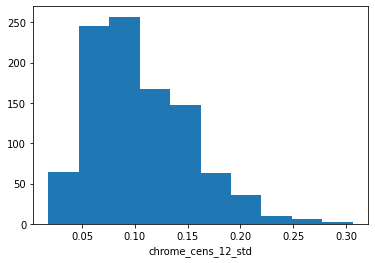

float64


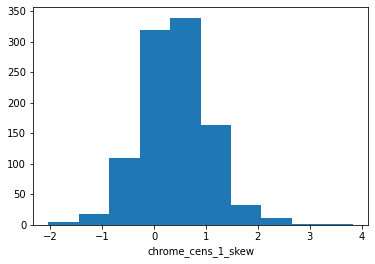

float64


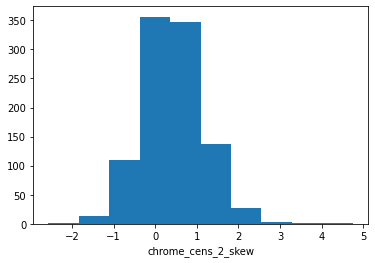

float64


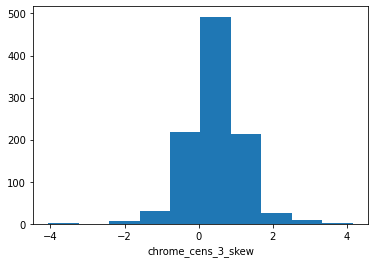

float64


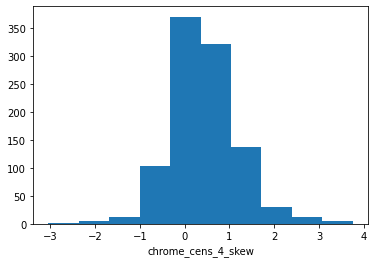

float64


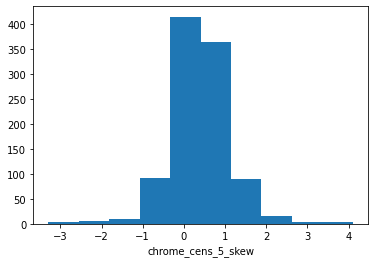

float64


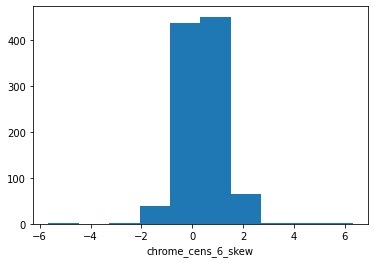

float64


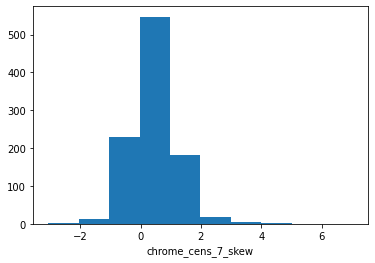

float64


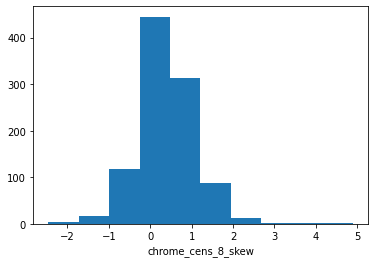

float64


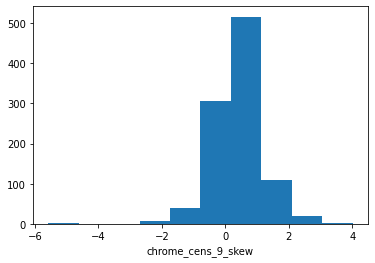

float64


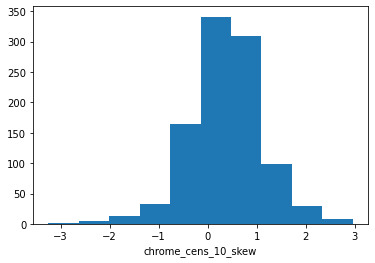

float64


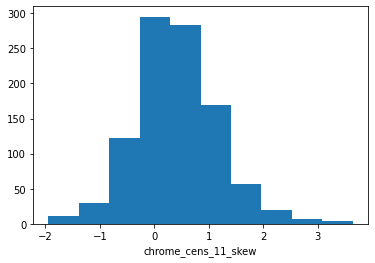

float64


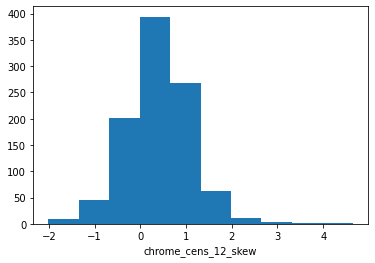

float64


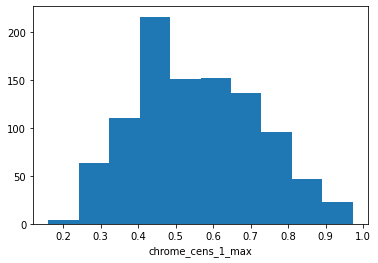

float64


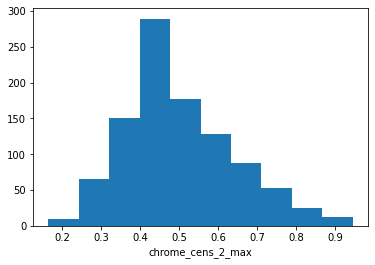

float64


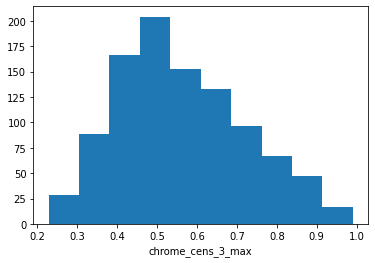

float64


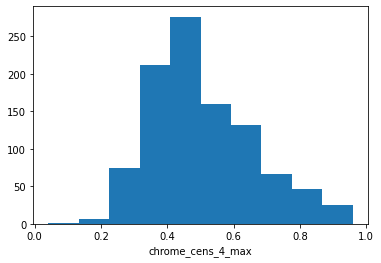

float64


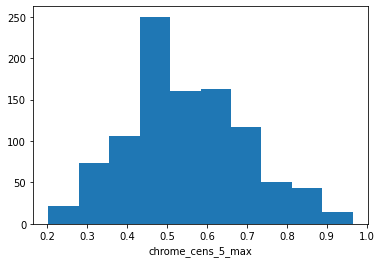

float64


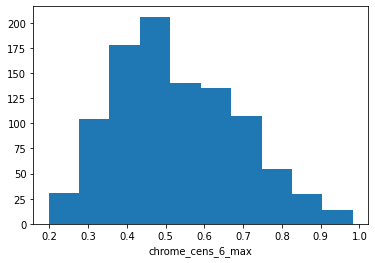

float64


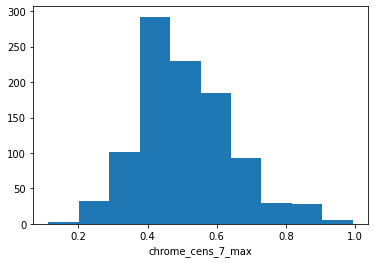

float64


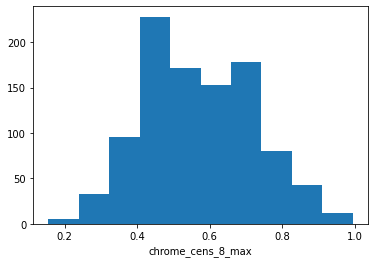

float64


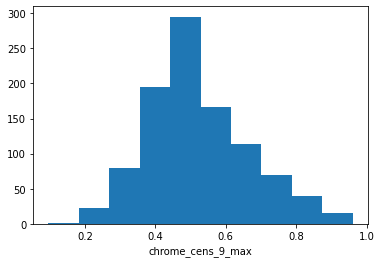

float64


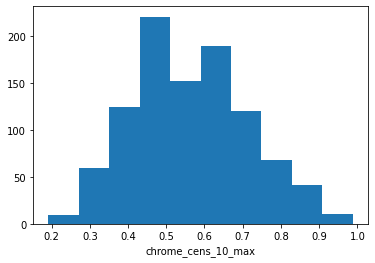

float64


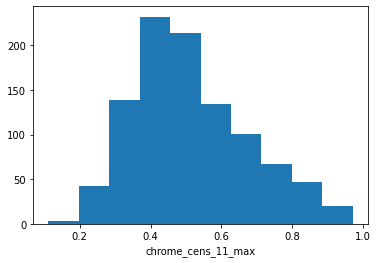

float64


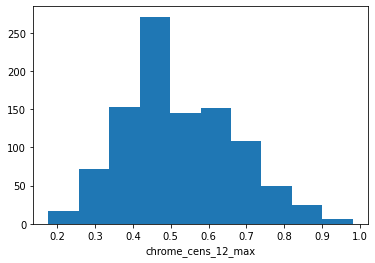

float64


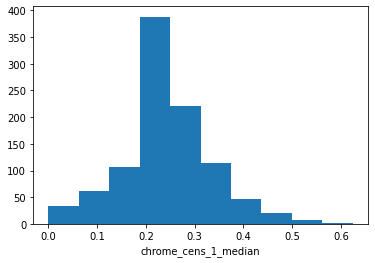

float64


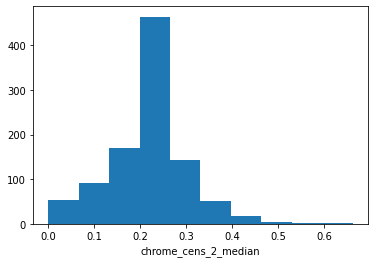

float64


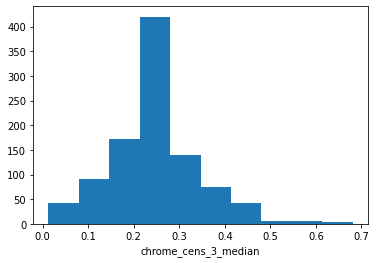

float64


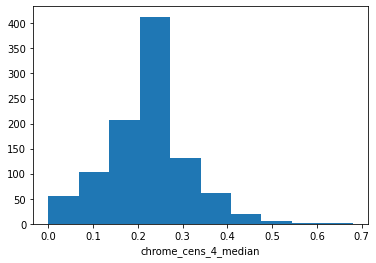

float64


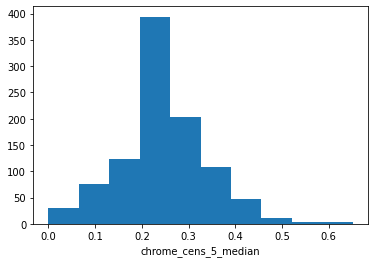

float64


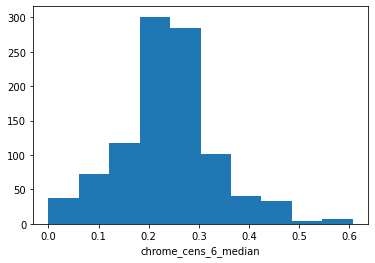

float64


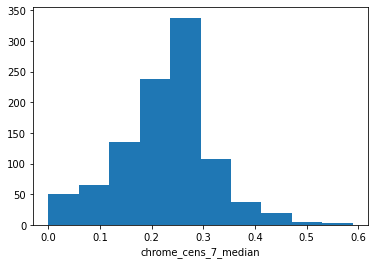

float64


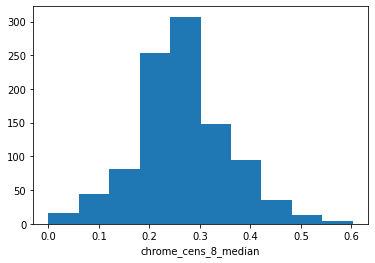

float64


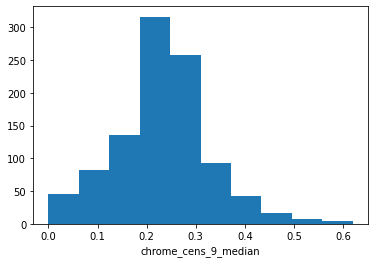

float64


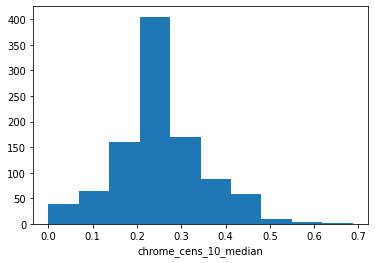

float64


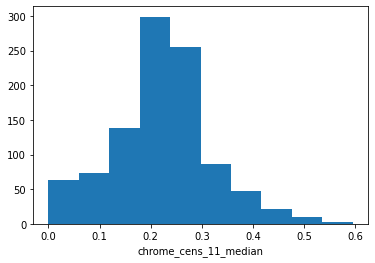

float64


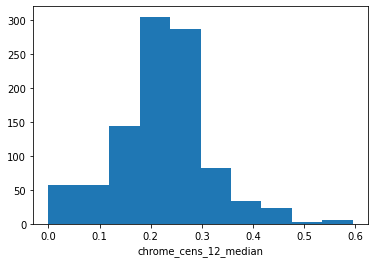

float64


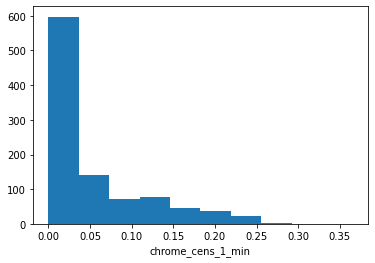

float64


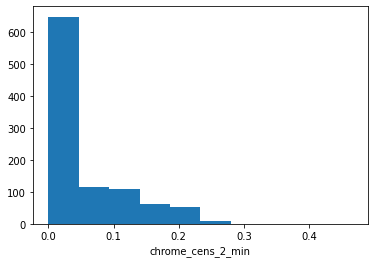

float64


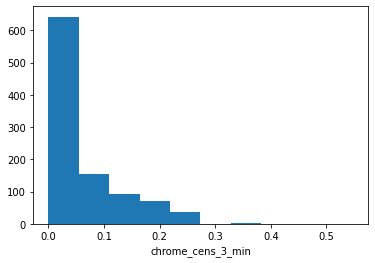

float64


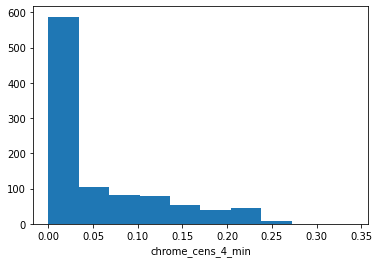

float64


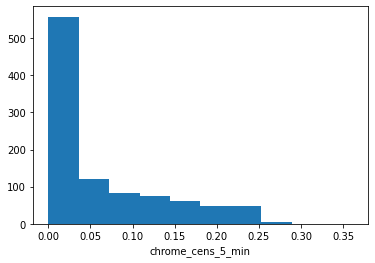

float64


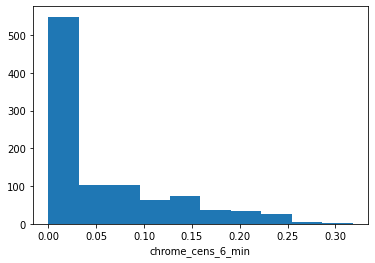

float64


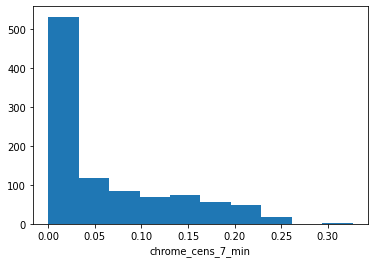

float64


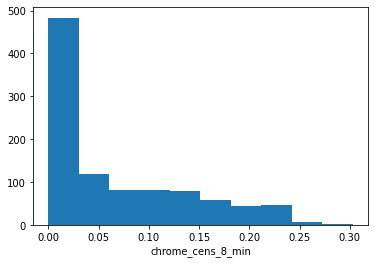

float64


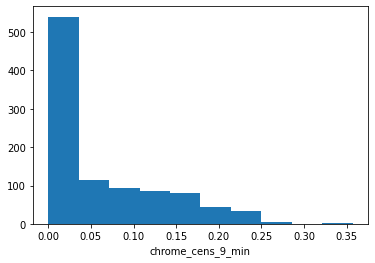

float64


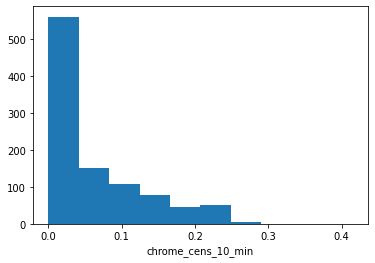

float64


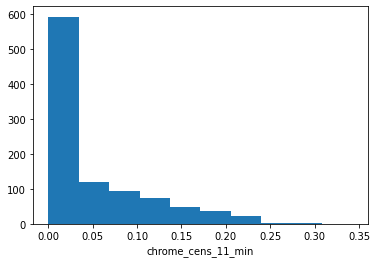

float64


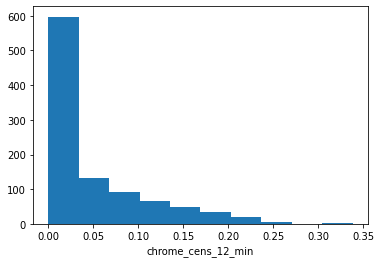

In [ ]:
plotAllHist(df_audio)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly cl

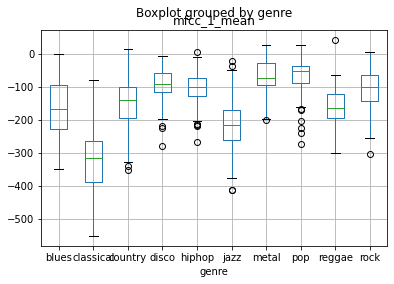

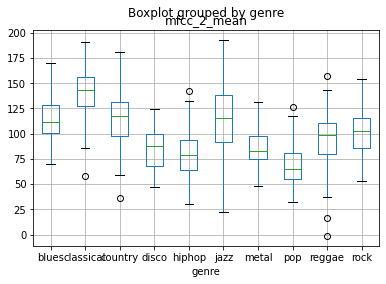

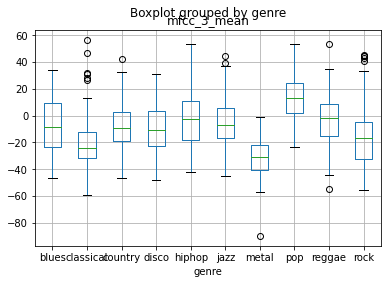

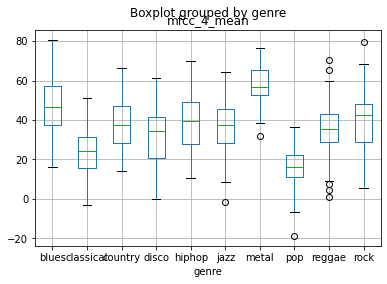

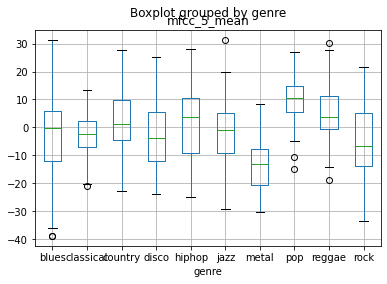

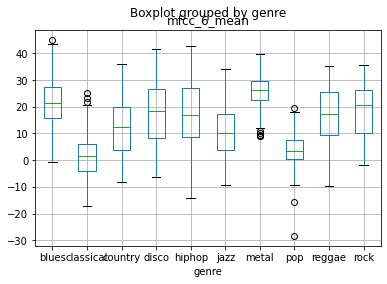

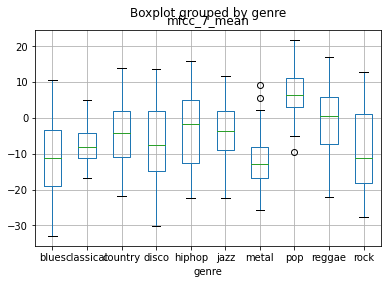

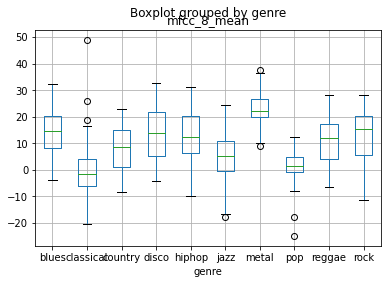

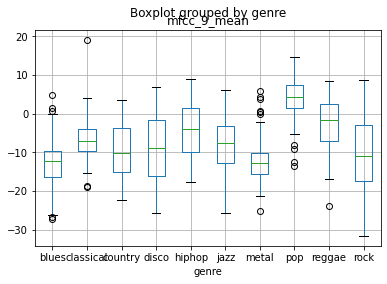

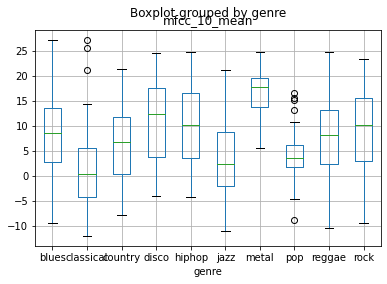

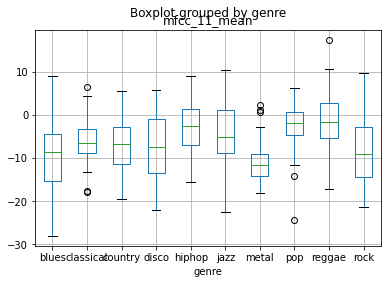

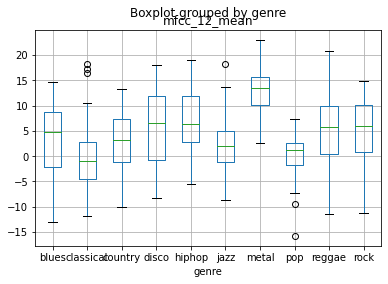

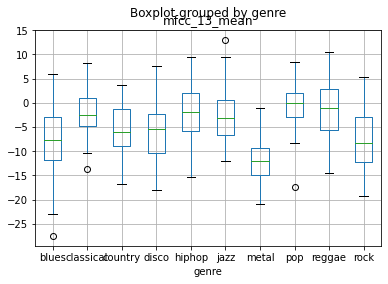

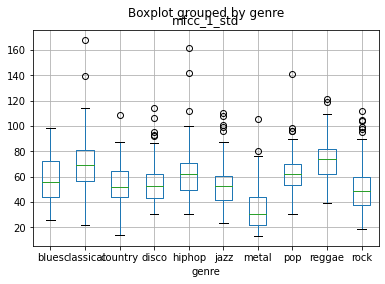

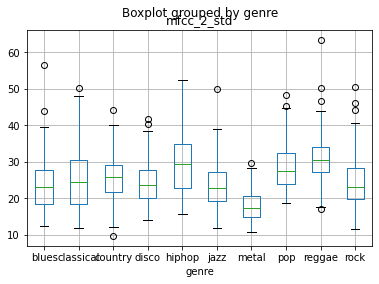

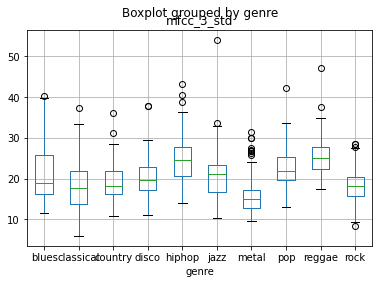

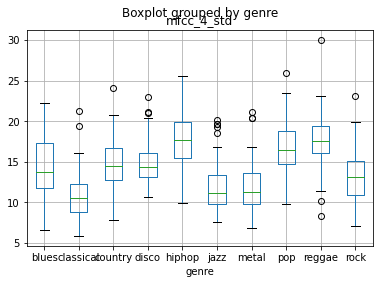

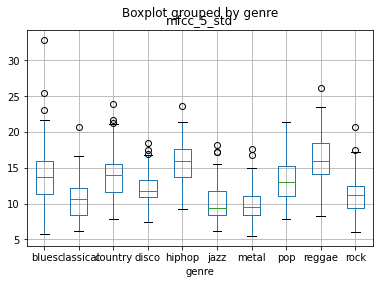

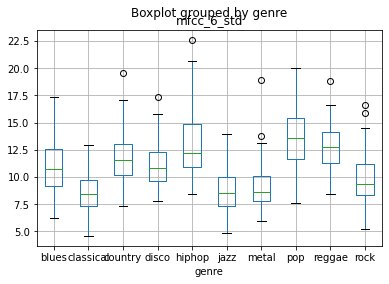

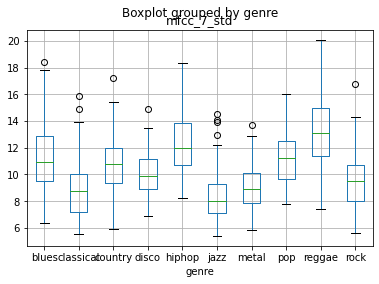

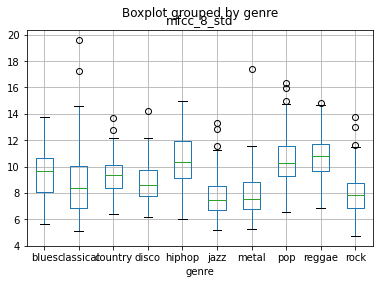

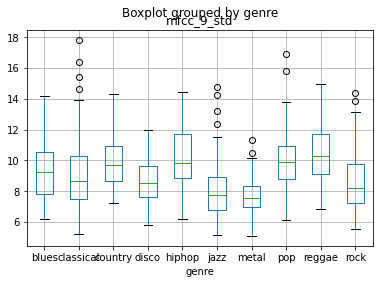

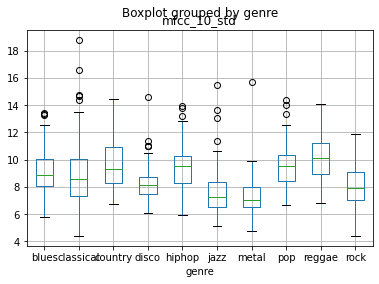

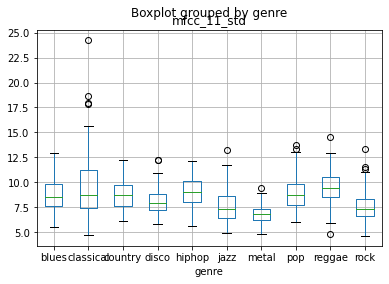

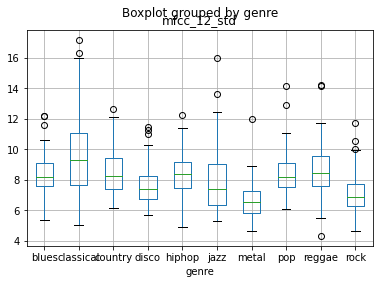

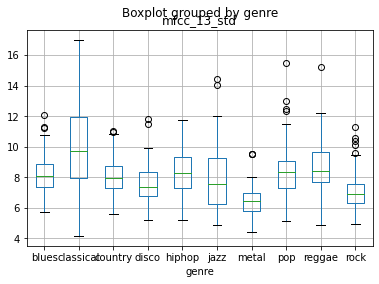

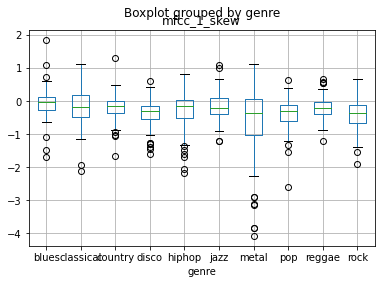

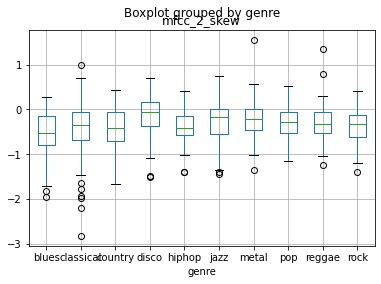

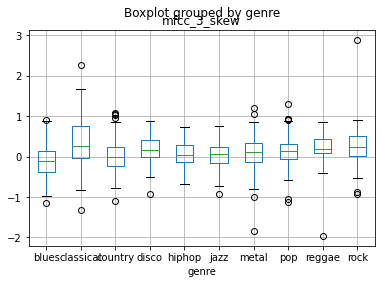

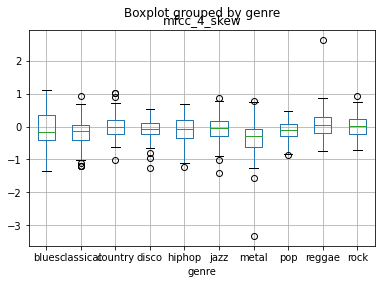

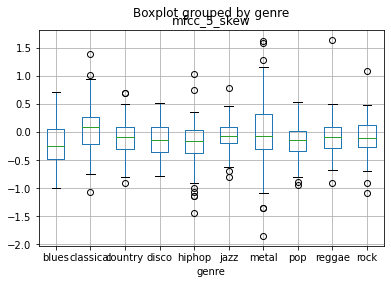

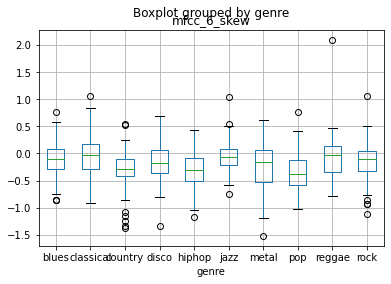

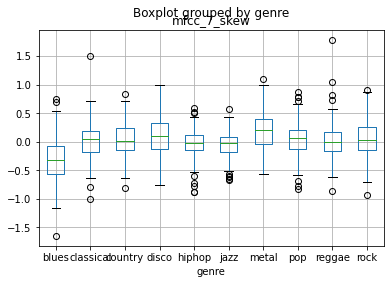

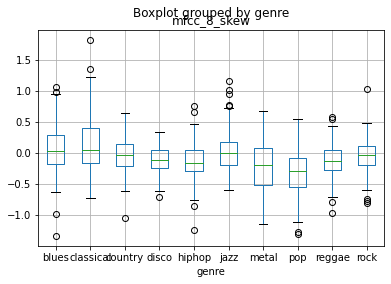

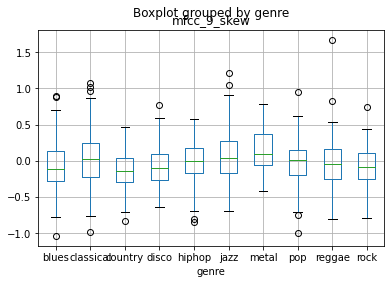

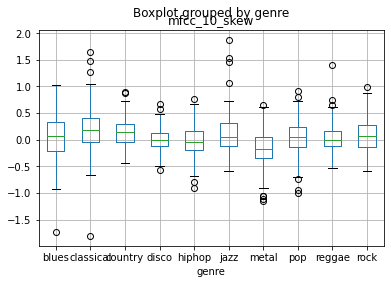

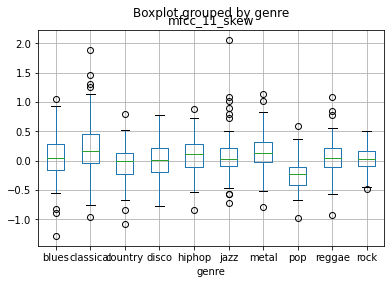

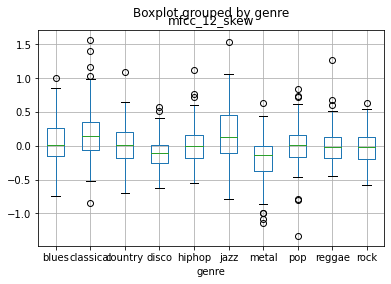

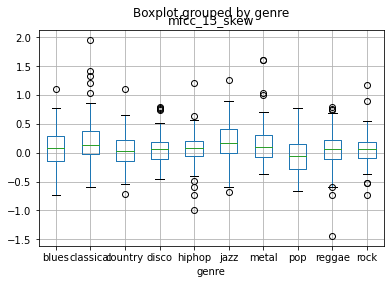

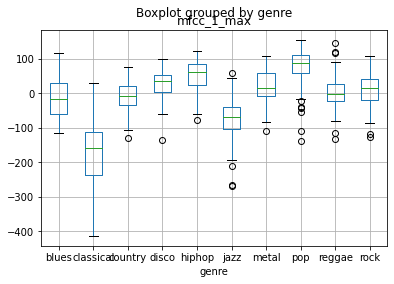

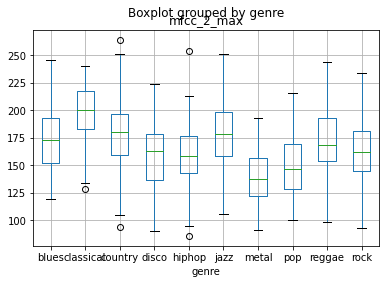

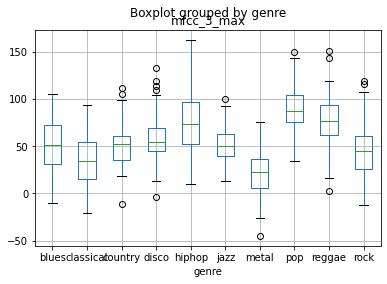

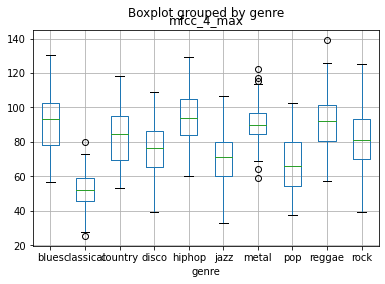

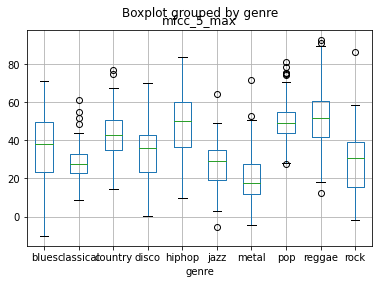

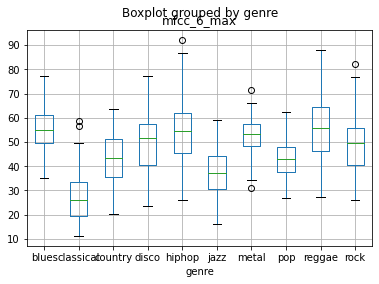

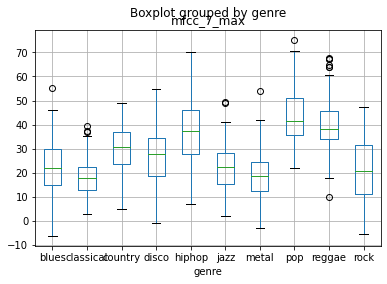

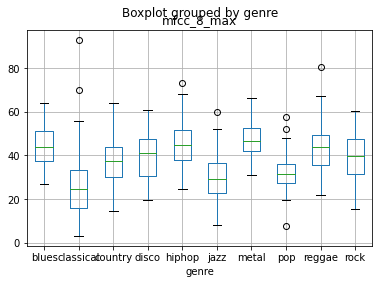

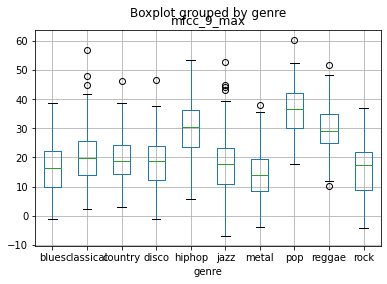

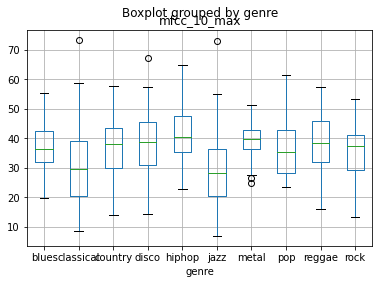

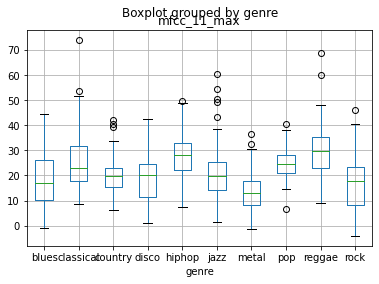

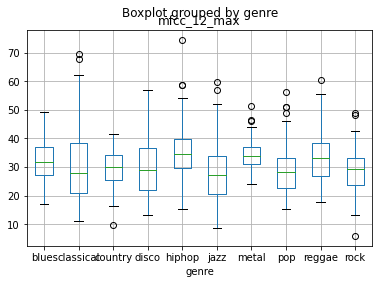

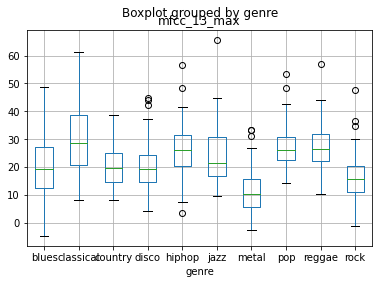

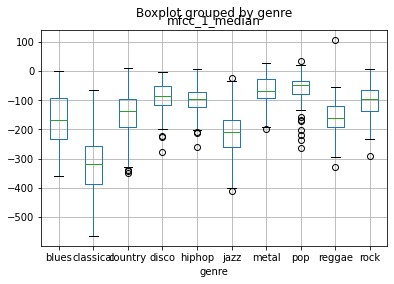

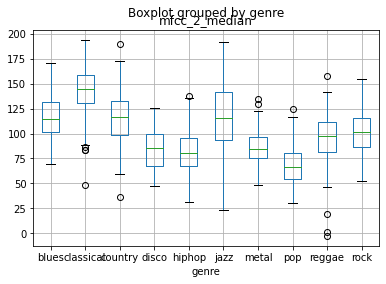

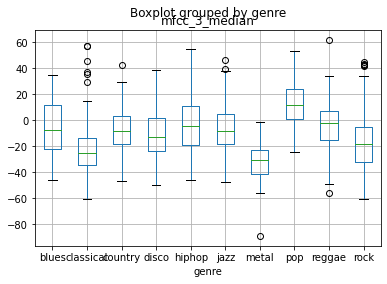

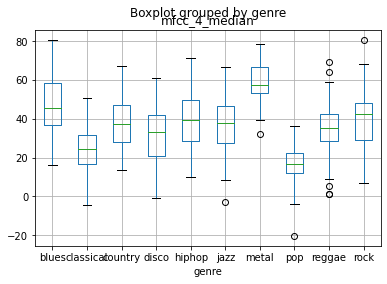

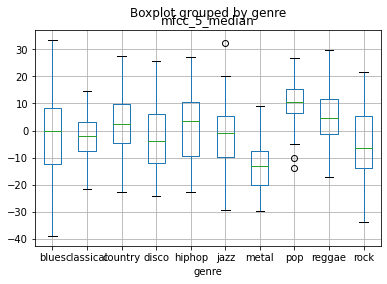

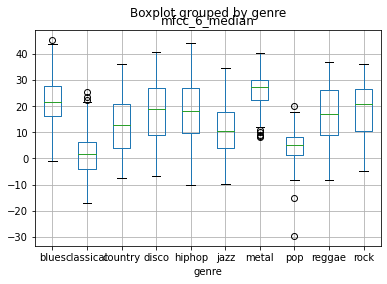

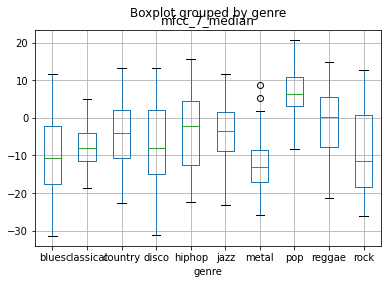

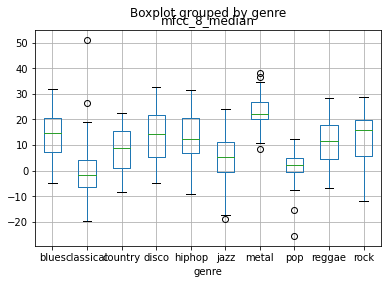

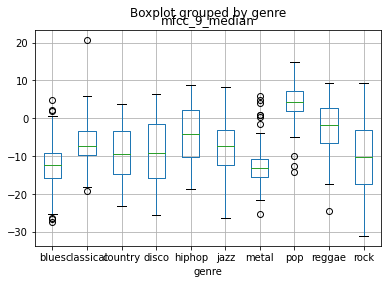

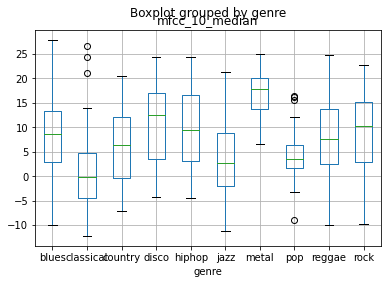

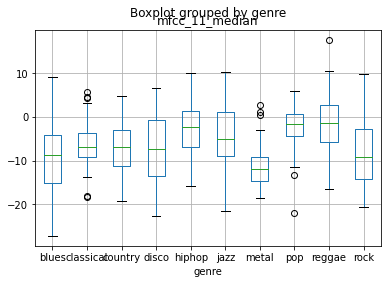

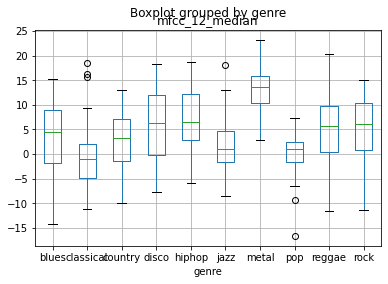

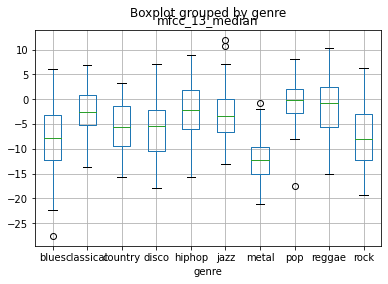

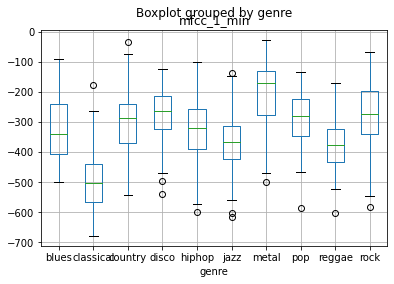

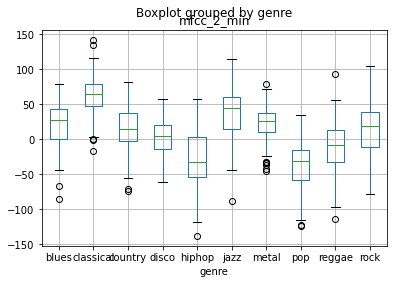

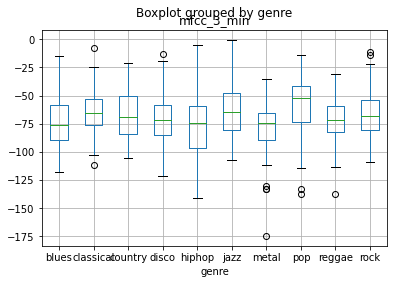

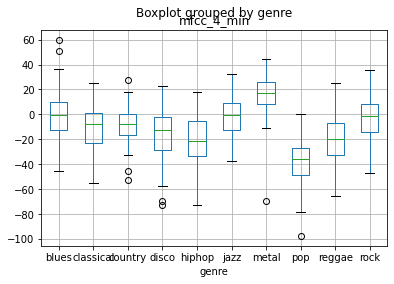

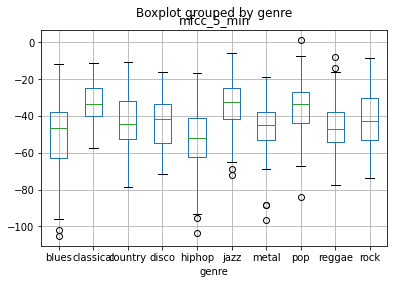

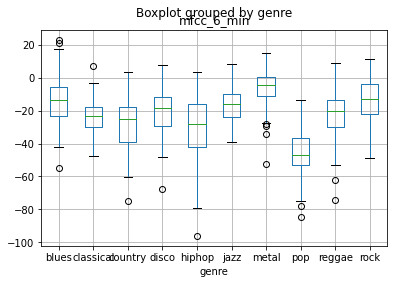

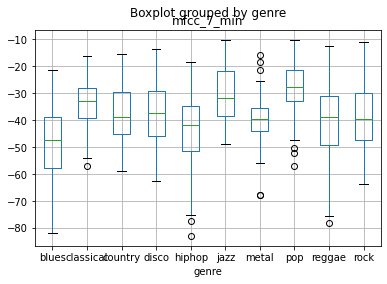

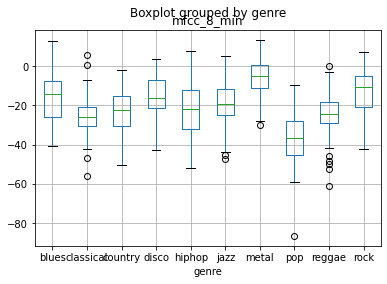

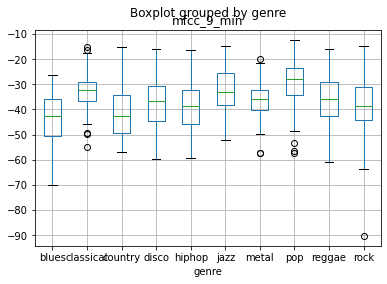

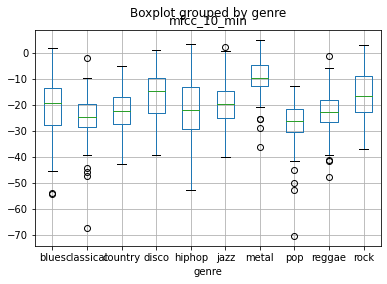

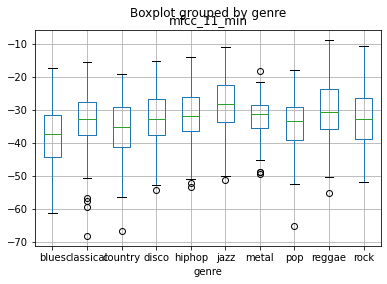

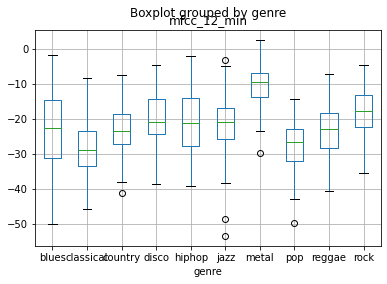

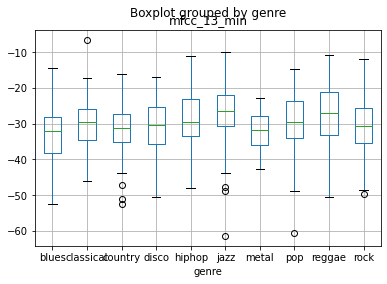

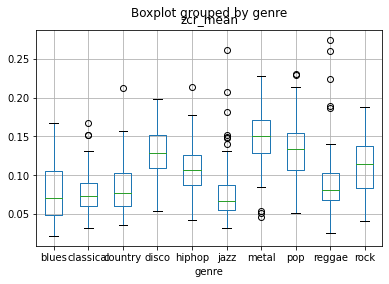

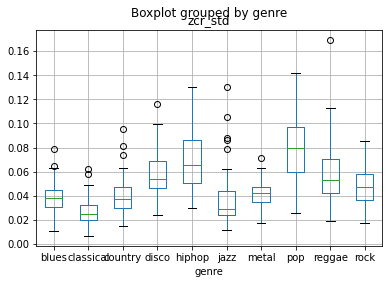

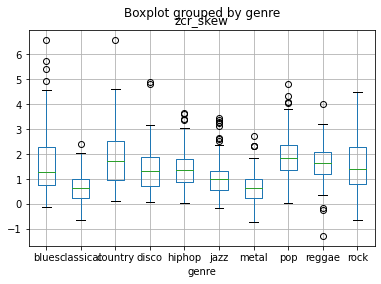

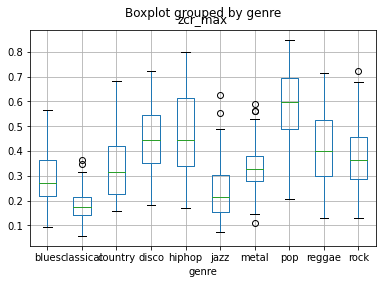

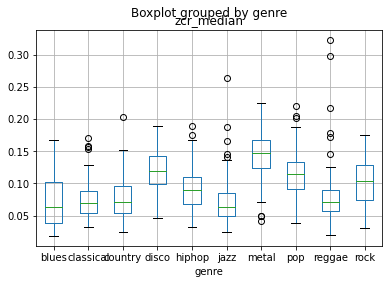

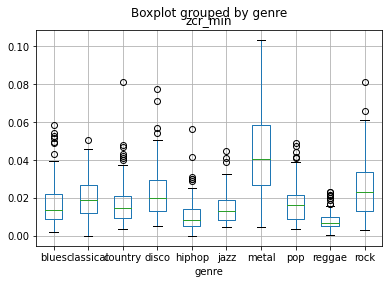

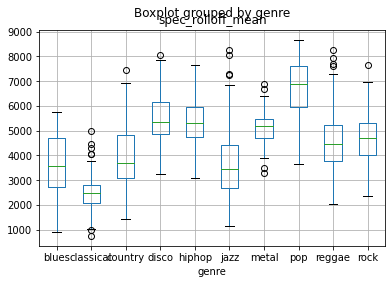

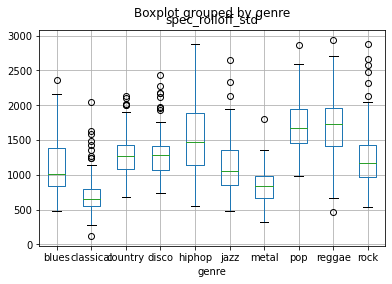

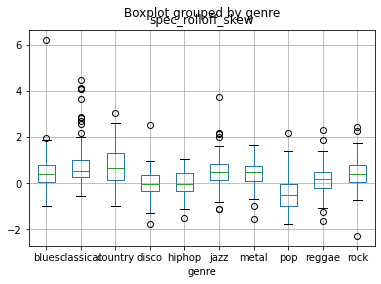

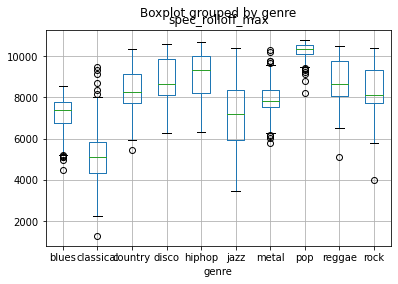

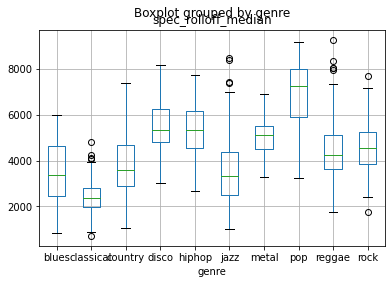

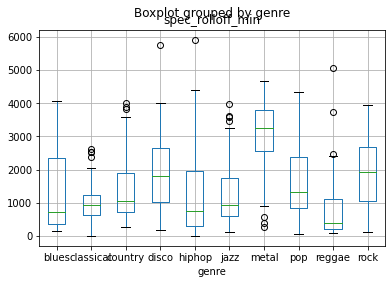

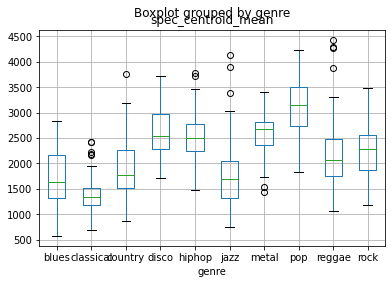

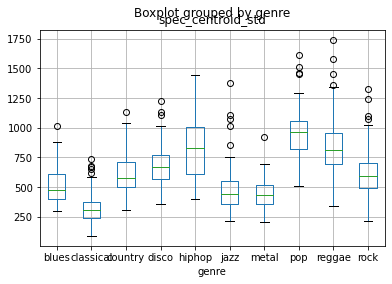

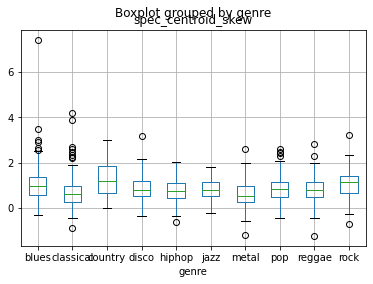

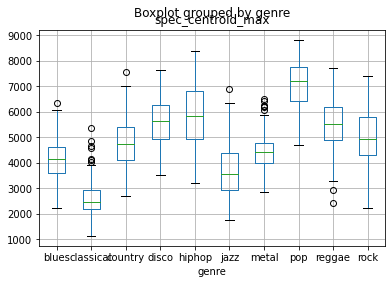

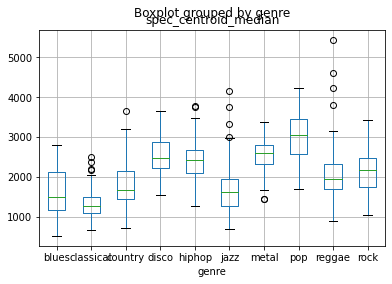

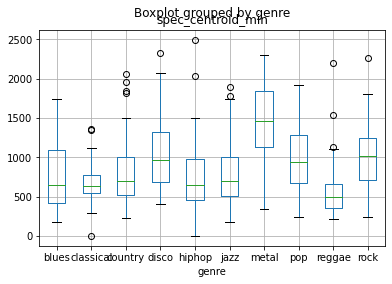

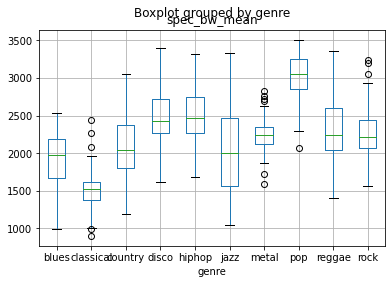

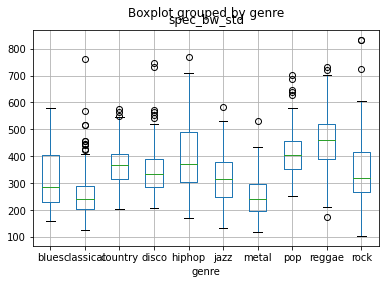

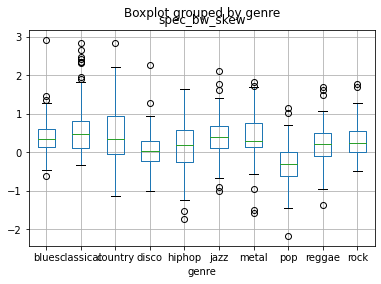

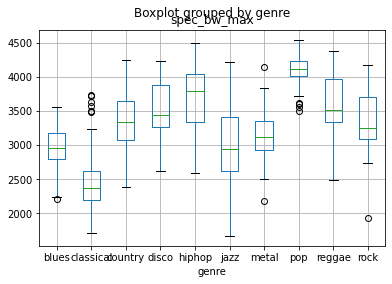

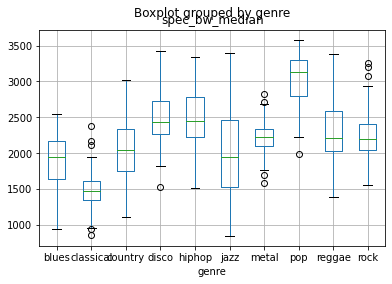

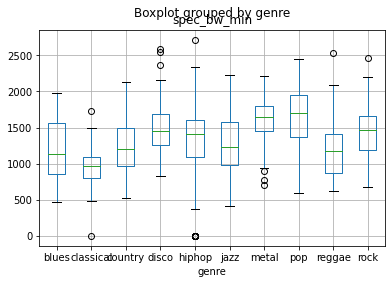

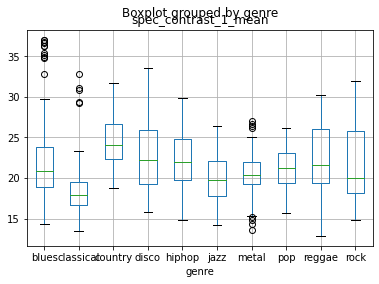

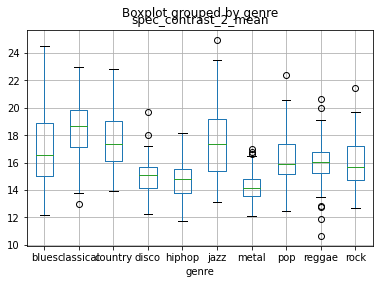

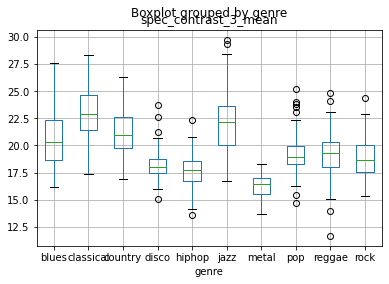

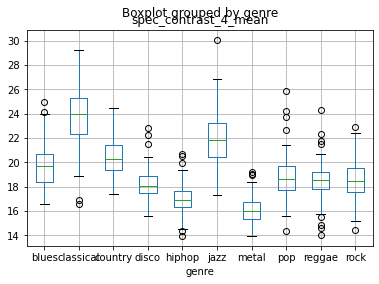

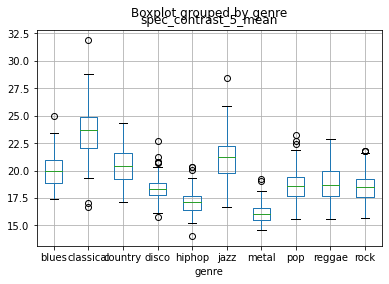

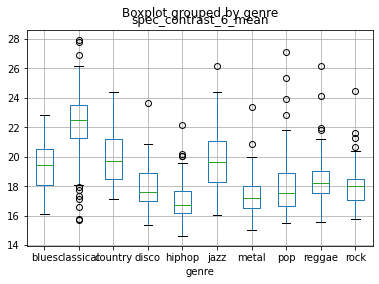

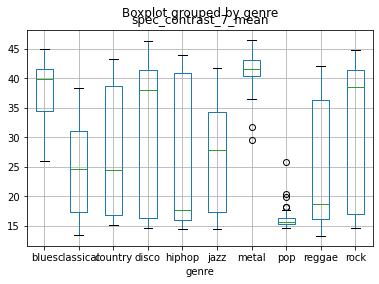

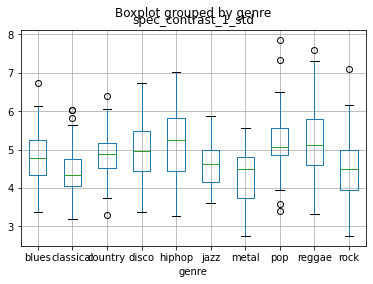

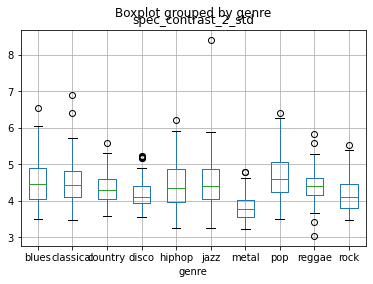

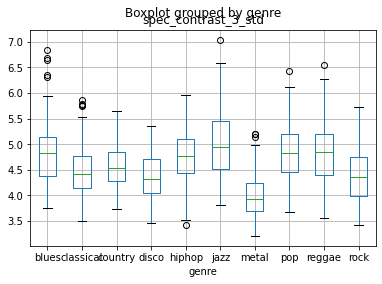

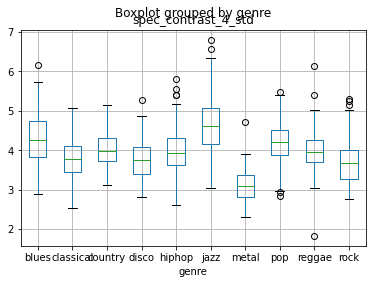

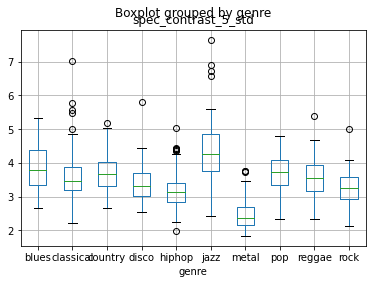

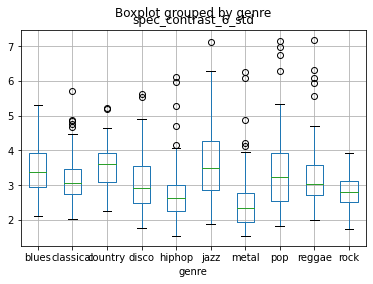

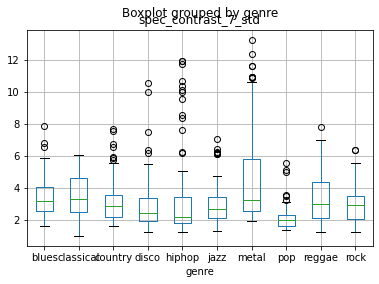

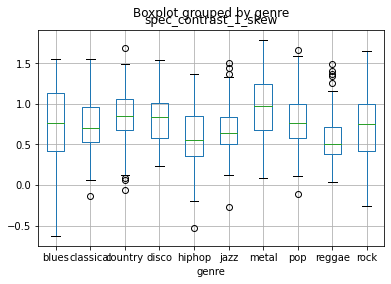

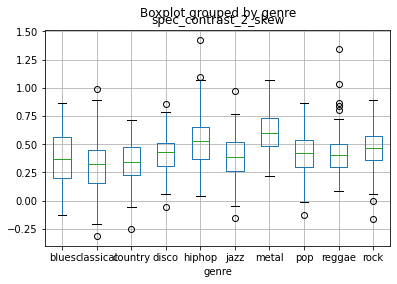

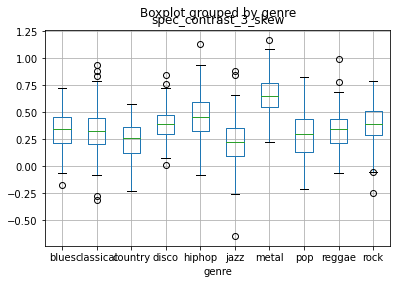

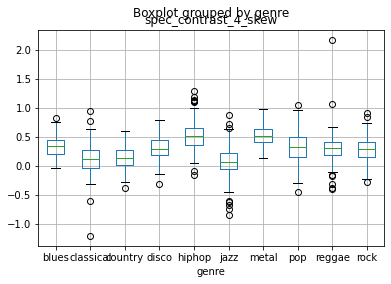

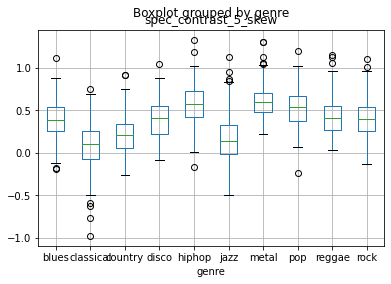

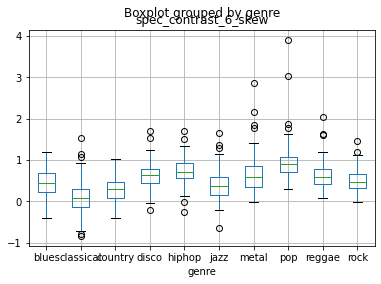

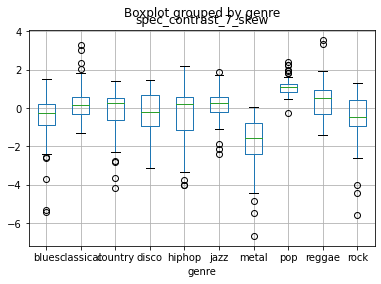

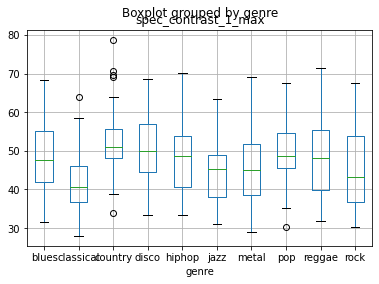

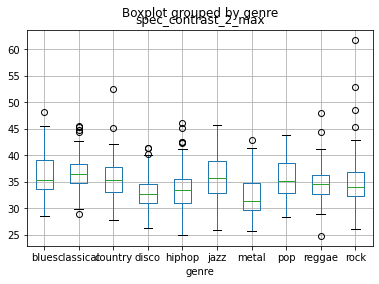

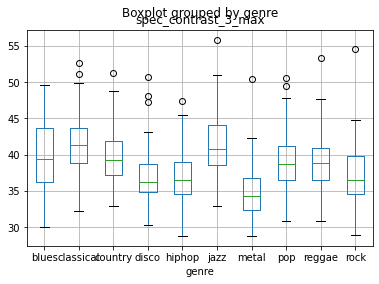

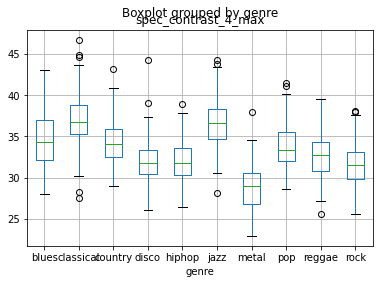

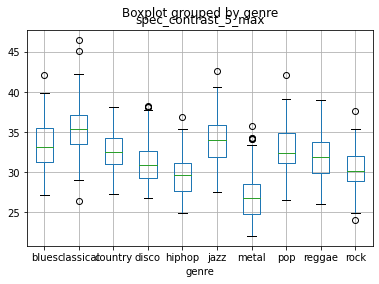

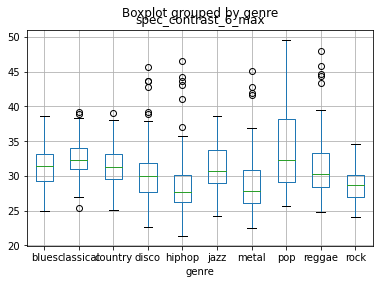

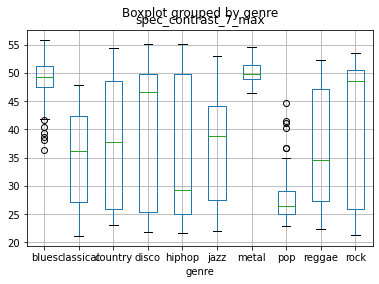

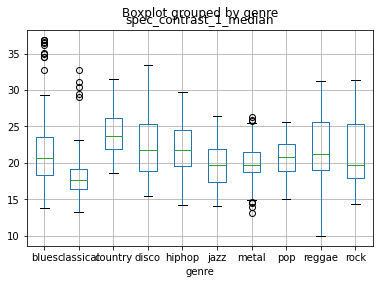

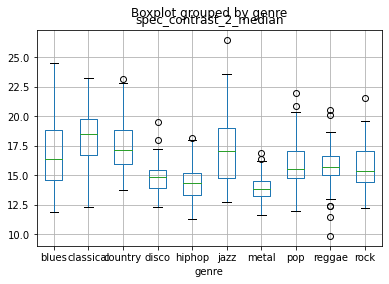

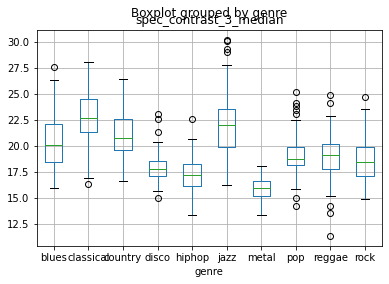

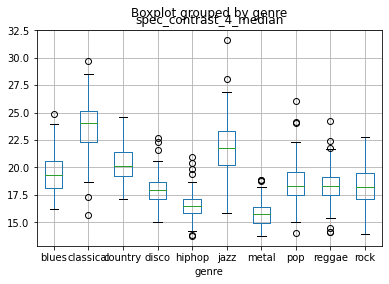

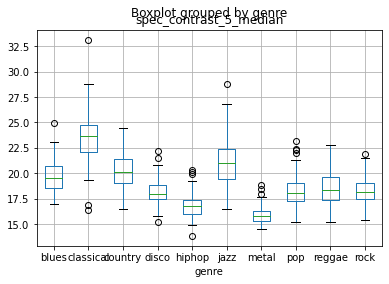

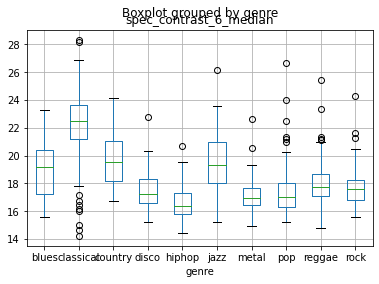

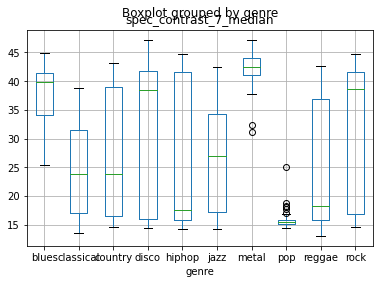

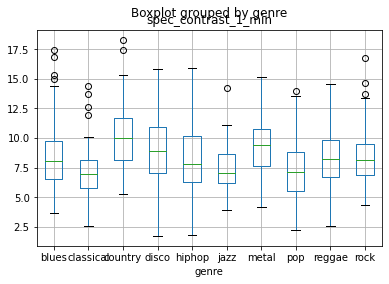

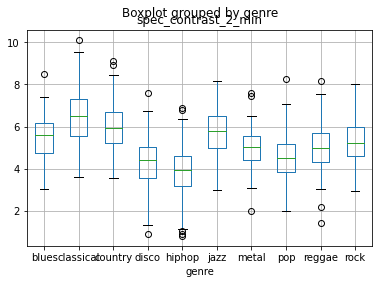

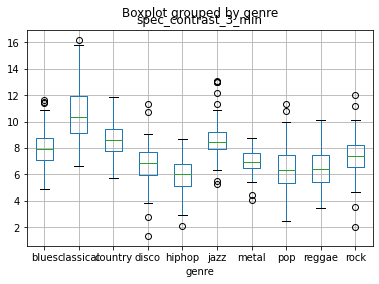

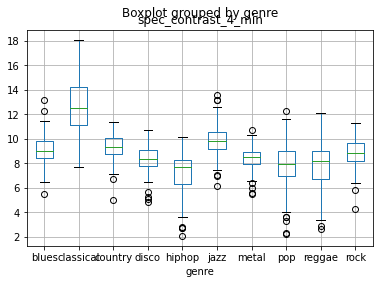

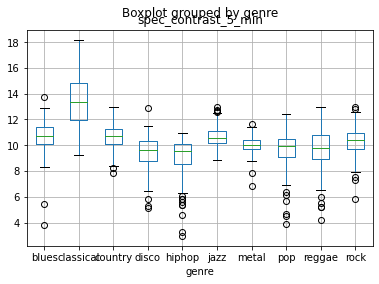

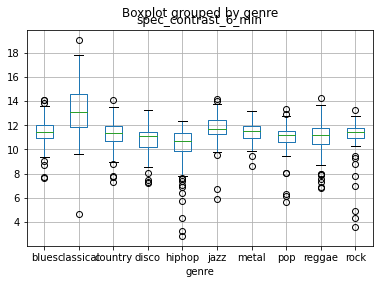

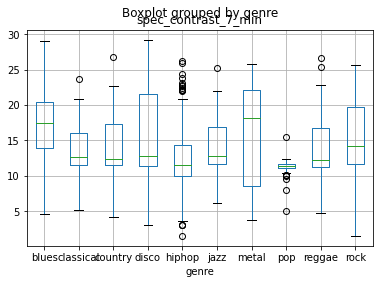

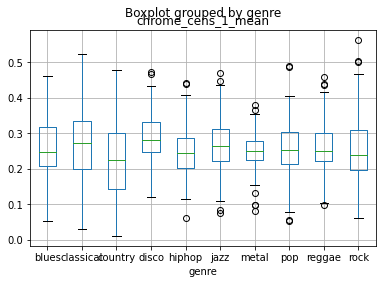

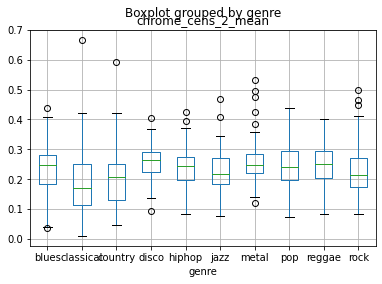

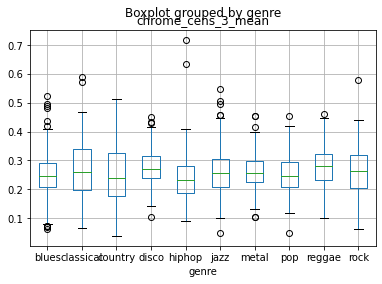

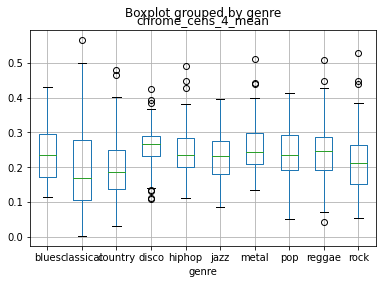

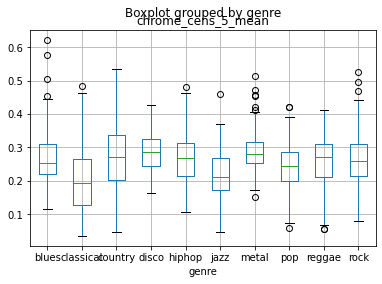

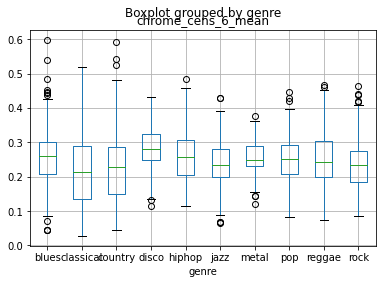

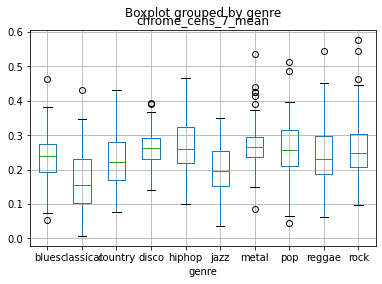

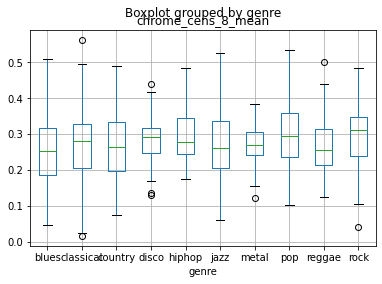

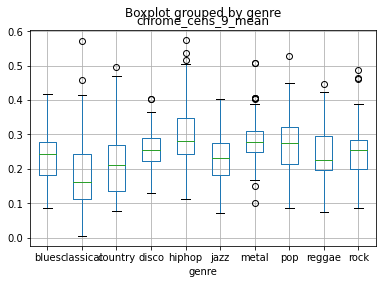

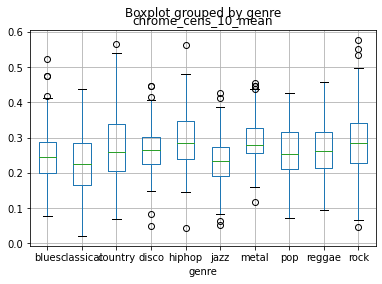

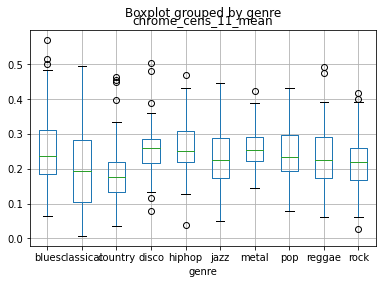

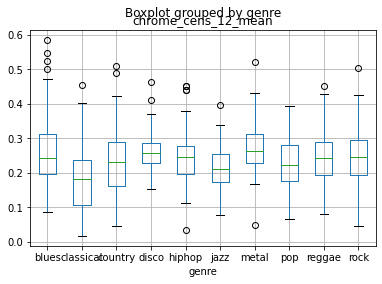

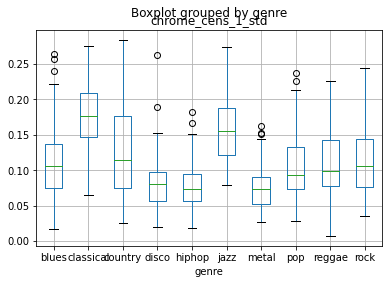

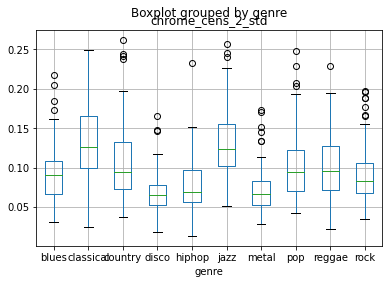

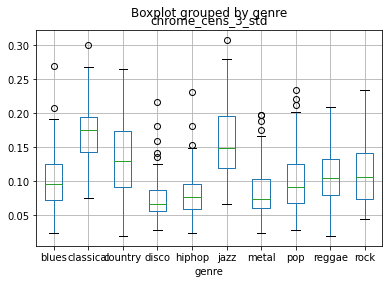

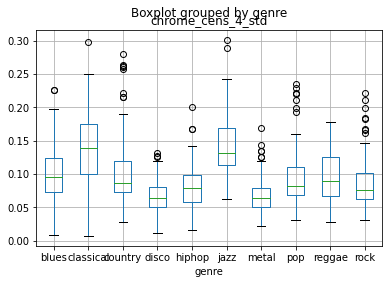

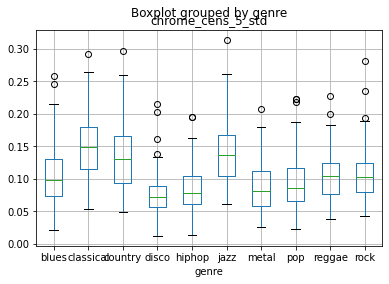

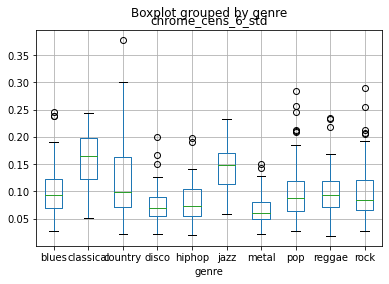

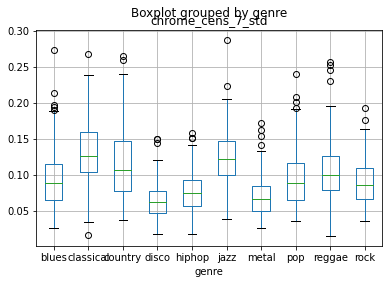

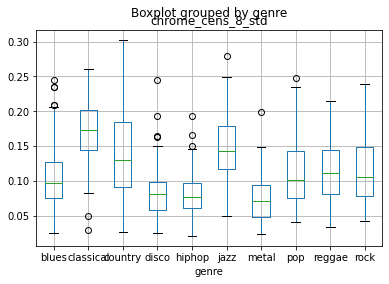

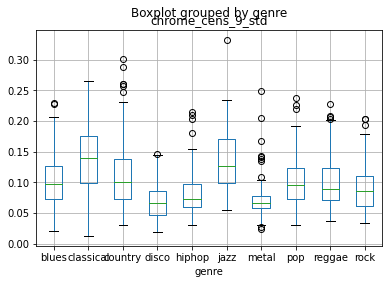

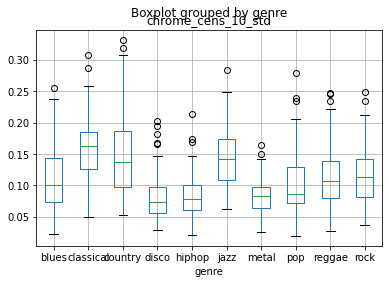

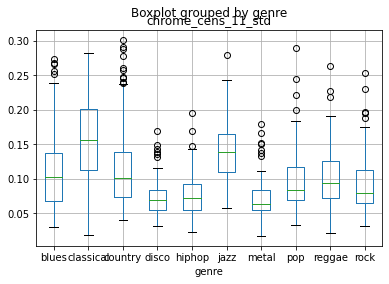

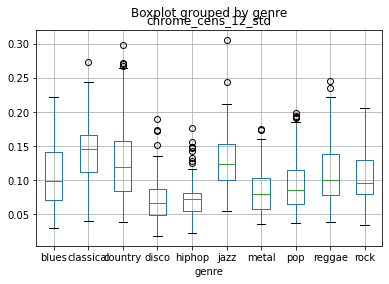

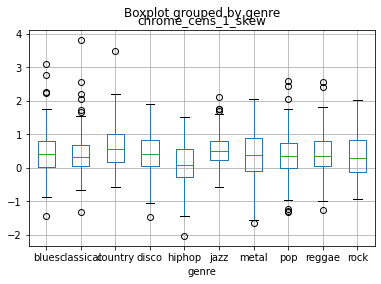

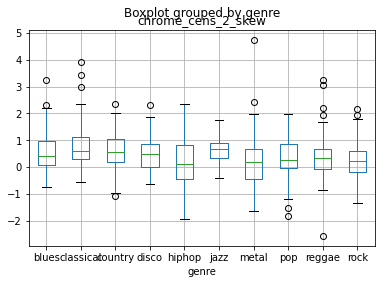

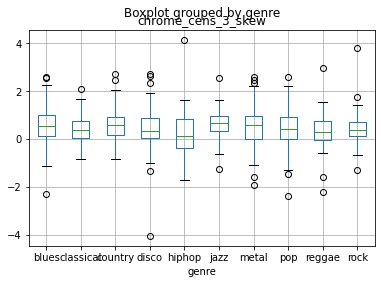

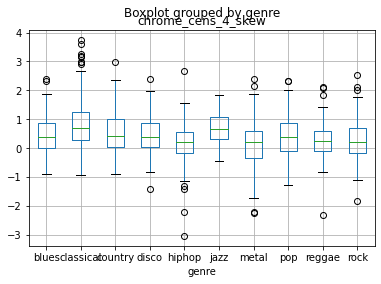

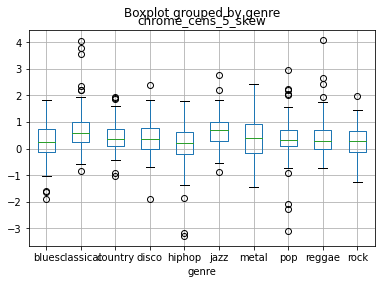

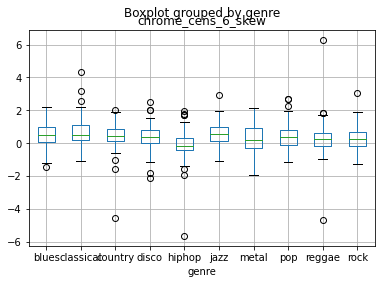

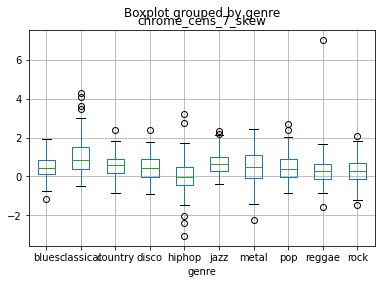

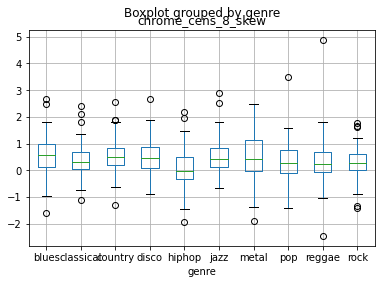

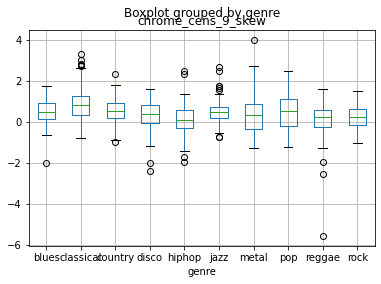

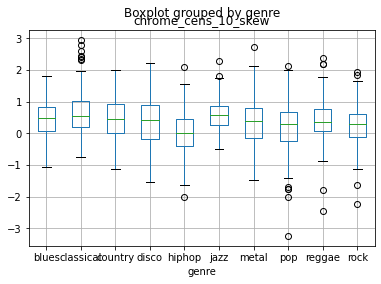

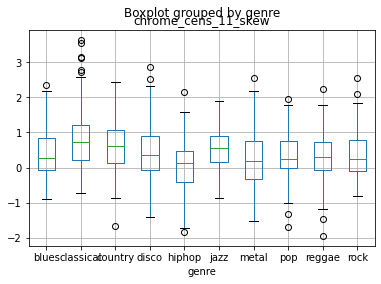

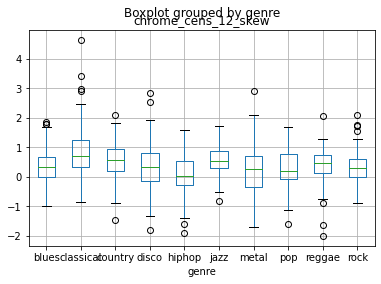

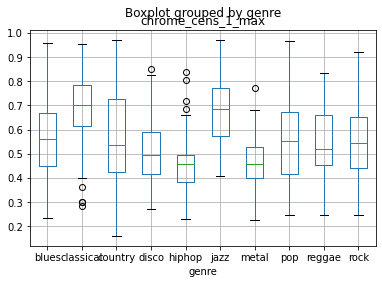

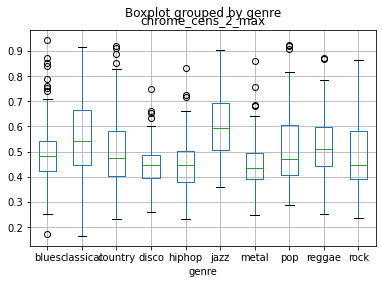

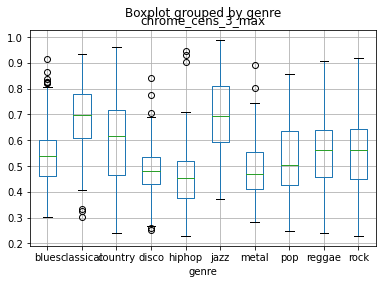

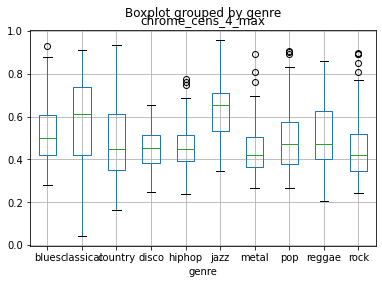

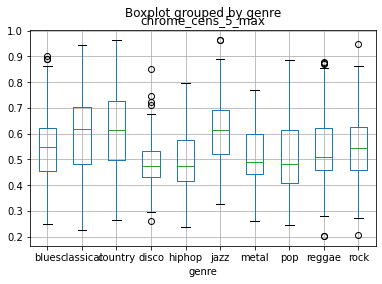

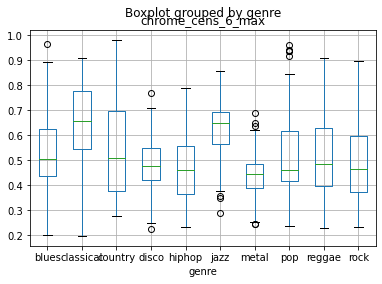

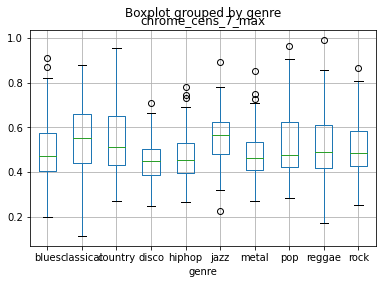

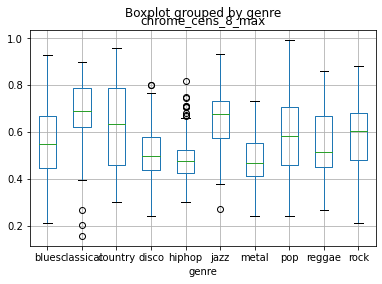

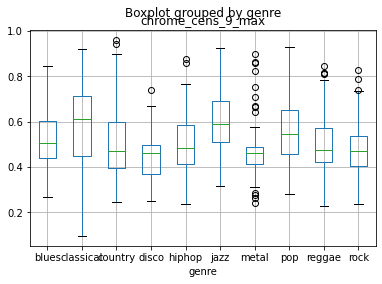

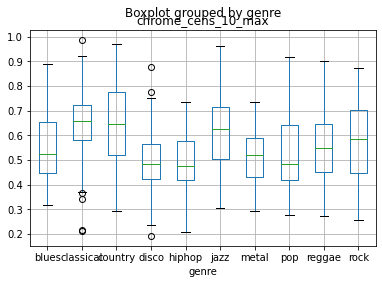

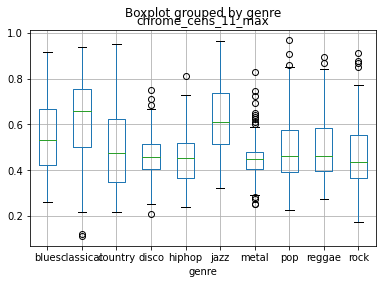

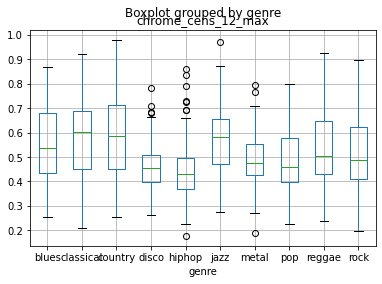

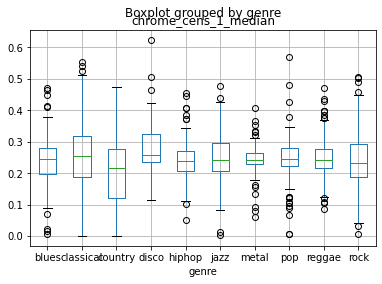

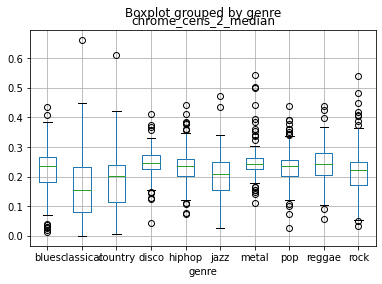

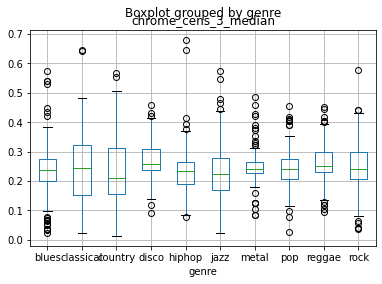

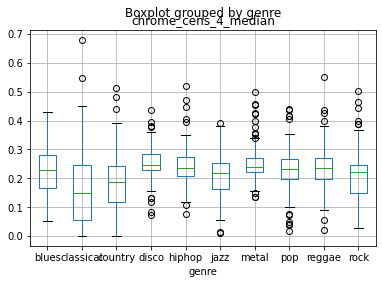

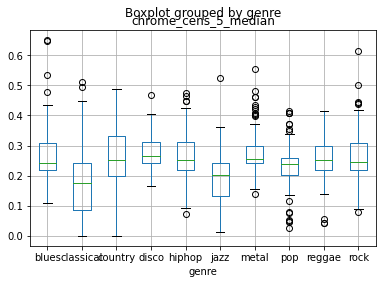

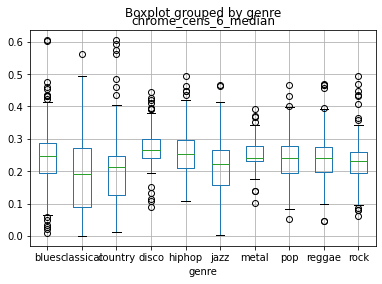

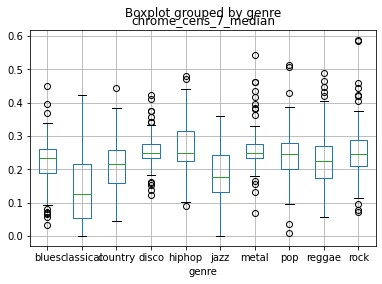

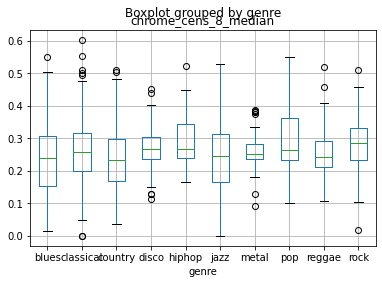

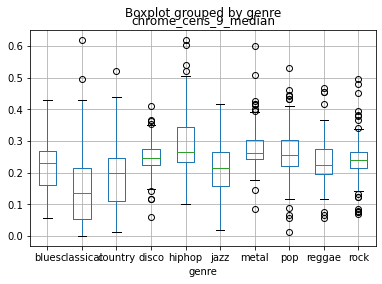

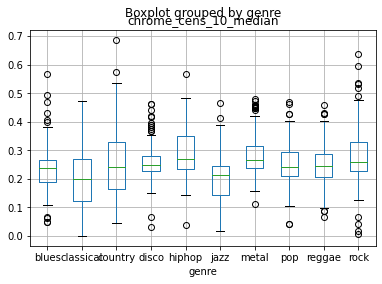

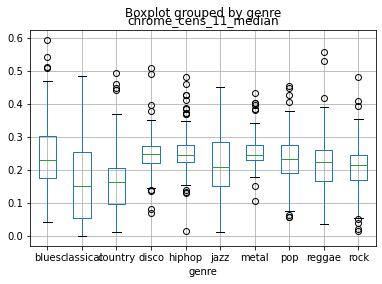

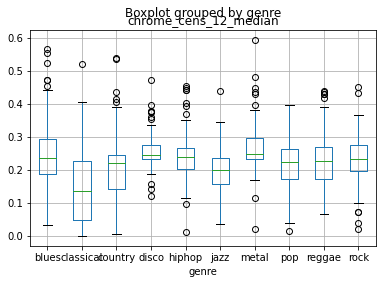

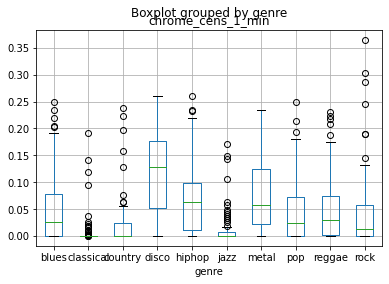

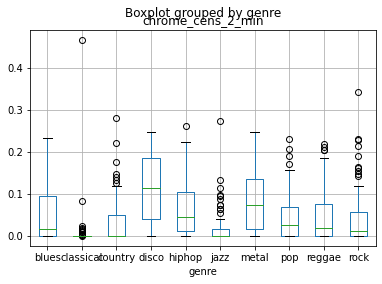

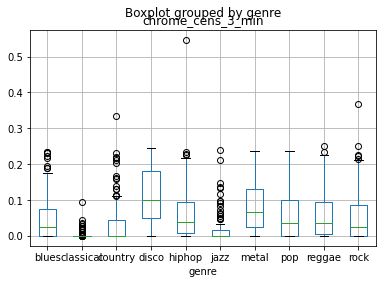

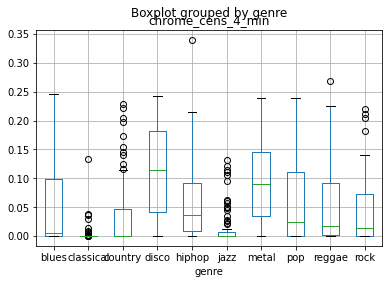

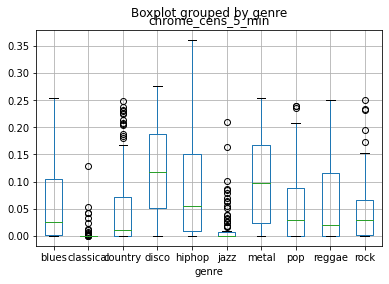

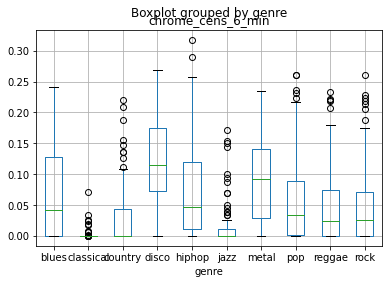

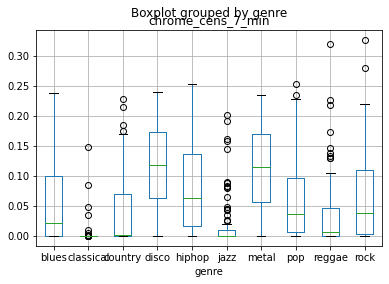

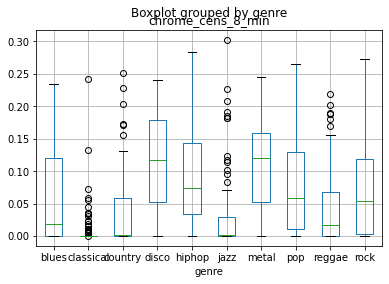

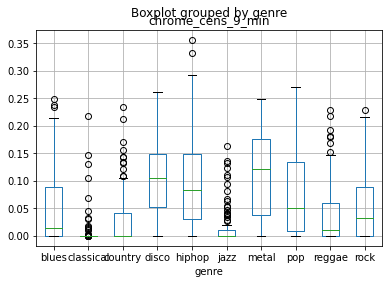

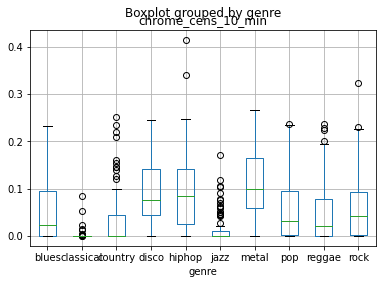

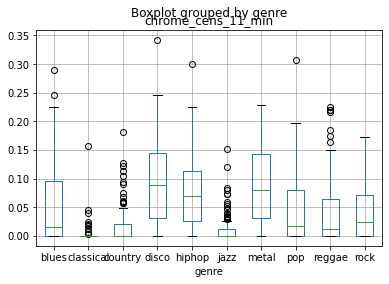

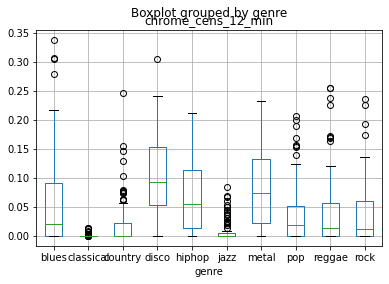

In [ ]:
df2 = df_audio.copy()
df2['genre'] = right_genre

for col in df2.columns.values:
  if col != 'genre':
    df2.boxplot(col, by='genre')

From both boxplots and the histograms, we see that minimum values of the chrome energy normalized are not very informative. They have a huge amount of zeroes, and further, have a lot of outliers. Hence, we ca delete them.<br>
Now, let us plot the Correlation Matrix

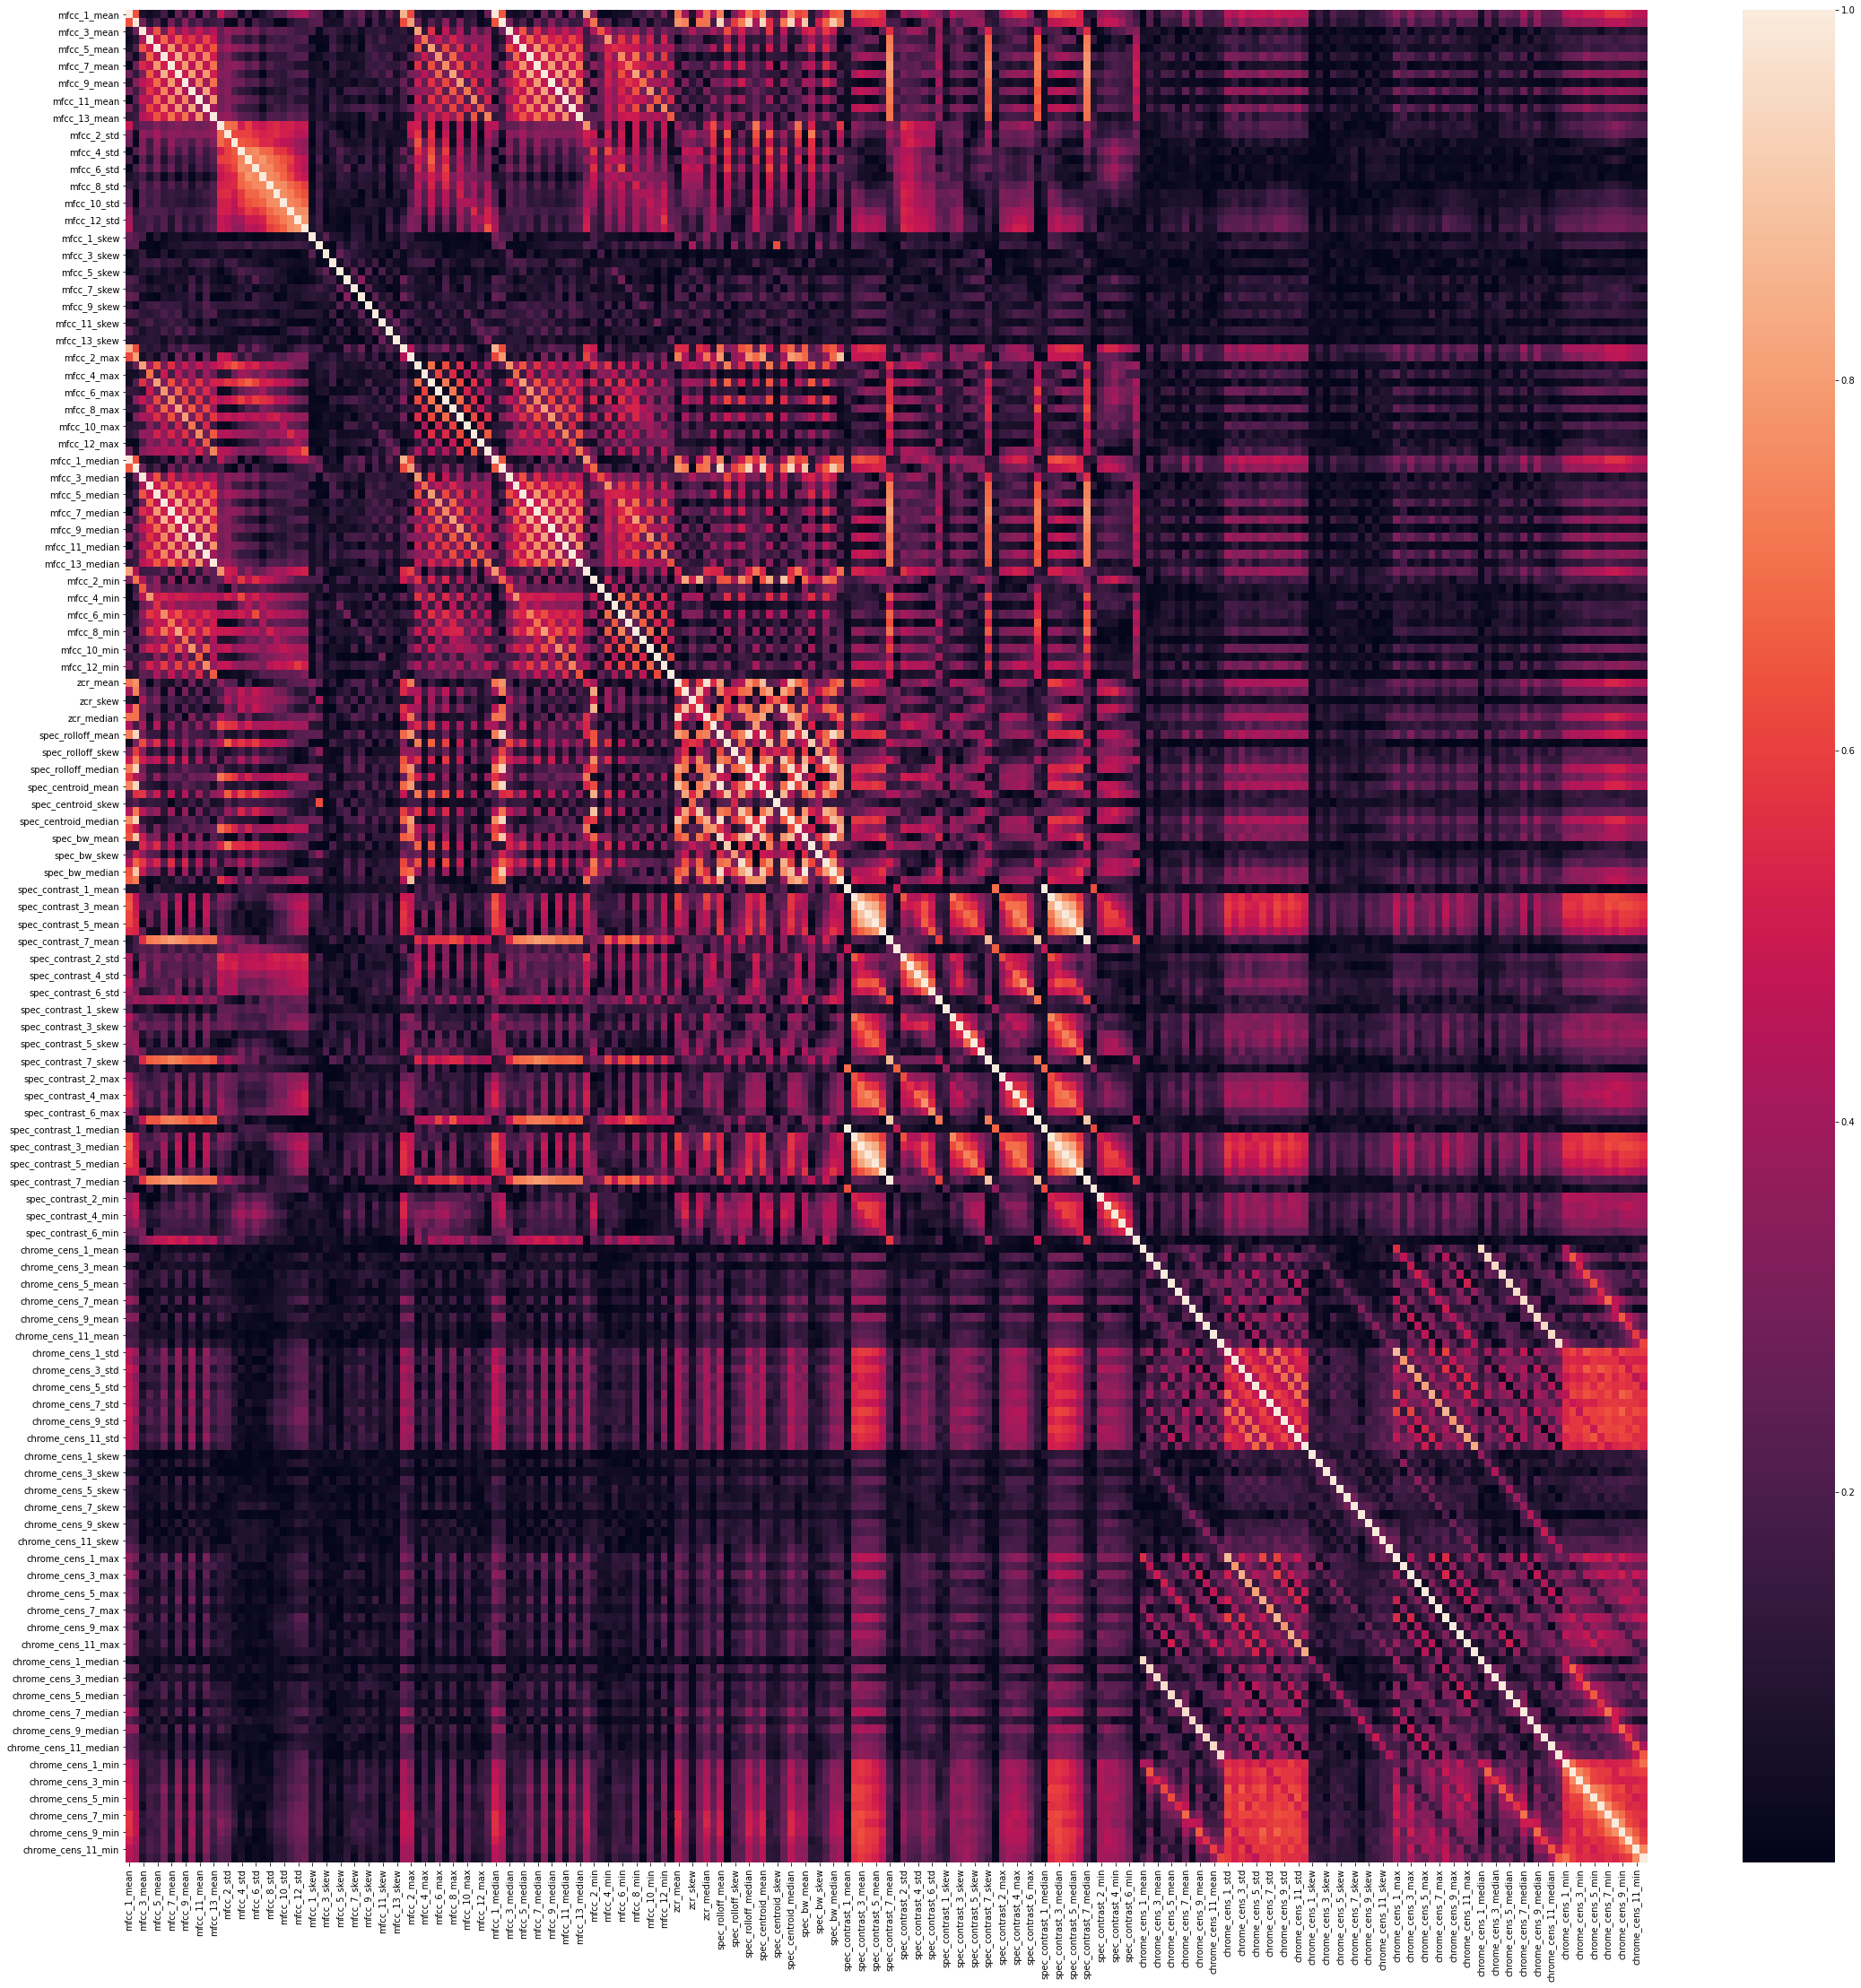

In [ ]:
makeCorrMatrix(df_audio)

After careful analysis of the above mammoth of a graph, we see that the medians of all features correlate (quite obviously) to the means of the same features and in some case means of different slightly related features as well.<br>
We hence remove all medians from the dataset and plot the correlation matrix again.<br>
Hence, we need to remove the medians of all features and also the minimum values of chrome energy normalized data.<br>
This is what we have done through the removeUselessCols function. Since this is highly dependant on data, we had to make this a manual process and couldn't make it automated. 

In [ ]:
df_audio = removeUselessCols(df_audio)
display(df_audio)

mfcc_1_mean  mfcc_2_mean  ...  chrome_cens_11_min  chrome_cens_12_min
0     -42.141018   106.256935  ...            0.019991            0.015151
1    -194.296722   151.881699  ...            0.007438            0.000000
2      -7.939366    62.723667  ...            0.003676            0.004939
3    -101.284462   120.425171  ...            0.121372            0.000000
4    -126.175415    77.663651  ...            0.023711            0.018169
..           ...          ...  ...                 ...                 ...
995   -74.083527    80.068756  ...            0.224144            0.205292
996     2.836352    77.069611  ...            0.099742            0.000063
997    22.877514    60.810783  ...            0.008288            0.000000
998   -93.555923    89.864960  ...            0.174063            0.175357
999  -107.106850    47.654846  ...            0.189905            0.084807

[1000 rows x 180 columns]

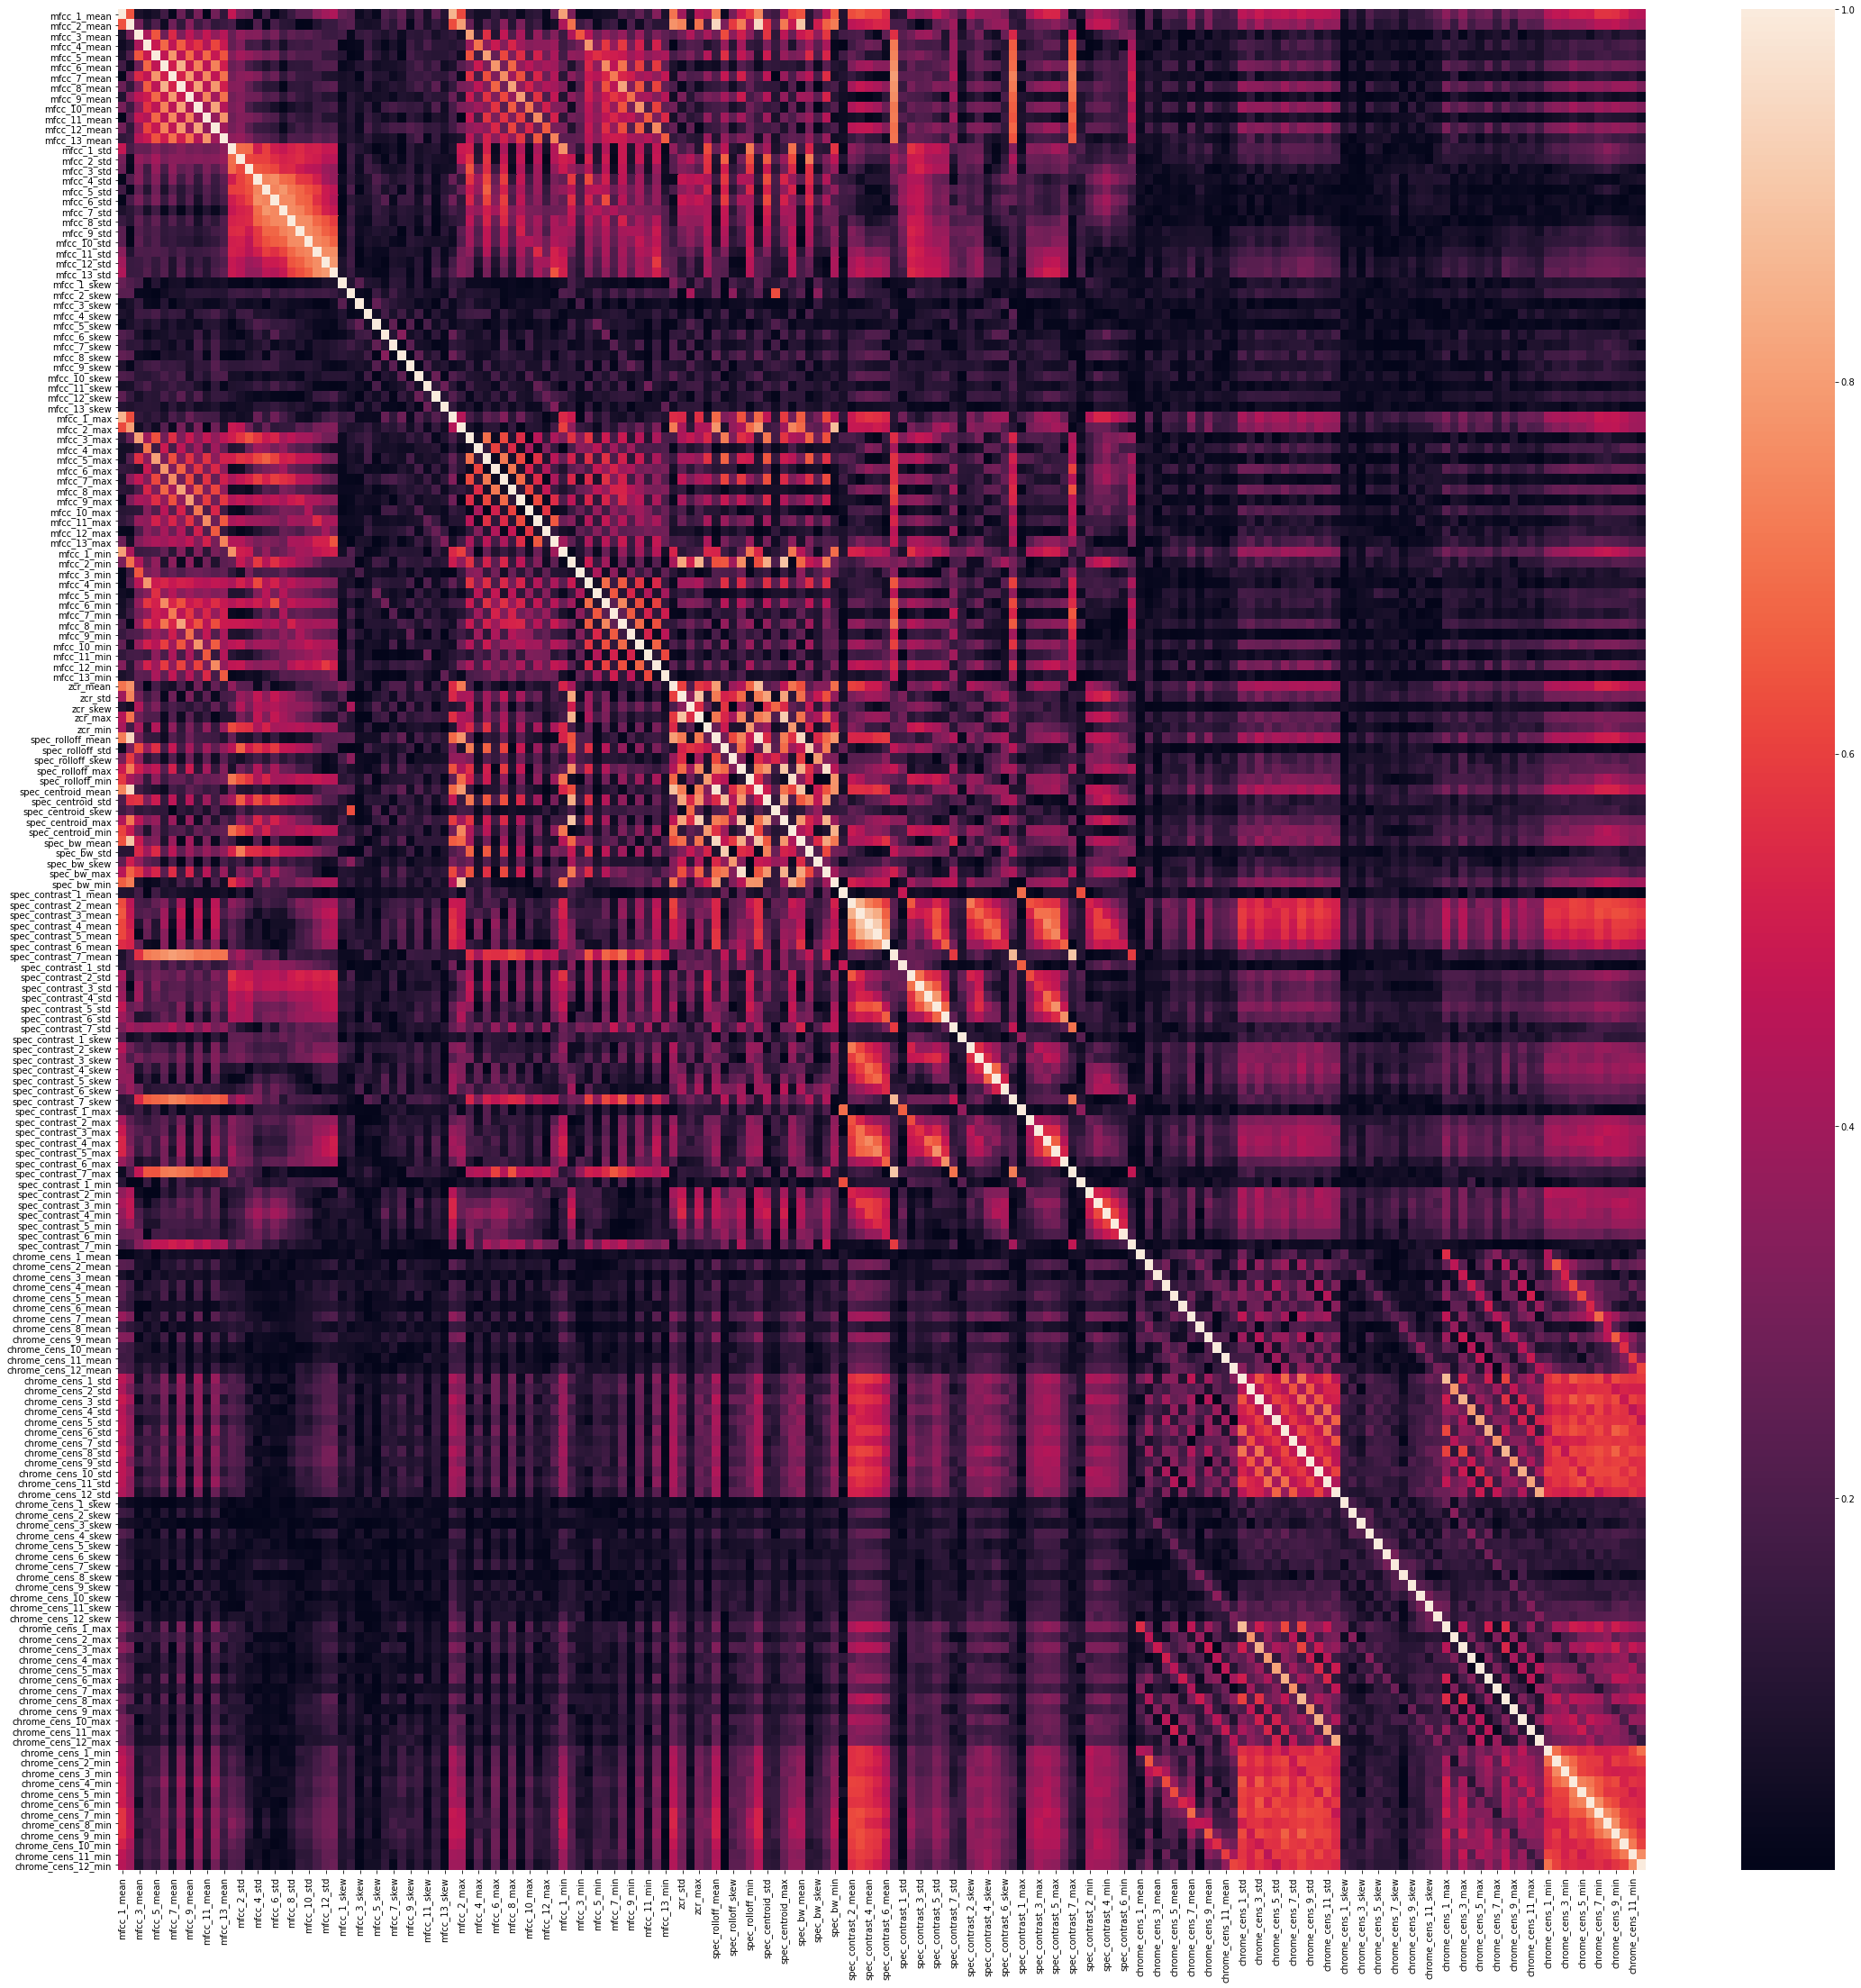

In [ ]:
makeCorrMatrix(df_audio)

We still see a few areas of slightly higher correlation, however, since these features describe audio characteristics, we do expect slight relations in max values, min values etc. So, we move ahead.<br><br>
Before moving on to PCA to reduce features, we scale the data so that the mean of the data is 0 and the standard deviation is 1.

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(df_audio)
curr_cols = df_audio.columns.values
df_audio = pd.DataFrame(scaler.transform(df_audio), columns=curr_cols)
display(df_audio)
display(df_audio.mean(), df_audio.std())

mfcc_1_mean  mfcc_2_mean  ...  chrome_cens_11_min  chrome_cens_12_min
0       1.021488     0.214038  ...           -0.444926           -0.487816
1      -0.497346     1.670991  ...           -0.643757           -0.729971
2       1.362893    -1.176126  ...           -0.703353           -0.651040
3       0.431112     0.666478  ...            1.160959           -0.729971
4       0.182648    -0.699042  ...           -0.385997           -0.439592
..           ...          ...  ...                 ...                 ...
995     0.702635    -0.622238  ...            2.788879            2.551086
996     1.470457    -0.718011  ...            0.818337           -0.728966
997     1.670510    -1.237210  ...           -0.630301           -0.729971
998     0.508259    -0.309413  ...            1.995594            2.072646
999     0.372993    -1.657324  ...            2.246523            0.625450

[1000 rows x 180 columns]

mfcc_1_mean           1.013634e-16
mfcc_2_mean           1.645351e-16
mfcc_3_mean          -1.027130e-17
mfcc_4_mean           1.607325e-16
mfcc_5_mean          -4.052314e-17
                          ...     
chrome_cens_8_min     6.616929e-16
chrome_cens_9_min     2.933209e-16
chrome_cens_10_min    3.854694e-16
chrome_cens_11_min   -3.699263e-16
chrome_cens_12_min   -1.761924e-16
Length: 180, dtype: float64

mfcc_1_mean           1.0005
mfcc_2_mean           1.0005
mfcc_3_mean           1.0005
mfcc_4_mean           1.0005
mfcc_5_mean           1.0005
                       ...  
chrome_cens_8_min     1.0005
chrome_cens_9_min     1.0005
chrome_cens_10_min    1.0005
chrome_cens_11_min    1.0005
chrome_cens_12_min    1.0005
Length: 180, dtype: float64

Pre-Processing of data is DONE.<br>
We now apply PCA to reduce the number of features in the data.

# Reducing Dimensions through Principal Component Analysis

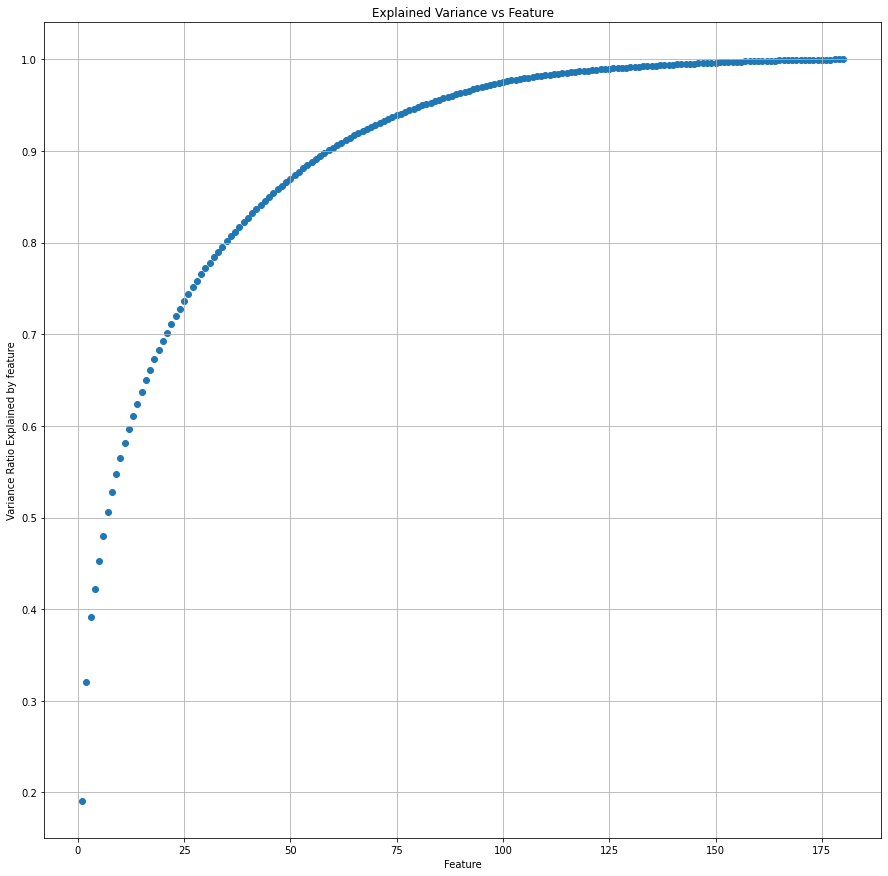

In [ ]:
pca = PCA()

df_audio_decomp = pca.fit(df_audio)
varRatio_summed = [pca.explained_variance_ratio_[:i].sum() for i in range(1,len(df_audio.columns.values)+1)]
plt.figure(figsize=(15,15))
plt.scatter(range(1,len(df_audio.columns.values)+1), varRatio_summed)
plt.grid(b=True)
plt.title(f"Explained Variance vs Feature")
plt.xlabel("Feature")
plt.ylabel("Variance Ratio Explained by feature")
plt.show()

In [ ]:
for i in range(1,len(df_audio.columns.values)+1):
  if pca.explained_variance_ratio_[:i].sum() >= 0.95:
    n_comp = i
    break

print(f"Number of components for >95% variance ratio explained is {n_comp}")
pca_fin = PCA(n_components=n_comp)
df_audio_decomp = pca_fin.fit_transform(df_audio)
print(f"Total Ratio of Variance explained = {pca_fin.explained_variance_ratio_.sum()*100}%")

df_audio_decomp = pd.DataFrame(data=df_audio_decomp)
display(df_audio_decomp)

reconstructed_dat = pca_fin.inverse_transform(df_audio_decomp)
mserror = MSE(df_audio, reconstructed_dat)
print("MSE for PCA with {} components: {}".format(n_comp,mserror))

Number of components for >95% variance ratio explained is 82
Total Ratio of Variance explained = 95.11537147928635%


0         1         2   ...        79        80        81
0    -1.919659 -3.356321  2.533201  ...  0.082048  0.329510  0.206097
1     6.767145  0.842835  0.341944  ... -0.218062  0.376514 -0.086680
2    -2.424846 -1.640651 -7.832327  ... -0.365234  0.107977  0.226840
3    -0.113152 -2.054654  2.409417  ... -0.286639  0.579532  0.146396
4    -2.615504  2.595627 -4.626146  ...  0.436472 -0.160472 -0.299408
..         ...       ...       ...  ...       ...       ...       ...
995 -10.689216 -5.140251  0.391155  ... -0.060143  0.197399 -0.198720
996  -6.262365 -1.769076  0.704046  ...  0.144518  0.297971 -0.044337
997 -10.418118 -2.549441  0.567669  ... -0.355419  0.618300 -0.081636
998  -8.063360 -7.039906  0.576678  ...  0.064852  0.187331 -0.394657
999  -9.859481 -0.206073 -3.315835  ... -0.415259 -0.211970  0.216116

[1000 rows x 82 columns]

MSE for PCA with 82 components: 0.04884628520713707


We see that with 82 features, around 95% of the variance is explained. (Going by the elbow method used in clustering)<br>
So, we take only those many features for continuing our analysis.<br>

Let's proceed to visualize our decomposed data.

float64


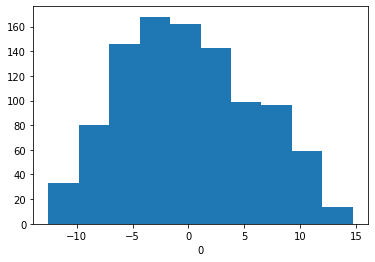

float64


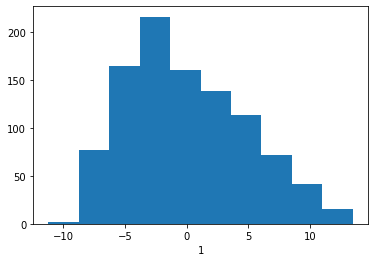

float64


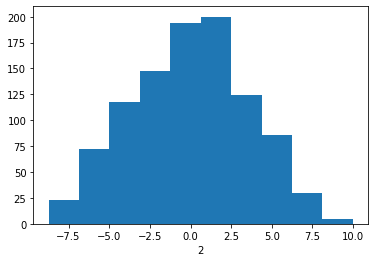

float64


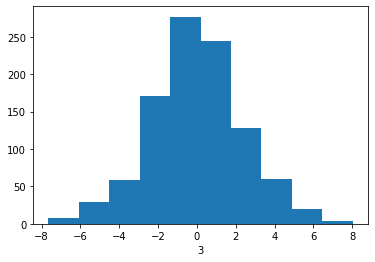

float64


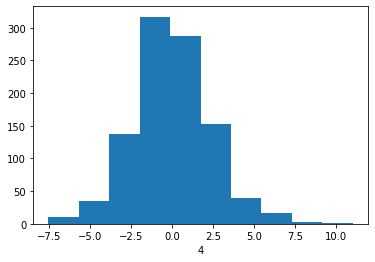

float64


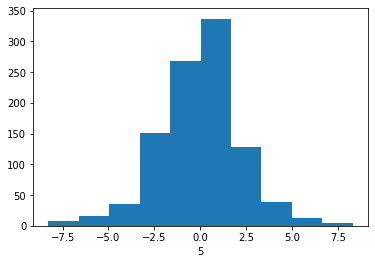

float64


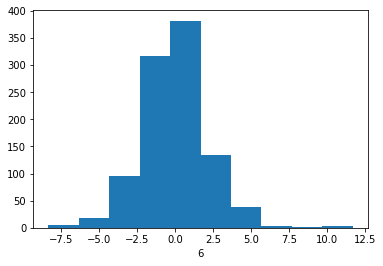

float64


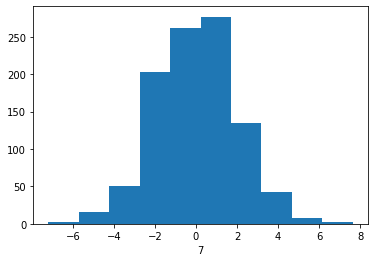

float64


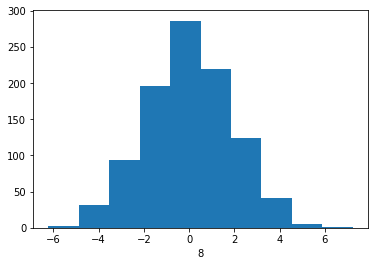

float64


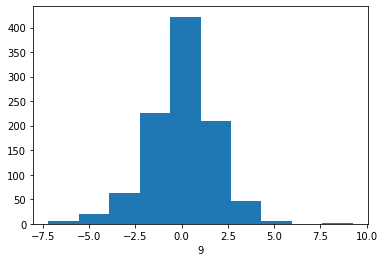

float64


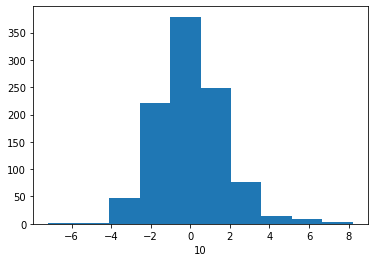

float64


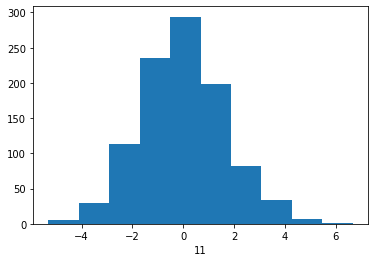

float64


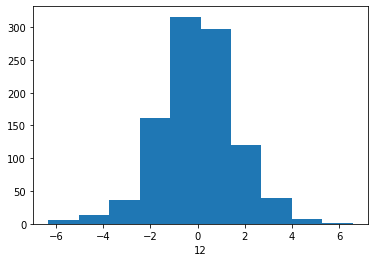

float64


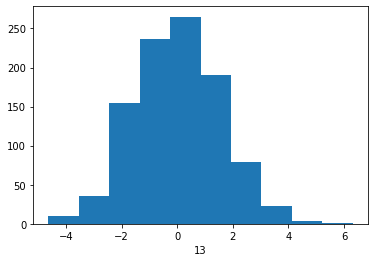

float64


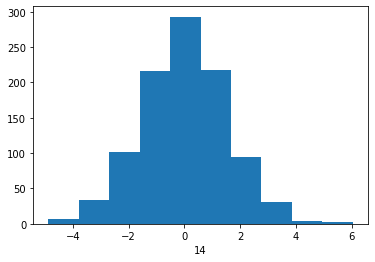

float64


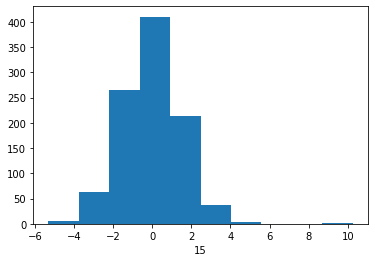

float64


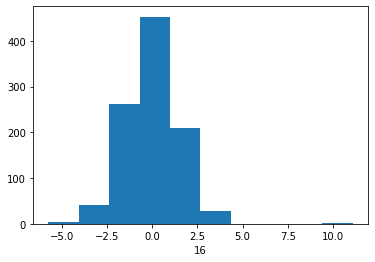

float64


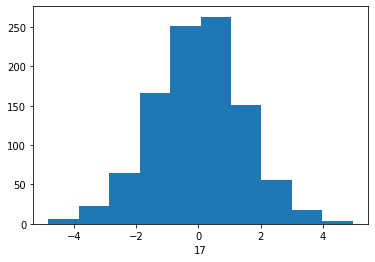

float64


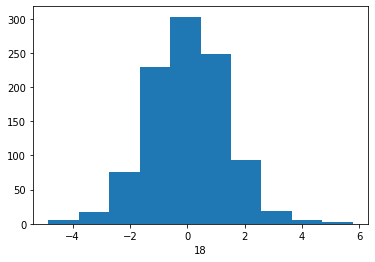

float64


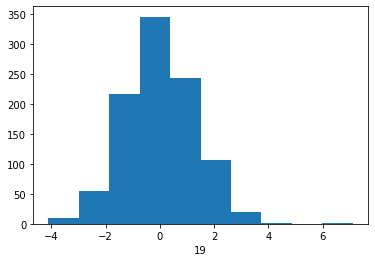

float64


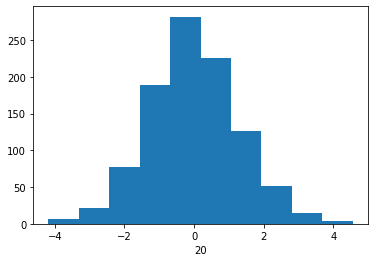

float64


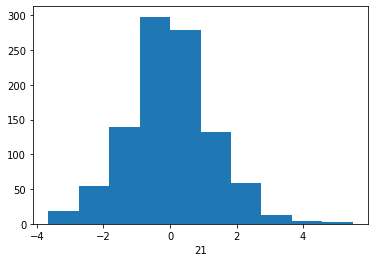

float64


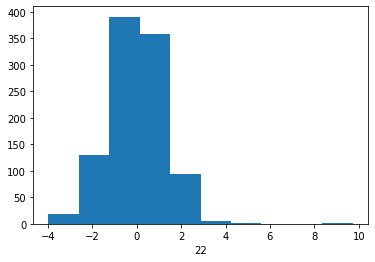

float64


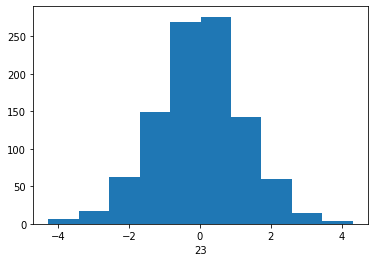

float64


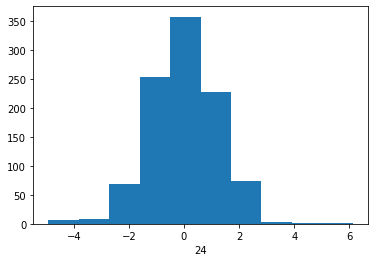

float64


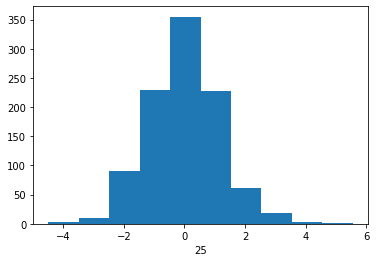

float64


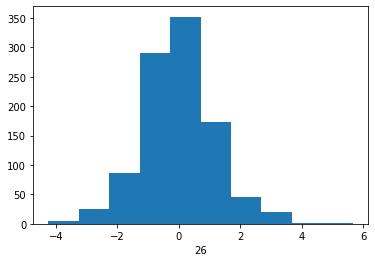

float64


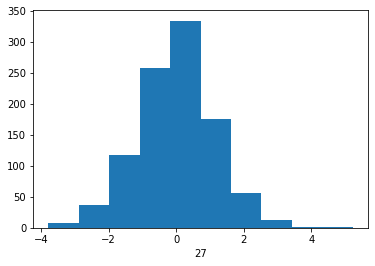

float64


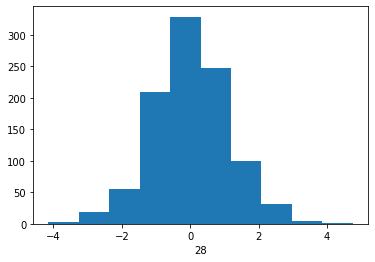

float64


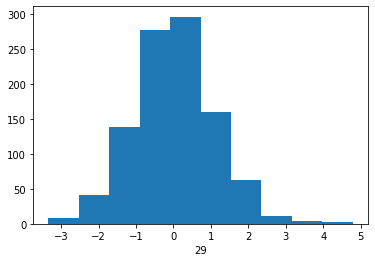

float64


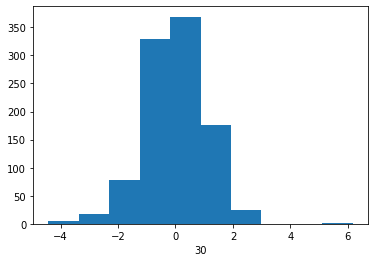

float64


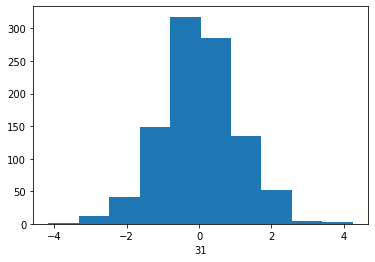

float64


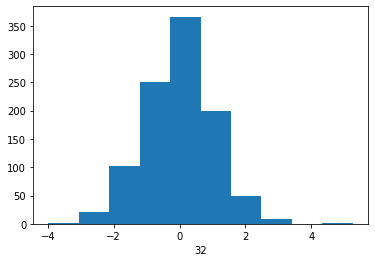

float64


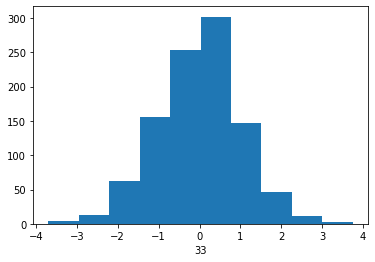

float64


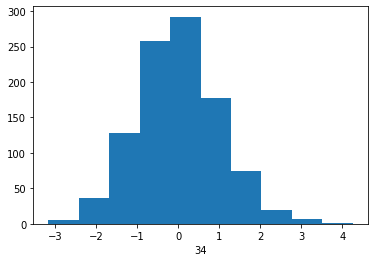

float64


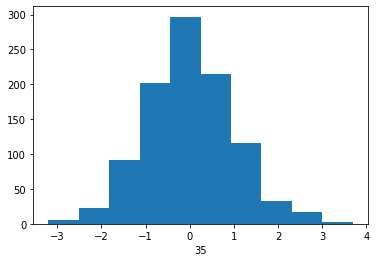

float64


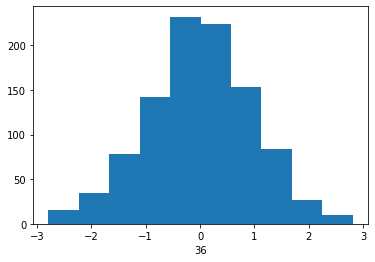

float64


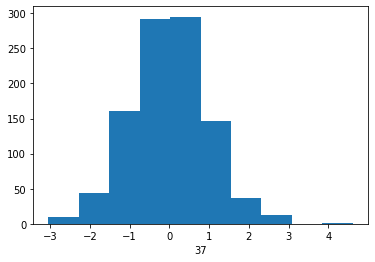

float64


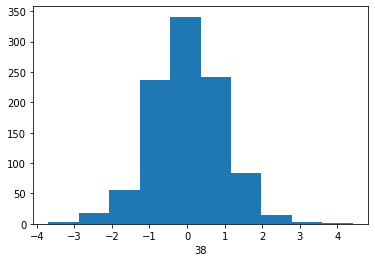

float64


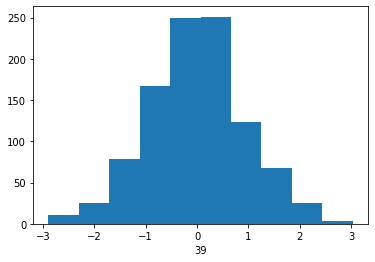

float64


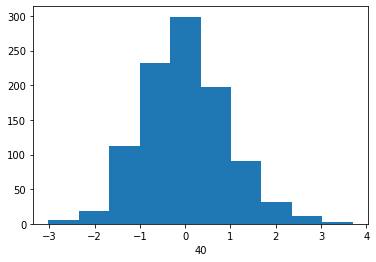

float64


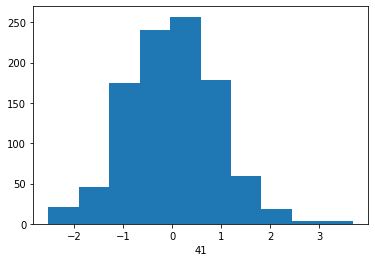

float64


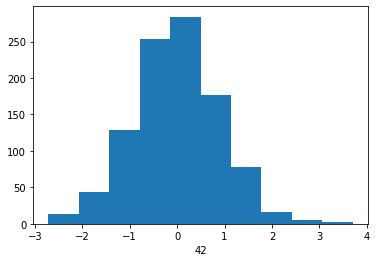

float64


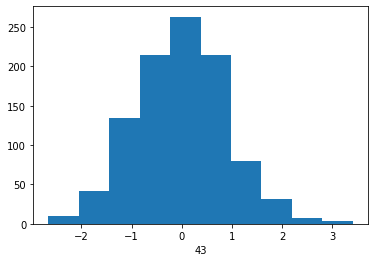

float64


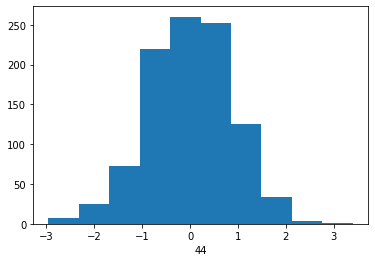

float64


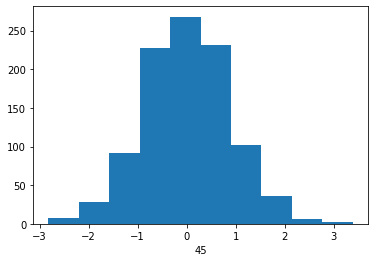

float64


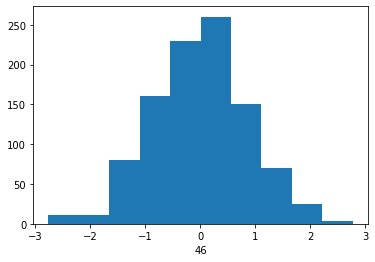

float64


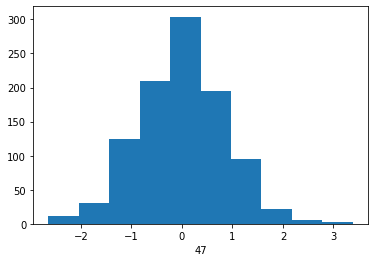

float64


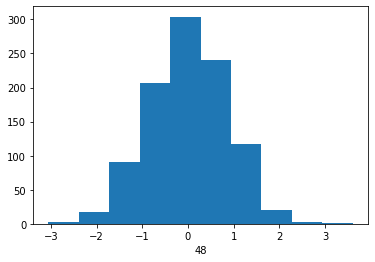

float64


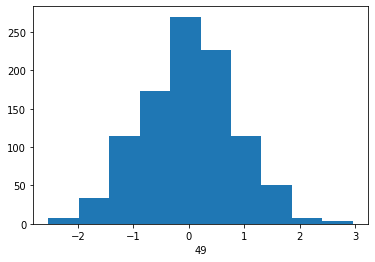

float64


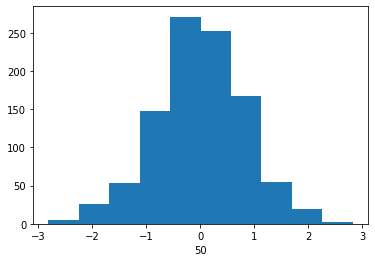

float64


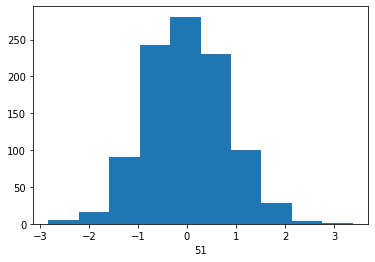

float64


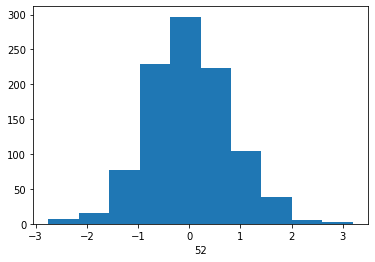

float64


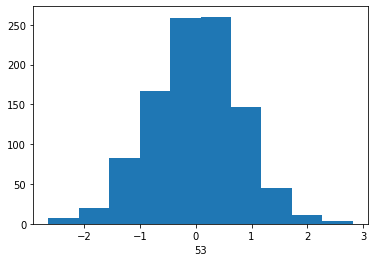

float64


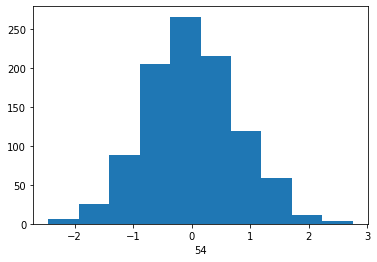

float64


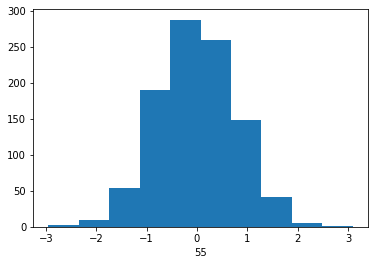

float64


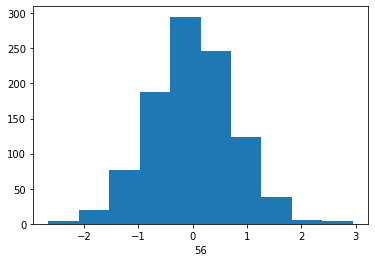

float64


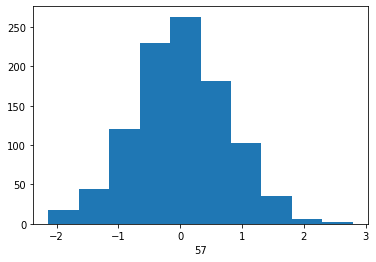

float64


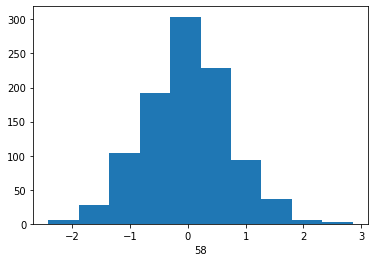

float64


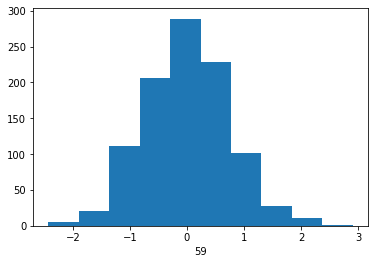

float64


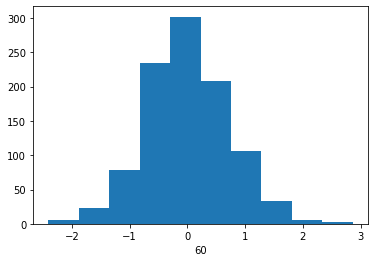

float64


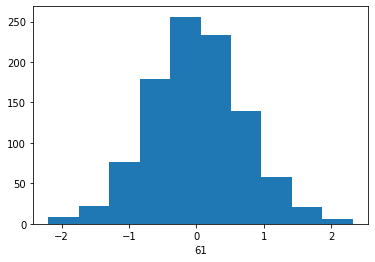

float64


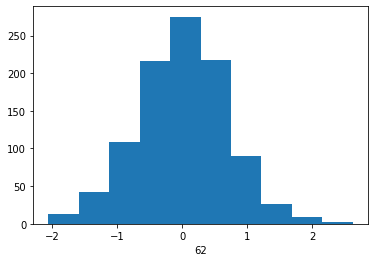

float64


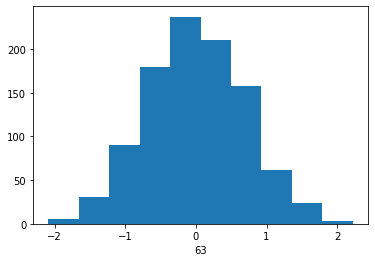

float64


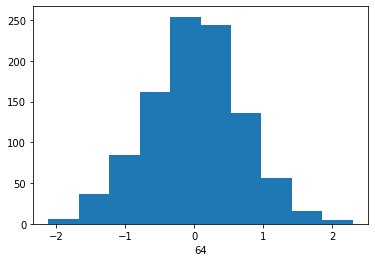

float64


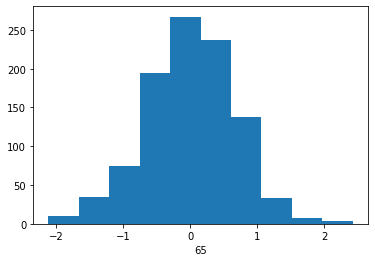

float64


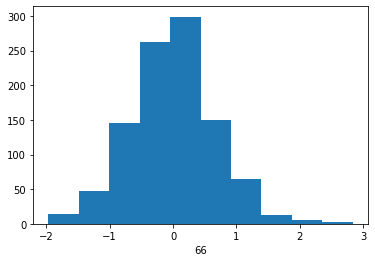

float64


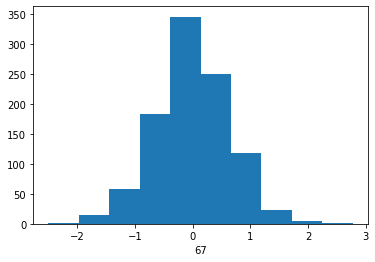

float64


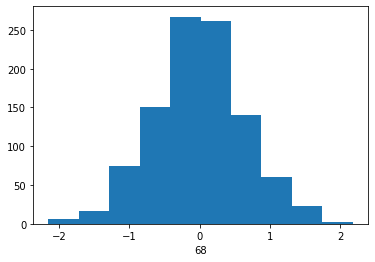

float64


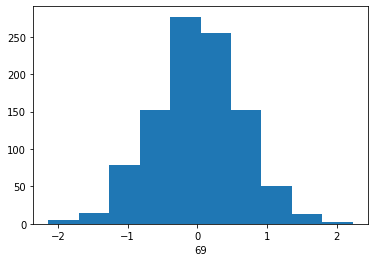

float64


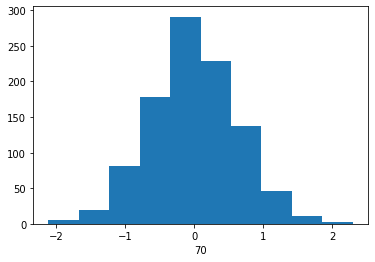

float64


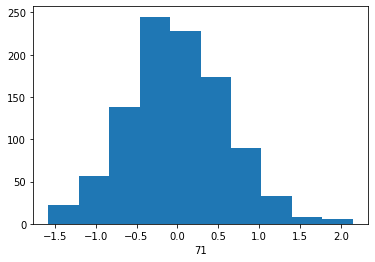

float64


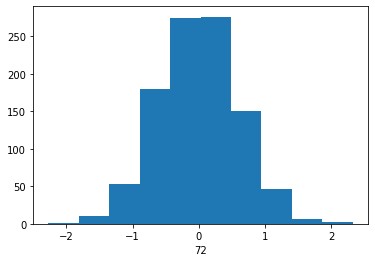

float64


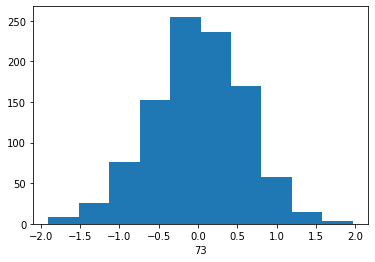

float64


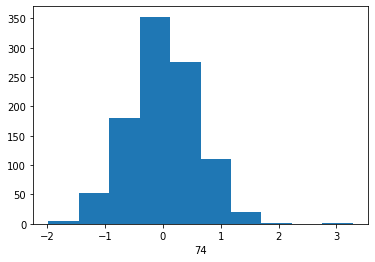

float64


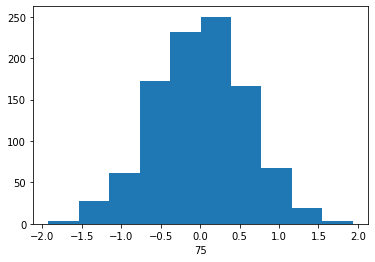

float64


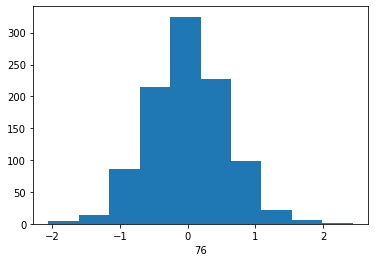

float64


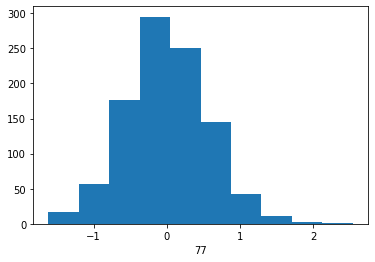

float64


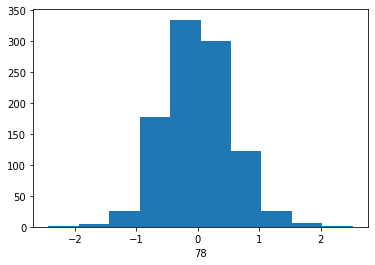

float64


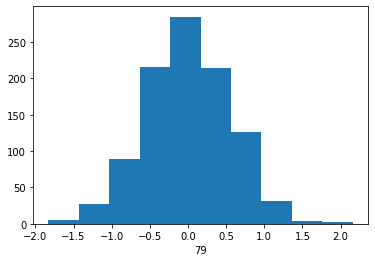

float64


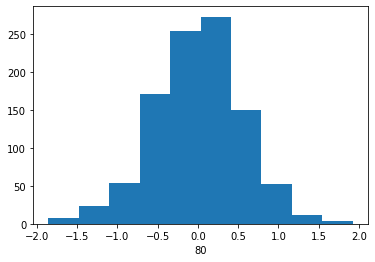

float64


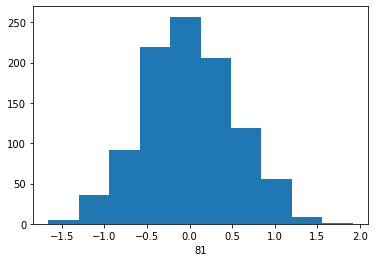

In [ ]:
plotAllHist(df_audio_decomp)

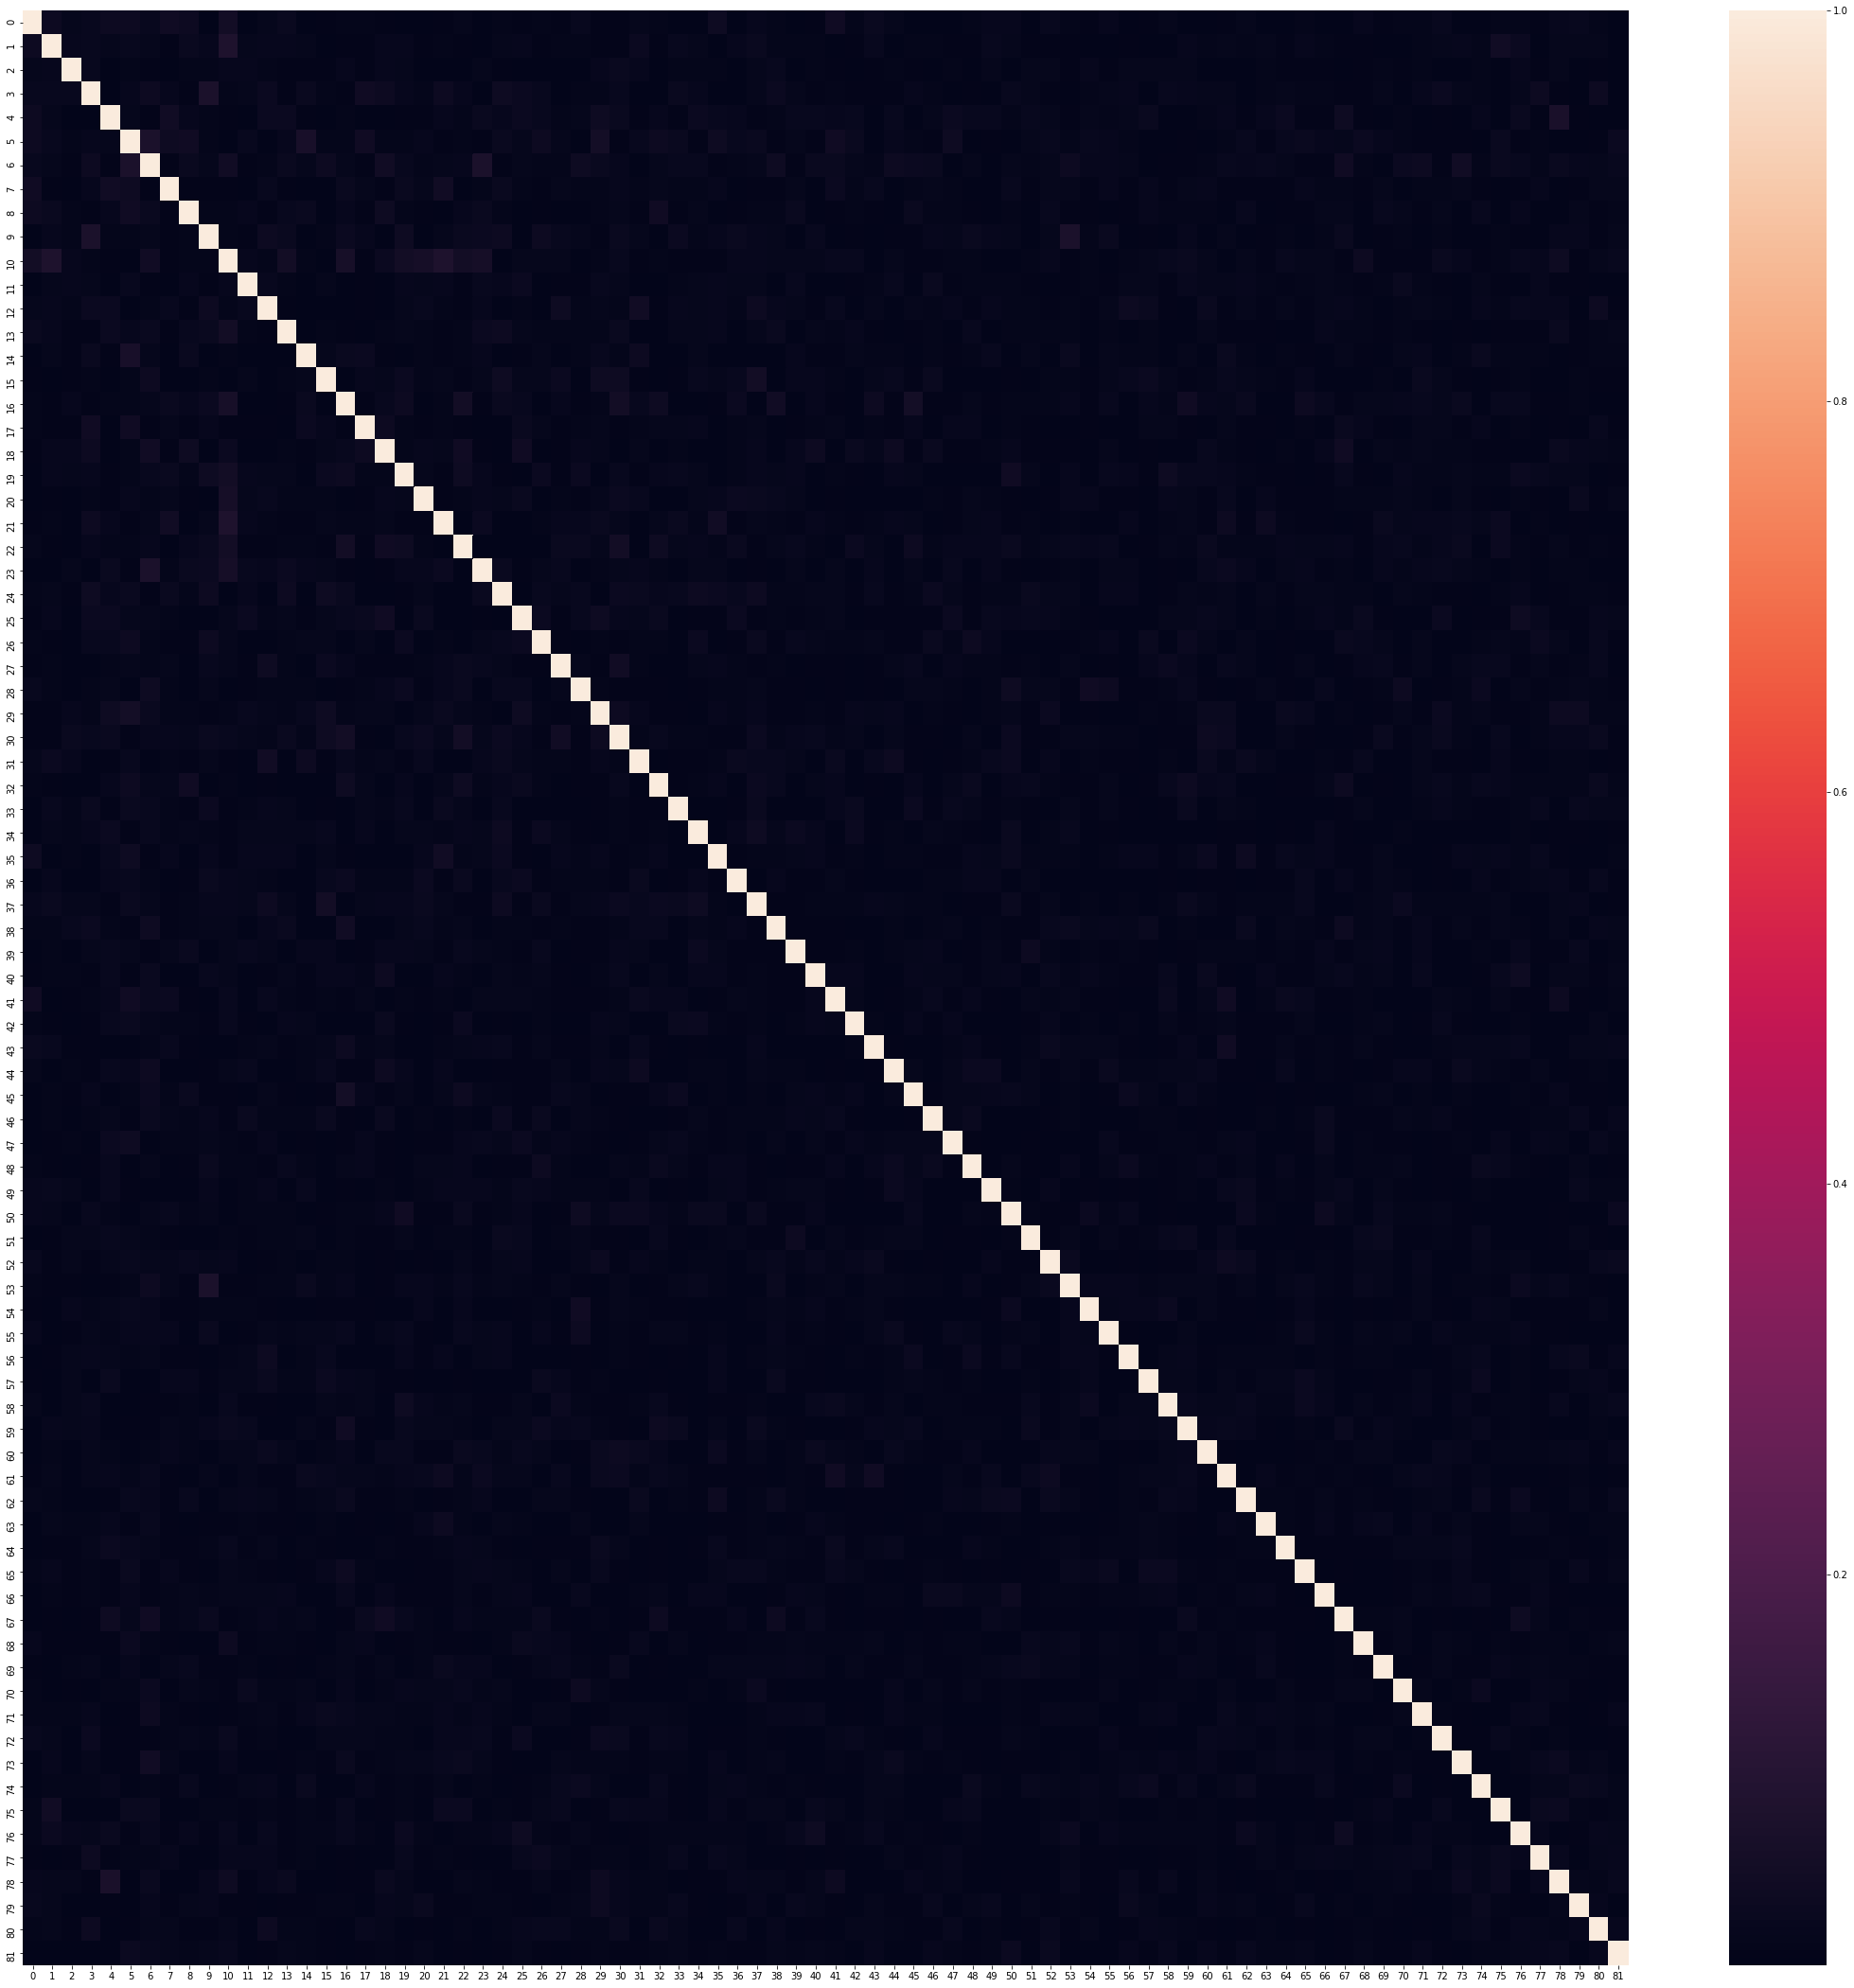

In [ ]:
makeCorrMatrix(df_audio_decomp)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly cl

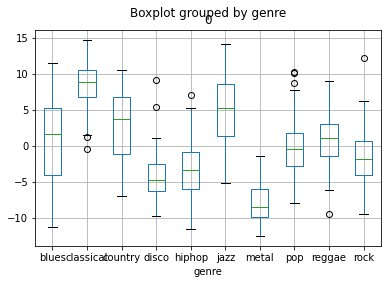

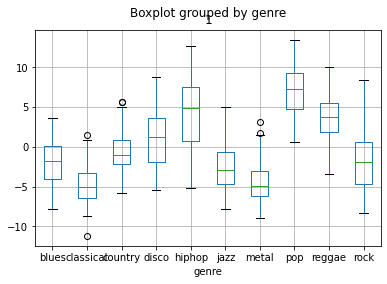

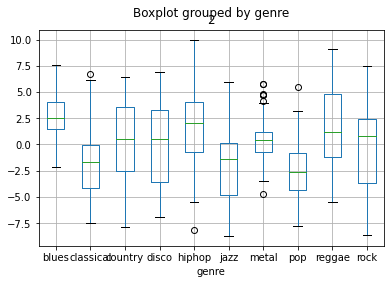

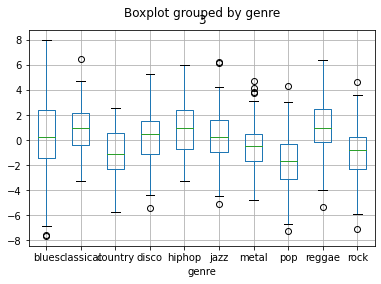

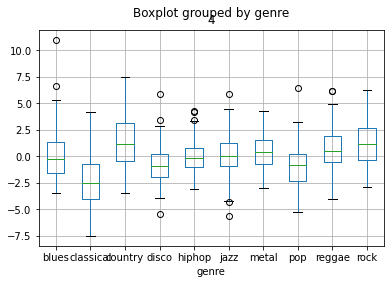

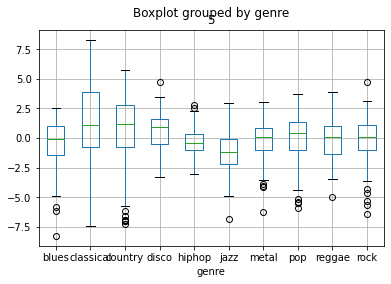

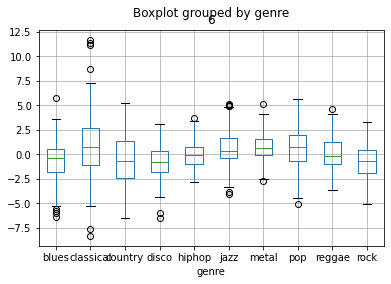

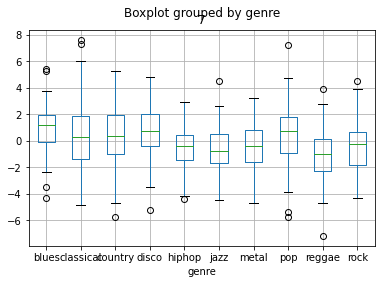

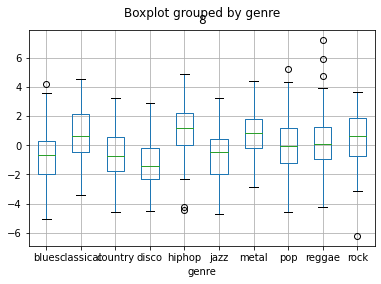

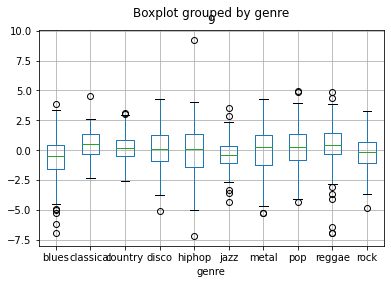

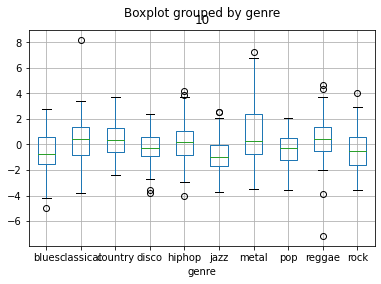

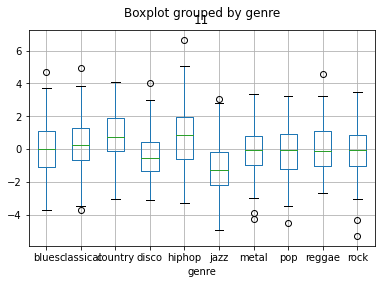

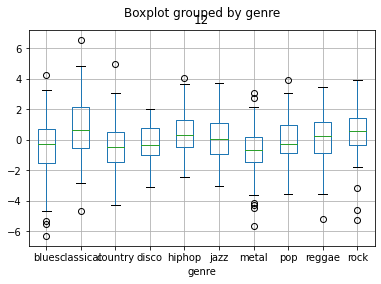

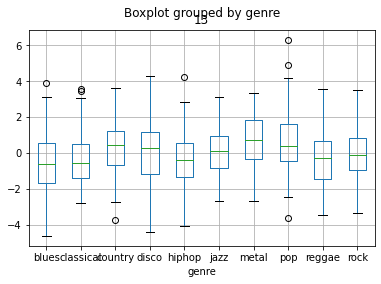

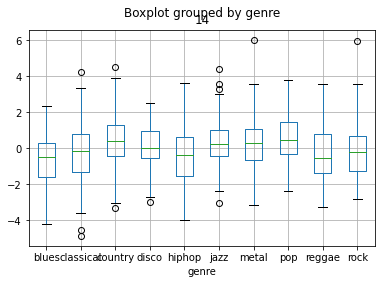

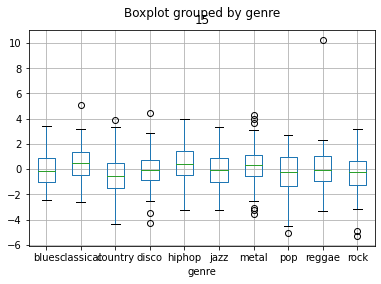

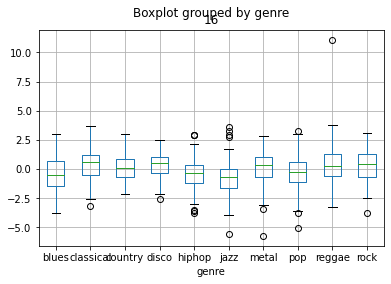

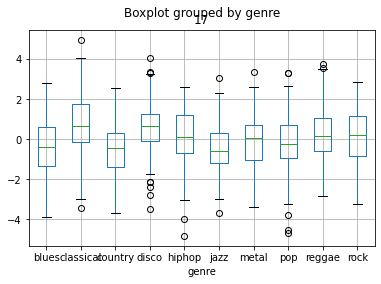

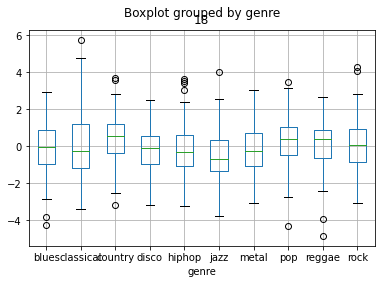

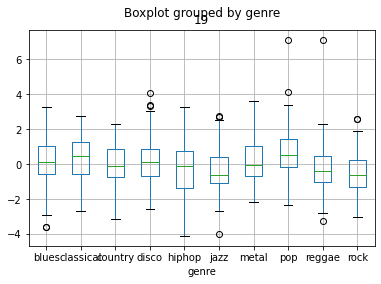

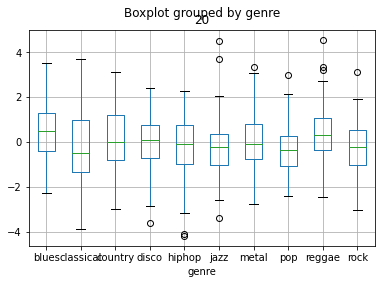

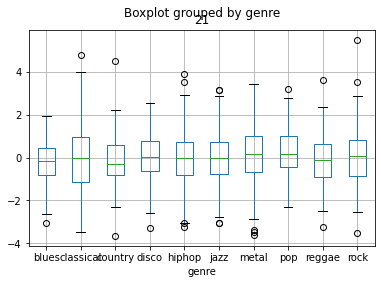

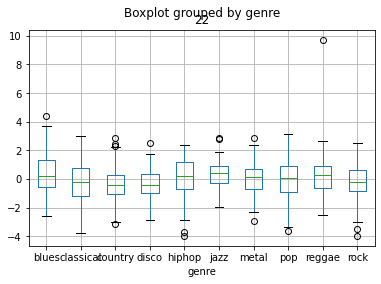

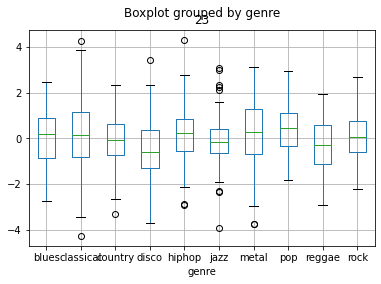

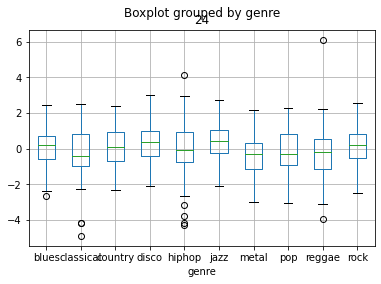

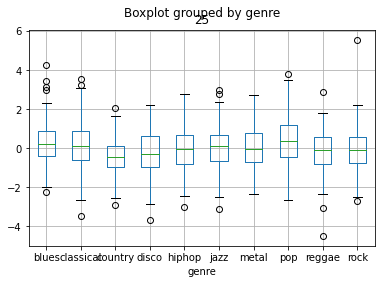

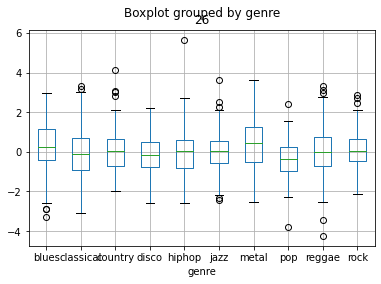

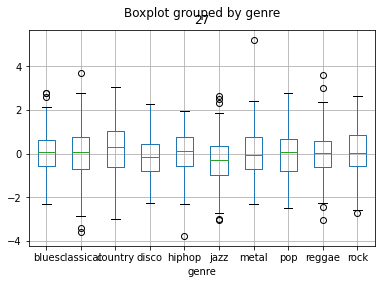

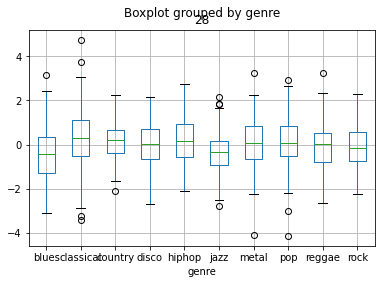

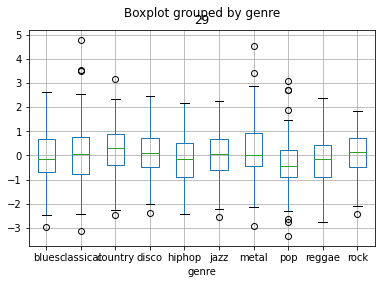

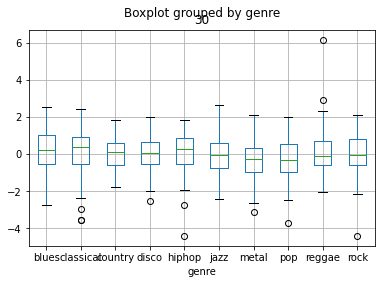

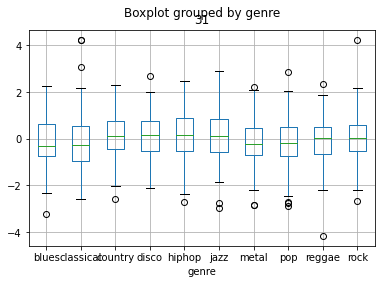

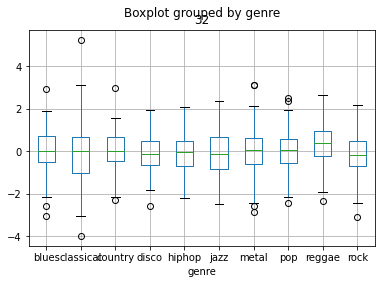

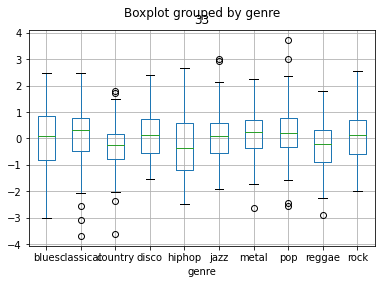

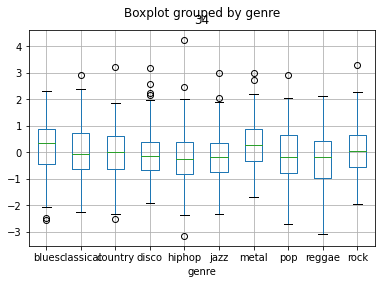

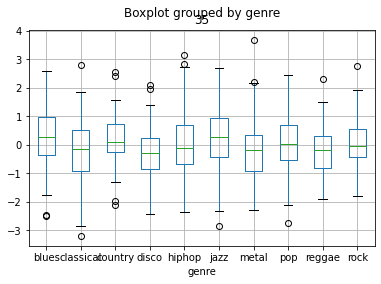

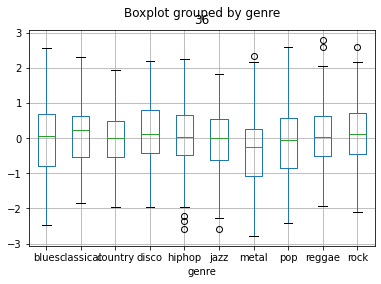

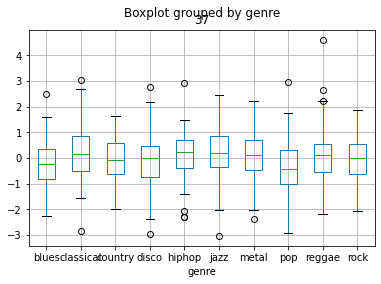

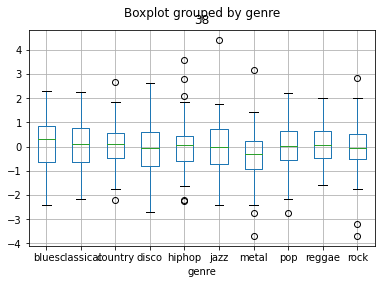

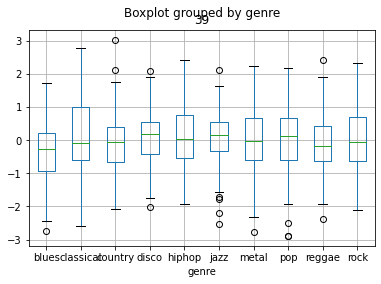

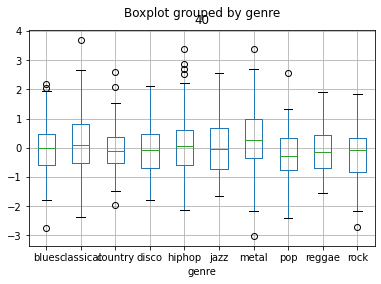

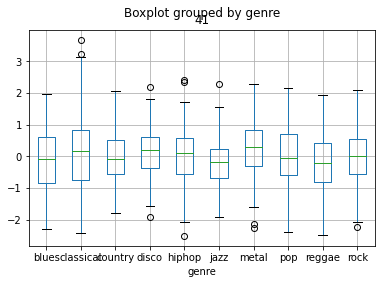

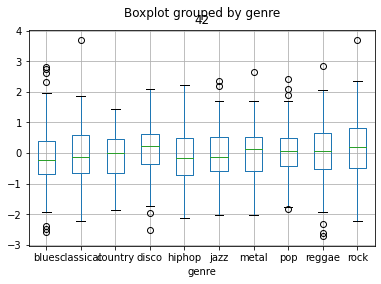

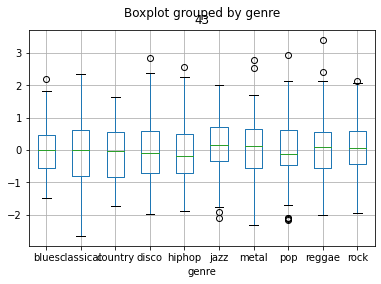

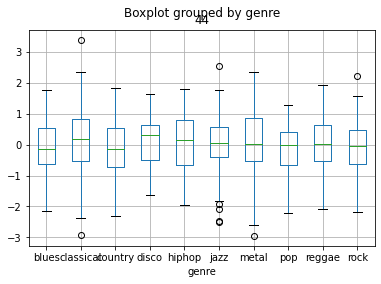

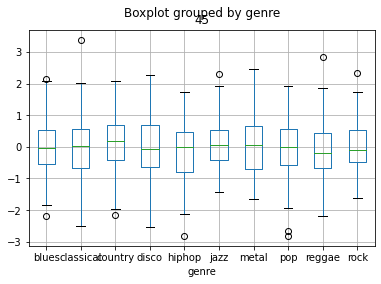

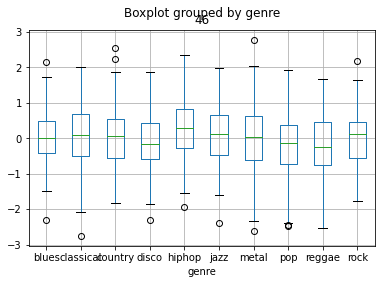

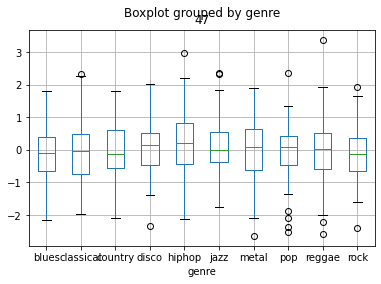

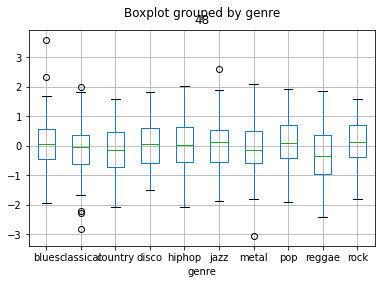

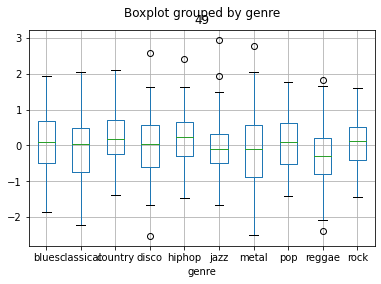

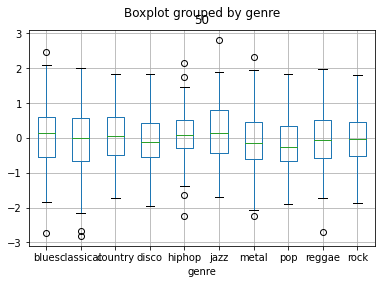

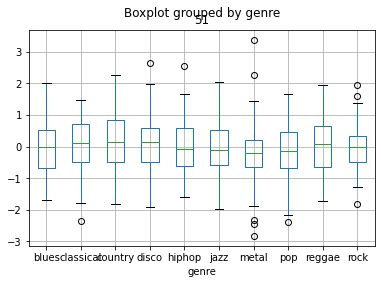

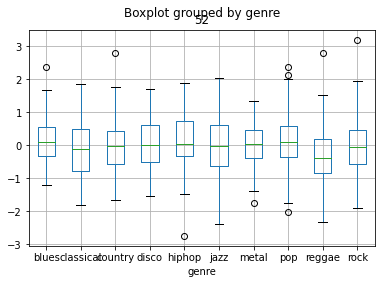

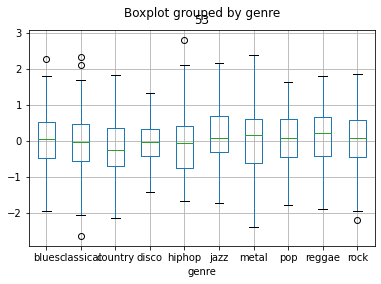

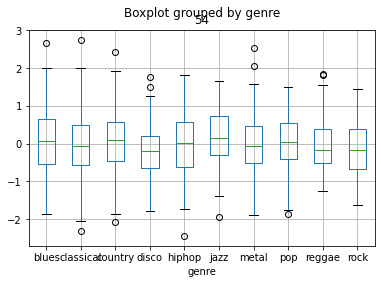

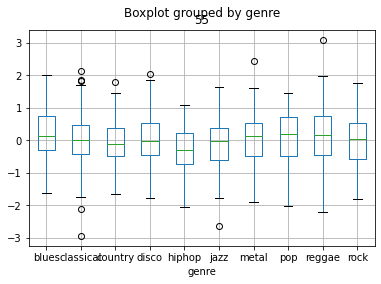

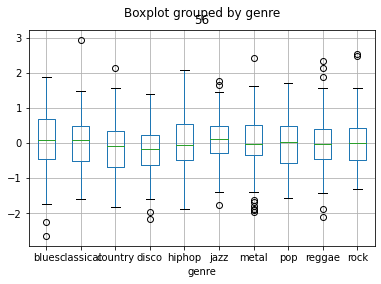

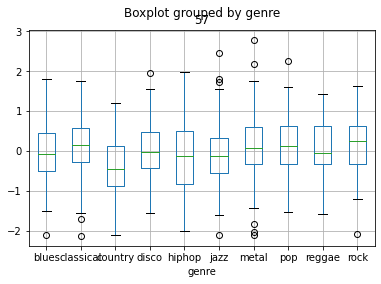

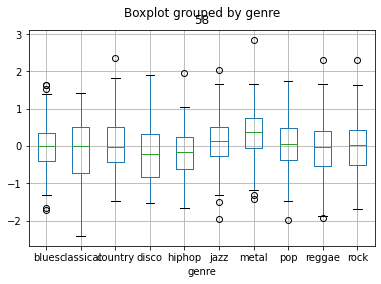

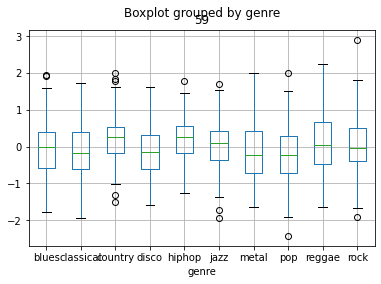

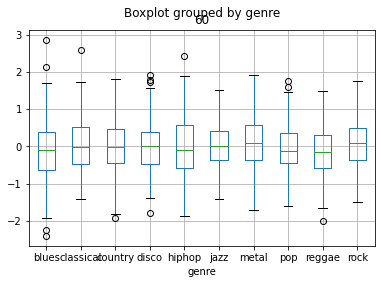

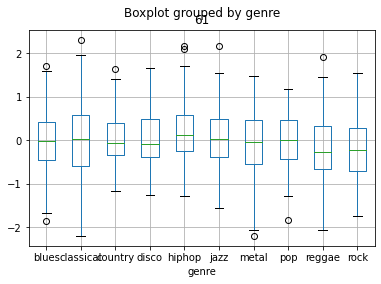

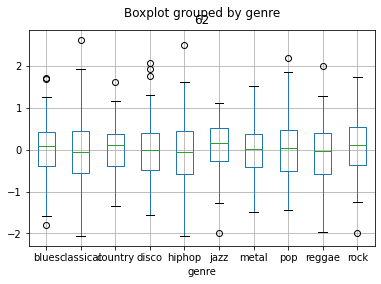

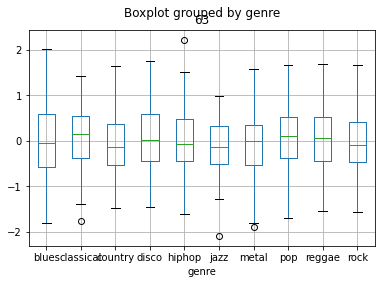

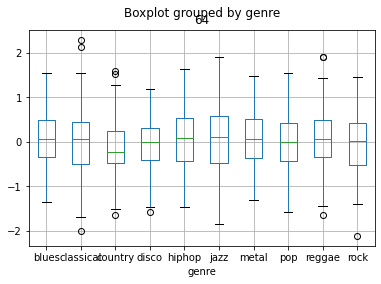

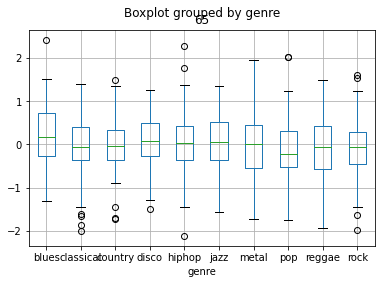

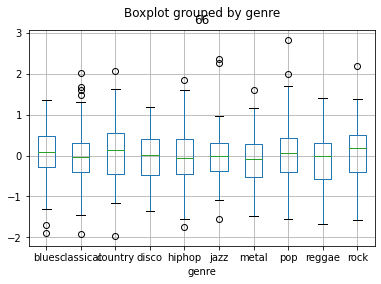

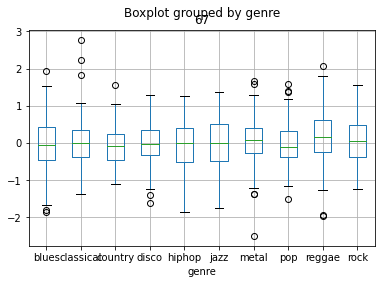

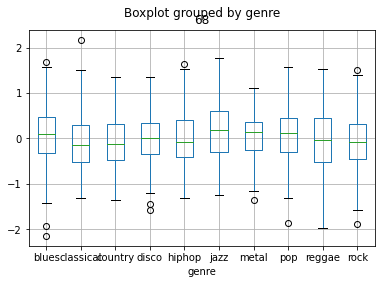

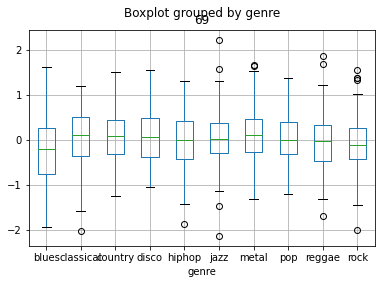

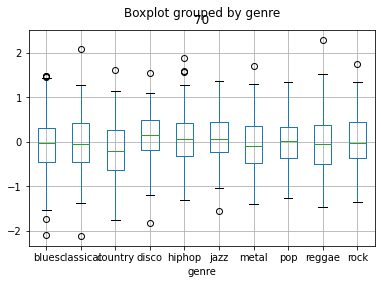

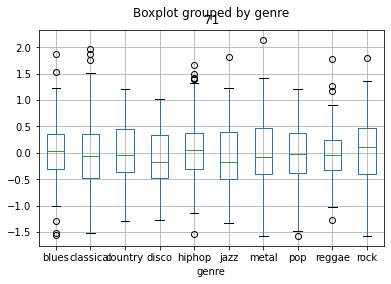

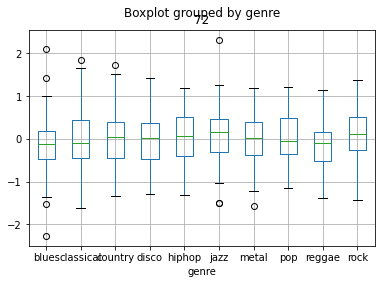

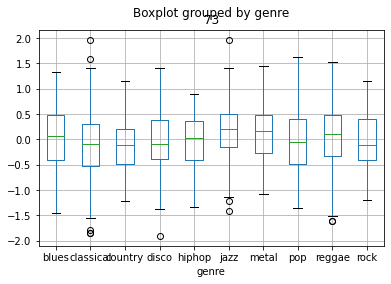

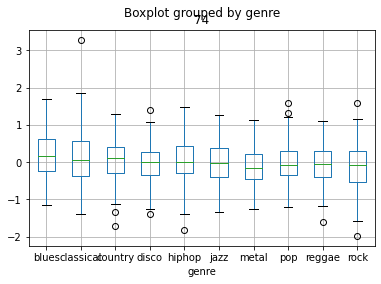

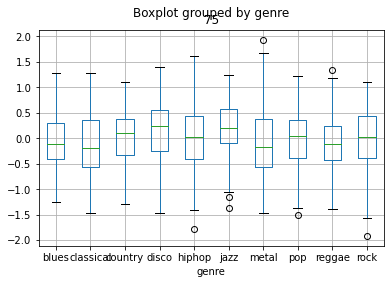

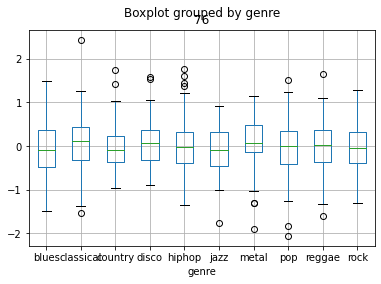

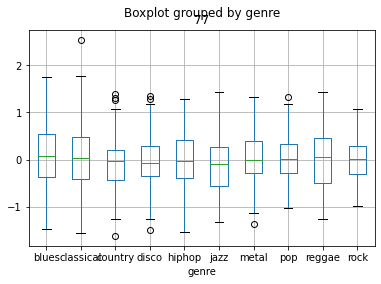

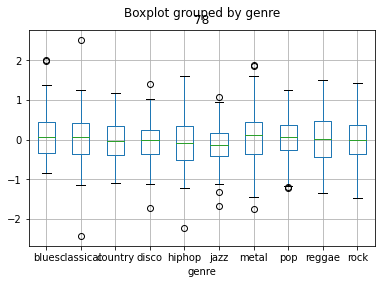

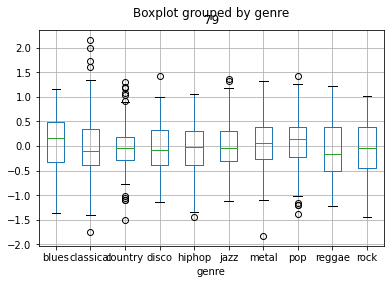

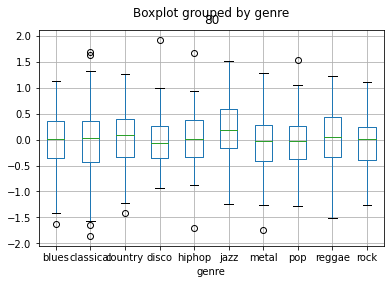

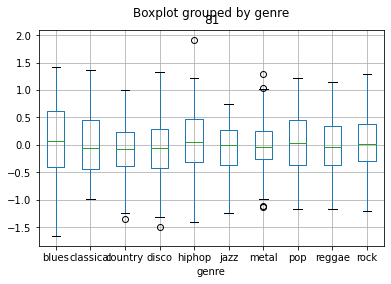

In [ ]:
df2 = df_audio_decomp.copy()
df2['genre'] = right_genre

for col in df2.columns.values:
  if col != 'genre':
    df2.boxplot(col, by='genre')

We see well balanced histograms and a (permit us for saying beautiful) dark Correlation Matrix. We can proceed to use this data through different classifiers.<br>
Before that, let us use LabelEncoder to encode the target values (stored in array right_genre)

In [ ]:
labelencoder = LabelEncoder()
print(right_genre)
right_genre = labelencoder.fit_transform(right_genre)
print(right_genre)

['country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country', 'country'

In [ ]:
saveFile = df_audio_decomp.copy()
saveFile['genre'] = right_genre
saveFile.to_csv("AudioData_Fin.csv")

# Classification

## K Nearest Neighbours Classification

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df_audio_decomp, right_genre, test_size=0.3)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
hyperparams = {'n_neighbors': np.arange(1, 10, 1), 'leaf_size': np.arange(20,70,5)}
knn = KNeighborsClassifier()
knn_data = GridSearchCV(knn, param_grid=hyperparams, cv=cv)
knn_data.fit(train_x, train_y)

print("Optimal Hyperparameters: ", knn_data.best_params_)
print("Best Score: ", knn_data.best_score_)

print('Test report:')
y_true, y_pred, y_prob = np.squeeze(test_y), knn_data.predict(np.array(test_x)), knn_data.predict_proba(np.array(test_x))
print(classification_report(y_true, y_pred))
print('Test F1: ' + str(f1_score(y_true, y_pred, average='micro')))
print('Test AUC-ROC: ' + str(roc_auc_score(y_true, y_prob, multi_class="ovr")))

knn_fin = KNeighborsClassifier()
knn_fin.set_params(leaf_size=knn_data.best_params_['leaf_size'], n_neighbors=knn_data.best_params_['n_neighbors'])
knn_fin.fit(df_audio_decomp, right_genre)

Optimal Hyperparameters:  {'leaf_size': 20, 'n_neighbors': 7}
Best Score:  0.6923809523809523
Test report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75        34
           1       0.89      0.80      0.84        30
           2       0.59      0.74      0.66        27
           3       0.40      0.68      0.51        31
           4       0.67      0.48      0.56        29
           5       0.76      0.85      0.80        33
           6       0.78      0.56      0.65        32
           7       0.82      0.70      0.75        33
           8       0.52      0.62      0.57        21
           9       0.43      0.40      0.41        30

    accuracy                           0.65       300
   macro avg       0.67      0.65      0.65       300
weighted avg       0.68      0.65      0.66       300

Test F1: 0.65
Test AUC-ROC: 0.9248204413569077


KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

## Support Vector Machine (One Vs Rest)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df_audio_decomp, right_genre, test_size=0.25)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

hyperparams = {'C': l1_min_c(train_x, train_y, loss='log') *np.logspace(0,4,8)}
svc = LinearSVC(max_iter = 10000, tol=1e-2)
svc_data = GridSearchCV(svc, param_grid=hyperparams, cv=cv)
svc_data.fit(train_x, train_y)

print("Optimal Hyperparameters: ", svc_data.best_params_)
print("Best Score: ", svc_data.best_score_)

print('Test Classification report:')
y_true, y_pred, y_prob = np.squeeze(test_y), svc_data.predict(np.array(test_x)), svc_data.decision_function(np.array(test_x))
print(classification_report(y_true, y_pred))
print('Test F1: ' + str(f1_score(y_true, y_pred, average='micro')))
# print('Test AUC-ROC: ' + str(roc_auc_score(y_true, y_prob, multi_class='ovr')))

svc_fin = LinearSVC(max_iter=10000, tol=1e-3)
svc_fin.set_params(C=svc_data.best_params_['C'])
svc_fin.fit(df_audio_decomp, right_genre)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Optimal Hyperparameters:  {'C': 0.005778136654053996}
Best Score:  0.7226666666666668
Test Classification report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        19
           1       0.96      1.00      0.98        25
           2       0.84      0.72      0.78        29
           3       0.61      0.58      0.60        24
           4       0.62      0.67      0.64        24
           5       0.75      0.91      0.82        23
           6       0.59      1.00      0.75        19
           7       0.68      0.93      0.79        28
           8       0.95      0.57      0.71        35
           9       0.58      0.29      0.39        24

    accuracy                           0.74       250
   macro avg       0.74      0.75      0.72       250
weighted avg       0.75      0.74      0.72       250

Test F1: 0.736


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.005778136654053996, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=10000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.001, verbose=0)

## Decision Tree Classifier

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df_audio_decomp, right_genre, test_size=0.25)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

hyperparams = {'criterion': ['gini', 'entropy'], 'min_samples_split': np.arange(4,9)*0.001}
dtc = DecisionTreeClassifier()
dtc_data = GridSearchCV(dtc, param_grid=hyperparams, cv=cv)
dtc_data.fit(train_x, train_y)

print("Optimal Hyperparameters: ", dtc_data.best_params_)
print("Best Score: ", dtc_data.best_score_)

print('Test Classification report:')
y_true, y_pred, y_prob = np.squeeze(test_y), dtc_data.predict(np.array(test_x)), dtc_data.predict_proba(np.array(test_x))
print(classification_report(y_true, y_pred))
print('Test F1: ' + str(f1_score(y_true, y_pred, average='micro')))
print('Test AUC-ROC: ' + str(roc_auc_score(y_true, y_prob, multi_class='ovr')))

dtc_fin = DecisionTreeClassifier()
dtc_fin.set_params(criterion=dtc_data.best_params_['criterion'], min_samples_split=dtc_data.best_params_['min_samples_split'])
dtc_fin.fit(df_audio_decomp, right_genre)

Optimal Hyperparameters:  {'criterion': 'entropy', 'min_samples_split': 0.007}
Best Score:  0.43244444444444446
Test Classification report:
              precision    recall  f1-score   support

           0       0.57      0.42      0.48        31
           1       0.84      0.84      0.84        19
           2       0.37      0.38      0.38        26
           3       0.33      0.33      0.33        27
           4       0.47      0.41      0.44        22
           5       0.41      0.62      0.49        21
           6       0.57      0.77      0.66        26
           7       0.56      0.39      0.46        23
           8       0.36      0.29      0.32        34
           9       0.38      0.43      0.40        21

    accuracy                           0.47       250
   macro avg       0.49      0.49      0.48       250
weighted avg       0.48      0.47      0.47       250

Test F1: 0.472
Test AUC-ROC: 0.7267051426031215


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.007,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Gaussian Naive Bayes Classifier

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df_audio_decomp, right_genre, test_size=0.25)

gnb = GaussianNB()
gnb.fit(train_x, train_y)

print('Test Classification report:')
y_true, y_pred, y_prob = np.squeeze(test_y), gnb.predict(np.array(test_x)), gnb.predict_proba(np.array(test_x))
print('Score: {}'.format(gnb.score(test_x,test_y)))
print(classification_report(y_true, y_pred))
print('Test F1: ' + str(f1_score(y_true, y_pred, average='micro')))
print('Test AUC-ROC: ' + str(roc_auc_score(y_true, y_prob, multi_class='ovr')))

gnb_fin = GaussianNB()
gnb_fin.fit(df_audio_decomp, right_genre)

Test Classification report:
Score: 0.704
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        25
           1       0.79      0.88      0.83        25
           2       0.91      0.62      0.74        32
           3       0.62      0.70      0.65        23
           4       0.69      0.67      0.68        27
           5       0.94      0.68      0.79        22
           6       0.79      0.75      0.77        20
           7       0.71      0.85      0.77        20
           8       0.60      0.56      0.58        32
           9       0.42      0.54      0.47        24

    accuracy                           0.70       250
   macro avg       0.72      0.71      0.71       250
weighted avg       0.72      0.70      0.71       250

Test F1: 0.704
Test AUC-ROC: 0.9352627138340285


GaussianNB(priors=None, var_smoothing=1e-09)

## Neural Network Multi-Layer Perceptron Classifier

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df_audio_decomp, right_genre, test_size=0.25)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

hyperparams = {'hidden_layer_sizes': np.arange(90,110,5), 'alpha': np.logspace(-5,-2, num=6)}
mlp = MLPClassifier(max_iter=5000, tol=1e-2)
mlp_data = GridSearchCV(mlp, param_grid=hyperparams, cv=cv)
mlp_data.fit(train_x, train_y)

print("Optimal Hyperparameters: ", mlp_data.best_params_)
print("Best Score: ", mlp_data.best_score_)

print('Test Classification report:')
y_true, y_pred, y_prob = np.squeeze(test_y), mlp_data.predict(np.array(test_x)), mlp_data.predict_proba(np.array(test_x))
print(classification_report(y_true, y_pred))
print('Test F1: ' + str(f1_score(y_true, y_pred, average='micro')))
print('Test AUC-ROC: ' + str(roc_auc_score(y_true, y_prob, multi_class='ovr')))

mlp_fin = MLPClassifier(max_iter=5000, tol=1e-2)
mlp_fin.set_params(hidden_layer_sizes=mlp_data.best_params_['hidden_layer_sizes'], alpha=mlp_data.best_params_['alpha'])
mlp_fin.fit(df_audio_decomp, right_genre)

Optimal Hyperparameters:  {'alpha': 0.0025118864315095794, 'hidden_layer_sizes': 105}
Best Score:  0.7488888888888888
Test Classification report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       1.00      0.91      0.95        32
           2       0.61      0.77      0.68        22
           3       0.79      0.52      0.62        29
           4       0.79      0.82      0.81        28
           5       0.75      0.88      0.81        24
           6       0.90      0.78      0.84        23
           7       0.78      0.82      0.80        22
           8       0.67      0.73      0.70        22
           9       0.35      0.50      0.41        18

    accuracy                           0.75       250
   macro avg       0.76      0.75      0.74       250
weighted avg       0.78      0.75      0.76       250

Test F1: 0.752
Test AUC-ROC: 0.9621408246128575


MLPClassifier(activation='relu', alpha=0.0025118864315095794, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=105, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=5000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.01, validation_fraction=0.1, verbose=False,
              warm_start=False)

# Testing

For Testing, we use files downloaded from different sources other than the GTZAN dataset and of varying lengths (Sources mentioned in the report). We extract features from the audio test data using the same logic and function. Then, we subject the test data through the same transformations of scaling and PCA (using the same decomposer/scaler which was fitted on the train data). <br>
Then, we use our trained models of KNN, SVC, Decision Tree, Naive Bayes and Multi Layer Perceptron to predict the genres of the test data in csv files.<br><br>
We can then compare the predictions to the actual genre data found in Ground_Truth folder (this is info directly obtained from aforementioned sources). This will give us an idea if our trained models can be used in practical applications and how accurate they are given the ambiguity of real life music genres.


In [ ]:
folder = './testDataset/'
outputDB = 'testAudioFeat.csv'
df_audioTest = pd.DataFrame(columns=audioCols())

for audioFile in os.listdir(folder):
  to_add = extractFeaturesFromAudio(folder+audioFile)
  df_audioTest = df_audioTest.append(to_add, ignore_index=True)

df_audioTest = removeUselessCols(df_audioTest)
df_audioTest = scaler.transform(df_audioTest)
df_audioTest_decomp = pca_fin.transform(df_audioTest)

y_pred_knn = pd.DataFrame(knn_fin.predict(np.array(df_audioTest_decomp)), columns=['genre'])
y_pred_knn['fileName'] = os.listdir(folder)
y_pred_knn.to_csv("KNN_Genre_Predictions.csv")

y_pred_svc = pd.DataFrame(svc_fin.predict(np.array(df_audioTest_decomp)), columns=['genre'])
y_pred_svc['fileName'] = os.listdir(folder)
y_pred_svc.to_csv("SVC_Genre_Predictions.csv")

y_pred_dtc = pd.DataFrame(dtc_fin.predict(np.array(df_audioTest_decomp)), columns=['genre'])
y_pred_dtc['fileName'] = os.listdir(folder)
y_pred_dtc.to_csv("DTC_Genre_Predictions.csv")

y_pred_gnb = pd.DataFrame(gnb_fin.predict(np.array(df_audioTest_decomp)), columns=['genre'])
y_pred_gnb['fileName'] = os.listdir(folder)
y_pred_gnb.to_csv("GNB_Genre_Predictions.csv")

y_pred_mlp = pd.DataFrame(mlp_fin.predict(np.array(df_audioTest_decomp)), columns=['genre'])
y_pred_mlp['fileName'] = os.listdir(folder)
y_pred_mlp.to_csv("MLP_Genre_Predictions.csv")